# Necessary Steps

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 61.9 MB/s eta 0:00:00


In [4]:
import os
import rasterio
import numpy as np
from scipy import ndimage
import matplotlib.pyplot as plt
import math
import glob
import pandas as pd
import seaborn as sns
import geopandas as gpd
from rasterio.mask import mask
import csv
import shutil
from datetime import datetime
from matplotlib.patches import Patch
from sklearn.cluster import KMeans
import matplotlib.patches as mpatches

In [5]:
cd /content/drive/MyDrive/Equity_Aatif

/content/drive/MyDrive/Equity_Aatif


In [6]:
pwd = os.getcwd()
pwd

'/content/drive/MyDrive/Equity_Aatif'

# Calculate Sensitivity

In [ ]:
pwd

In [ ]:
import os
import glob
import numpy as np
import rasterio
from math import comb

def calculate_ndvi_sensitivity():
    """
    Calculate NDVI sensitivity for all regions and seasons based on drought vs non-drought years
    """

    # Base configuration
    base_folder = "1.Entire_Data/Crop_Health_NDVI/NDVI"
    output_base = "1.Entire_Data/Crop_Health_NDVI/Sensitivity"
    seasons = ['kharif', 'rabi', 'zaid']
    all_years = list(range(2017, 2023))

    # Region-specific drought years
    drought_years_dict = {
        'Rajnagar': [2018, 2022],
        'Masalia': [2018, 2022],
        'Devadurga': [2018],
        'Lakshmipur': [],
        'Boipariguda': [],
        'Purunakot': [],
        'Pindwara': [],
        'Mandalghar': [],
        'Sawali': [2018],
    }

    # Create output base directory if it doesn't exist
    os.makedirs(output_base, exist_ok=True)

    # Process each region
    for region_name, drought_years in drought_years_dict.items():
        # Skip regions without drought years
        if not drought_years:
            print(f"Skipping {region_name} - no drought years defined")
            continue

        print(f"\nProcessing region: {region_name}")
        print(f"Drought years: {drought_years}")

        # Calculate non-drought years for this region
        nondrought_years = [y for y in all_years if y not in drought_years]

        # Calculate nC2 for this region (combinations of drought vs non-drought)
        n_combinations = len(drought_years) * len(nondrought_years)

        if n_combinations == 0:
            print(f"Warning: No valid combinations for {region_name}")
            continue

        print(f"Non-drought years: {nondrought_years}")
        print(f"Total combinations: {n_combinations}")

        # Create output directory for this region
        region_output_dir = os.path.join(output_base, region_name)
        os.makedirs(region_output_dir, exist_ok=True)

        # Input folder for this region
        input_folder = os.path.join(base_folder, region_name)

        if not os.path.exists(input_folder):
            print(f"Warning: Input folder {input_folder} does not exist")
            continue

        # Process each season for this region
        for season in seasons:
            print(f"  Processing season: {season}")

            # Find all TIFF files for this region and season
            pattern = os.path.join(input_folder, f'{region_name}_{season}_ndvi_agricultural_*.tif')
            tif_files_list = glob.glob(pattern)

            if not tif_files_list:
                print(f"    Warning: No files found for pattern {pattern}")
                continue

            # Extract year from filename and create dictionary
            tif_files = {}
            for f in tif_files_list:
                try:
                    # Extract year from filename (assuming format: region_season_ndvi_agricultural_YEAR.tif)
                    year = int(os.path.basename(f).split('_')[-1].split('.')[0])
                    tif_files[year] = f
                except (ValueError, IndexError) as e:
                    print(f"    Warning: Could not extract year from filename {f}: {e}")
                    continue

            print(f"    Found files for years: {sorted(tif_files.keys())}")

            # Check if we have data for required years
            available_drought_years = [y for y in drought_years if y in tif_files]
            available_nondrought_years = [y for y in nondrought_years if y in tif_files]

            if not available_drought_years or not available_nondrought_years:
                print(f"    Warning: Missing data for {season} season in {region_name}")
                print(f"    Available drought years: {available_drought_years}")
                print(f"    Available non-drought years: {available_nondrought_years}")
                continue

            # Load NDVI data
            ndvi_data = {}
            profile = None

            for year, path in tif_files.items():
                if year in available_drought_years or year in available_nondrought_years:
                    try:
                        with rasterio.open(path) as src:
                            arr = src.read(1).astype(np.float32)
                            arr[arr == src.nodata] = np.nan
                            ndvi_data[year] = arr
                            if profile is None:
                                profile = src.profile.copy()
                                profile.update(dtype=rasterio.float32)
                        print(f"    Loaded data for year {year}")
                    except Exception as e:
                        print(f"    Error loading {path}: {e}")
                        continue

            if len(ndvi_data) < 2:
                print(f"    Error: Insufficient data loaded for {season} season in {region_name}")
                continue

            # Calculate pixel-wise sensitivity
            print(f"    Calculating sensitivity...")

            # Initialize numerator with zeros
            first_array = next(iter(ndvi_data.values()))
            numerator = np.zeros_like(first_array, dtype=np.float32)

            # Calculate differences between non-drought and drought years
            combination_count = 0
            for d_year in available_drought_years:
                for nd_year in available_nondrought_years:
                    if d_year in ndvi_data and nd_year in ndvi_data:
                        nd_arr = ndvi_data[nd_year]
                        d_arr = ndvi_data[d_year]
                        diff = nd_arr - d_arr  # NDVI_ND - NDVI_D
                        numerator += diff
                        combination_count += 1

            if combination_count == 0:
                print(f"    Error: No valid combinations calculated for {season} season in {region_name}")
                continue

            # Calculate sensitivity (average difference)
            sensitivity = numerator / combination_count
            print(f"    Used {combination_count} combinations for sensitivity calculation")

            # Save output
            output_filename = f"{region_name.lower()}_{season}_ndvi_sensitivity.tif"
            output_path = os.path.join(region_output_dir, output_filename)

            try:
                with rasterio.open(output_path, 'w', **profile) as dst:
                    dst.write(sensitivity, 1)
                print(f"    Sensitivity raster saved to {output_path}")

                # Print some statistics
                valid_pixels = ~np.isnan(sensitivity)
                if np.any(valid_pixels):
                    print(f"    Sensitivity stats - Min: {np.nanmin(sensitivity):.4f}, "
                          f"Max: {np.nanmax(sensitivity):.4f}, "
                          f"Mean: {np.nanmean(sensitivity):.4f}")

            except Exception as e:
                print(f"    Error saving {output_path}: {e}")
                continue

    print("\nNDVI sensitivity analysis completed!")

if __name__ == "__main__":
    calculate_ndvi_sensitivity()


Processing region: Rajnagar
Drought years: [2018, 2022]
Non-drought years: [2017, 2019, 2020, 2021]
Total combinations: 8
  Processing season: kharif
    Found files for years: [2017, 2018, 2019, 2020, 2021, 2022]
    Loaded data for year 2019
    Loaded data for year 2018
    Loaded data for year 2022
    Loaded data for year 2020
    Loaded data for year 2017
    Loaded data for year 2021
    Calculating sensitivity...
    Used 8 combinations for sensitivity calculation
    Sensitivity raster saved to 1.Entire_Data/Crop_Health_NDVI/Sensitivity/Rajnagar/rajnagar_kharif_ndvi_sensitivity.tif
    Sensitivity stats - Min: -0.2370, Max: 0.2030, Mean: -0.0248
  Processing season: rabi
    Found files for years: [2017, 2018, 2019, 2020, 2021, 2022]
    Loaded data for year 2018
    Loaded data for year 2020
    Loaded data for year 2019
    Loaded data for year 2021
    Loaded data for year 2022
    Loaded data for year 2017
    Calculating sensitivity...
    Used 8 combinations for sensiti

In [ ]:
# # CHANGE 2.0

# tif_files = {
#     int(os.path.basename(f).split('_')[-1].split('.')[0]): f
#     for f in glob.glob(os.path.join(input_folder, 'masalia_kharif_ndvi_agricultural_*.tif'))
# }


# ndvi_data = {}
# for year, path in tif_files.items():
#     with rasterio.open(path) as src:
#         arr = src.read(1).astype(np.float32)
#         arr[arr == src.nodata] = np.nan
#         ndvi_data[year] = arr
#         profile = src.profile

# # Stack drought and non-drought NDVI arrays
# drought_stack = np.array([ndvi_data[y] for y in drought_years])
# nondrought_stack = np.array([ndvi_data[y] for y in nondrought_years])

# # Compute means across time for each pixel
# mean_drought = np.nanmean(drought_stack, axis=0)
# mean_nondrought = np.nanmean(nondrought_stack, axis=0)

# # Compute sensitivity
# sensitivity = mean_drought - mean_nondrought  # Changed formula


# # Save output
# output_path = "masalia_ndvi_sensitivity.tif"
# with rasterio.open(output_path, 'w', **profile) as dst:
#     dst.write(sensitivity.astype(np.float32), 1)

# print(f"Sensitivity raster saved to {output_path}")


## Details

In [ ]:
pwd

'/content/drive/MyDrive/Equity_Aatif'

In [ ]:
output_path = '1.Entire_Data/Crop_Health_NDVI/Sensitivity/Sawali/sawali_kharif_ndvi_sensitivity.tif'

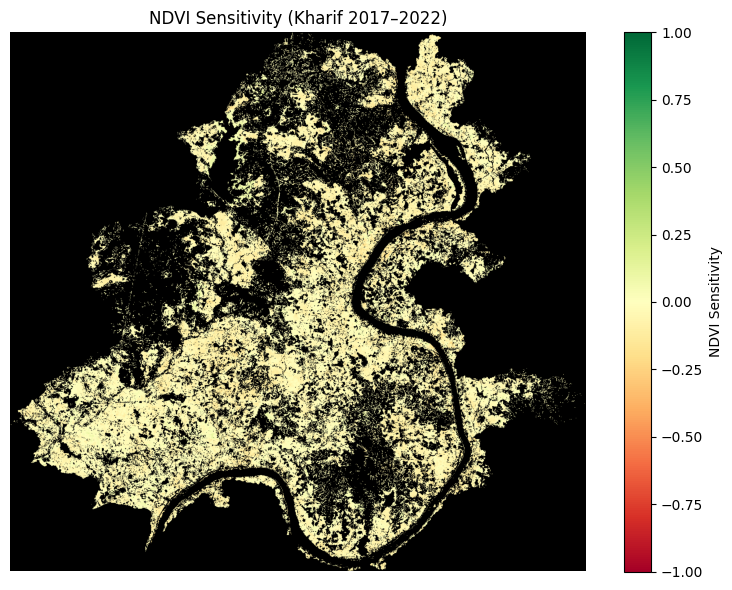

In [ ]:
import matplotlib.pyplot as plt
import numpy.ma as ma

# Read the sensitivity raster back in
with rasterio.open(output_path) as src:
    sensitivity = src.read(1)
    transform = src.transform

# Mask NaNs for visualization
sensitivity_masked = ma.masked_invalid(sensitivity)

# Plot
plt.figure(figsize=(8, 6))
cmap = plt.cm.RdYlGn
cmap.set_bad(color='black')  # For missing pixels
plt.imshow(sensitivity_masked, cmap=cmap, vmin=-1, vmax=1)
plt.colorbar(label='NDVI Sensitivity')
plt.title('NDVI Sensitivity (Kharif 2017–2022)')
plt.axis('off')
plt.tight_layout()
plt.show()


In [ ]:
# Sample 5 random pixels (non-NaN)
valid_mask = ~np.isnan(sensitivity)
valid_indices = np.column_stack(np.where(valid_mask))

# Pick 5 random pixel indices
np.random.seed(42)
sample_indices = valid_indices[np.random.choice(len(valid_indices), 10, replace=False)]

print("Sample Sensitivity Values:")
for idx, (row, col) in enumerate(sample_indices):
    value = sensitivity[row, col]
    x, y = rasterio.transform.xy(transform, row, col)
    print(f"{idx+1}. Pixel @ row={row}, col={col} (Lat: {y:.4f}, Lon: {x:.4f}) → Sensitivity = {value:.4f}")


Sample Sensitivity Values:
1. Pixel @ row=823, col=613 (Lat: 20.1120, Lon: 79.8393) → Sensitivity = 0.0391
2. Pixel @ row=564, col=559 (Lat: 20.1818, Lon: 79.8247) → Sensitivity = -0.0757
3. Pixel @ row=111, col=901 (Lat: 20.3039, Lon: 79.9169) → Sensitivity = 0.0028
4. Pixel @ row=1017, col=424 (Lat: 20.0597, Lon: 79.7883) → Sensitivity = -0.0583
5. Pixel @ row=1262, col=893 (Lat: 19.9937, Lon: 79.9147) → Sensitivity = -0.0255
6. Pixel @ row=815, col=768 (Lat: 20.1141, Lon: 79.8810) → Sensitivity = -0.0435
7. Pixel @ row=807, col=714 (Lat: 20.1163, Lon: 79.8665) → Sensitivity = -0.0757
8. Pixel @ row=941, col=339 (Lat: 20.0802, Lon: 79.7654) → Sensitivity = -0.0506
9. Pixel @ row=614, col=1223 (Lat: 20.1683, Lon: 80.0036) → Sensitivity = 0.0648
10. Pixel @ row=563, col=497 (Lat: 20.1820, Lon: 79.8080) → Sensitivity = -0.0358


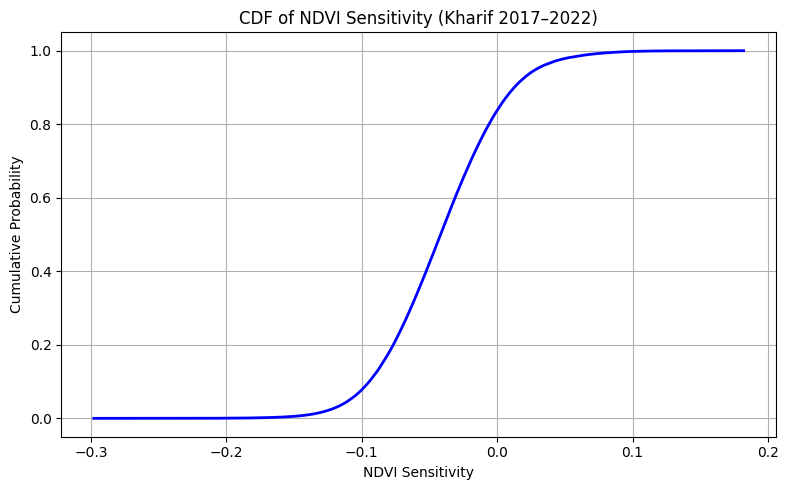

In [ ]:
# Flatten and filter valid sensitivity values (excluding NaNs)
sensitivity_flat = sensitivity[~np.isnan(sensitivity)]

# Sort the values
sorted_vals = np.sort(sensitivity_flat)

# Compute CDF values
cdf = np.linspace(0, 1, len(sorted_vals))

# Plot CDF
plt.figure(figsize=(8, 5))
plt.plot(sorted_vals, cdf, color='blue', linewidth=2)
plt.title('CDF of NDVI Sensitivity (Kharif 2017–2022)')
plt.xlabel('NDVI Sensitivity')
plt.ylabel('Cumulative Probability')
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
percentiles = [10, 25, 50, 75, 90, 99]
for p in percentiles:
    val = np.percentile(sensitivity_flat, p)
    print(f"{p}th percentile: {val:.4f}")


10th percentile: -0.0945
25th percentile: -0.0699
50th percentile: -0.0418
75th percentile: -0.0131
90th percentile: 0.0126
99th percentile: 0.0684


In [ ]:
# Compute and print statistics
min_val = np.min(sensitivity_flat)
max_val = np.max(sensitivity_flat)
median_val = np.median(sensitivity_flat)

print("\n--- NDVI Sensitivity Statistics ---")
print(f"Minimum Sensitivity: {min_val:.4f}")
print(f"Maximum Sensitivity: {max_val:.4f}")
print(f"Median Sensitivity:  {median_val:.4f}")



--- NDVI Sensitivity Statistics ---
Minimum Sensitivity: -0.2979
Maximum Sensitivity: 0.1820
Median Sensitivity:  -0.0418


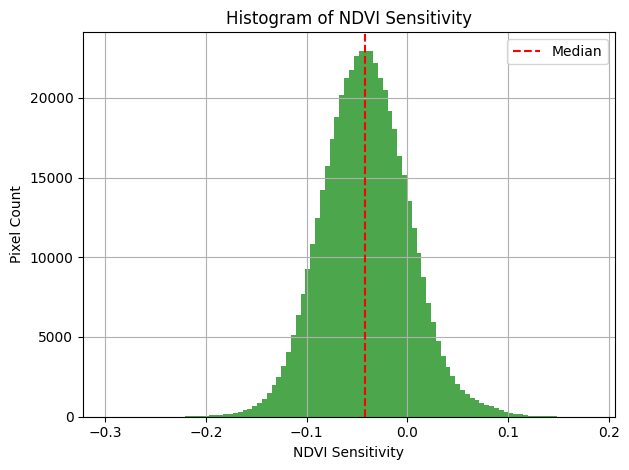

In [ ]:
plt.hist(sensitivity_flat, bins=100, color='green', alpha=0.7)
plt.axvline(median_val, color='red', linestyle='--', label='Median')
plt.title("Histogram of NDVI Sensitivity")
plt.xlabel("NDVI Sensitivity")
plt.ylabel("Pixel Count")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# Count values above and below median
above_median = np.sum(sensitivity_flat > median_val)
below_median = np.sum(sensitivity_flat < median_val)
equal_median = np.sum(sensitivity_flat == median_val)

print("\n--- Value Counts ---")
print(f"Values ABOVE median: {above_median}")
print(f"Values BELOW median: {below_median}")
print(f"Values EQUAL to median: {equal_median}")
print(f"Total valid pixels: {len(sensitivity_flat)}")



--- Value Counts ---
Values ABOVE median: 253387
Values BELOW median: 253387
Values EQUAL to median: 0
Total valid pixels: 506774


In [ ]:
# Count positive and negative sensitivity values
positive_vals = np.sum(sensitivity_flat > 0)
negative_vals = np.sum(sensitivity_flat < 0)
zero_vals = np.sum(sensitivity_flat == 0)

print("\n--- Sign-wise Value Counts ---")
print(f"Positive values: {positive_vals}")
print(f"Negative values: {negative_vals}")
print(f"Zero values: {zero_vals}")
print(f"Total valid pixels: {len(sensitivity_flat)}")



--- Sign-wise Value Counts ---
Positive values: 82290
Negative values: 424484
Zero values: 0
Total valid pixels: 506774


In [ ]:
# # CHANGE 2.0
# import matplotlib.pyplot as plt
# import numpy as np
# import numpy.ma as ma
# from matplotlib.colors import ListedColormap, BoundaryNorm

# # Classify pixels based on new sensitivity definition
# classified = np.full_like(sensitivity, np.nan)
# classified[sensitivity < 0] = 0   # NDVI declined in drought (sensitive)
# classified[sensitivity >= 0] = 1  # NDVI stable or improved in drought (resilient)

# # Mask NaNs for plotting
# classified_masked = ma.masked_invalid(classified)

# # Define colormap and normalization
# cmap = ListedColormap(['red', 'green'])  # 0 = red, 1 = green
# bounds = [-0.5, 0.5, 1.5]
# norm = BoundaryNorm(bounds, cmap.N)

# # Plot
# plt.figure(figsize=(8, 6))
# plt.imshow(classified_masked, cmap=cmap, norm=norm)
# plt.title(
#     'NDVI Sensitivity (Drought − Non-Drought Mean, Kharif 2017–2022)\n'
#     'Green = NDVI Stable or Improved during Drought (Resilient/Irrigated)\n'
#     'Red = NDVI Declined during Drought (Sensitive/Rainfed)',
#     fontsize=11
# )
# plt.axis('off')
# plt.tight_layout()
# plt.show()


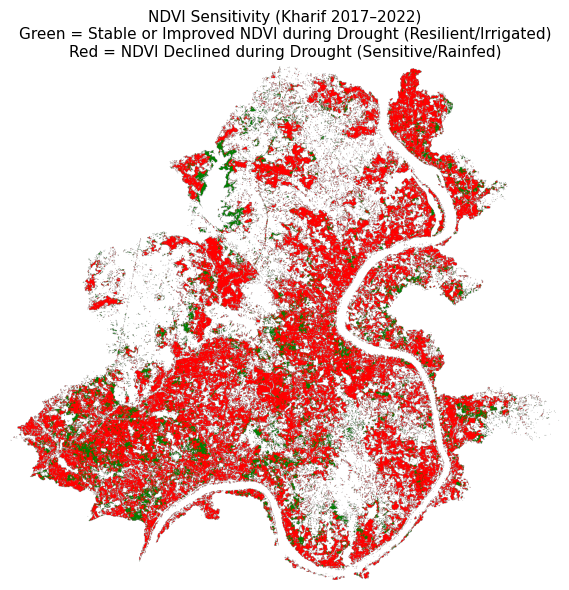

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import numpy.ma as ma
from matplotlib.colors import ListedColormap, BoundaryNorm

# Classify pixels
classified = np.full_like(sensitivity, np.nan)
classified[sensitivity < 0] = 0   # NDVI declined during drought
classified[sensitivity >= 0] = 1  # NDVI stable or improved during drought

# Mask NaNs for plotting
classified_masked = ma.masked_invalid(classified)

# Define colormap and normalization
cmap = ListedColormap(['red', 'green'])  # 0 = red, 1 = green
bounds = [-0.5, 0.5, 1.5]
norm = BoundaryNorm(bounds, cmap.N)

# Plot
plt.figure(figsize=(8, 6))
plt.imshow(classified_masked, cmap=cmap, norm=norm)
plt.title(
    'NDVI Sensitivity (Kharif 2017–2022)\n'
    'Green = Stable or Improved NDVI during Drought (Resilient/Irrigated)\n'
    'Red = NDVI Declined during Drought (Sensitive/Rainfed)',
    fontsize=11
)
plt.axis('off')
plt.tight_layout()
plt.show()


# Calculate Delta G: Ground Water Abstraction

In [ ]:
import rasterio
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import os

In [ ]:
pwd

'/content/drive/MyDrive/Equity_Aatif'

In [ ]:
# Set path to your Delta G raster
#raster_path = "GW_Pindwara_kharif_Mean_2017_2022.tif"
raster_path = "1.Entire_Data/Ground_Water_Abstraction/Pindwara/GW_Pindwara_kharif_Mean_2017_2022.tif"

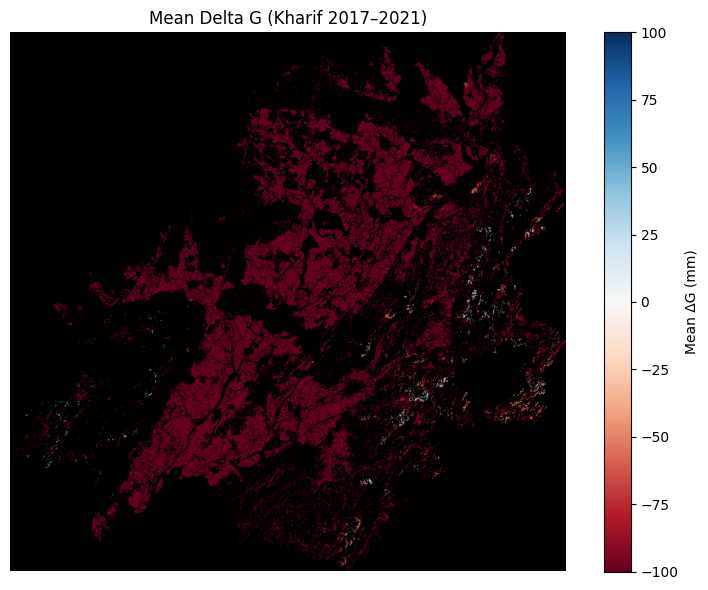

In [ ]:
# Load the raster
with rasterio.open(raster_path) as src:
    delta_g = src.read(1).astype(np.float32)
    delta_g[delta_g == src.nodata] = np.nan
    transform = src.transform

# Mask for plotting
masked_delta_g = ma.masked_invalid(delta_g)

# Plot raster
plt.figure(figsize=(8, 6))
cmap = plt.cm.RdBu
cmap.set_bad(color='black')
plt.imshow(masked_delta_g, cmap=cmap, vmin=-100, vmax=100)
plt.colorbar(label='Mean ΔG (mm)')
plt.title('Mean Delta G (Kharif 2017–2021)')
plt.axis('off')
plt.tight_layout()
plt.show()

## Details

In [ ]:

# ----------------------[ Sample 10 Valid Pixels ]----------------------
valid_mask = ~np.isnan(delta_g)
valid_indices = np.column_stack(np.where(valid_mask))

if len(valid_indices) < 10:
    print("Not enough valid pixels found.")
else:
    np.random.seed(42)
    sample_indices = valid_indices[np.random.choice(len(valid_indices), 10, replace=False)]

    print("\nSample Delta G Values:")
    pixel_values = []
    for i, (row, col) in enumerate(sample_indices):
        value = delta_g[row, col]
        x, y = rasterio.transform.xy(transform, row, col)
        pixel_values.append(value)
        print(f"{i+1}. Pixel @ row={row}, col={col} (Lat: {y:.4f}, Lon: {x:.4f}) → ΔG = {value:.2f} mm")




Sample Delta G Values:
1. Pixel @ row=666, col=1189 (Lat: 24.7866, Lon: 73.0151) → ΔG = -157.87 mm
2. Pixel @ row=252, col=1525 (Lat: 24.8982, Lon: 73.1057) → ΔG = -138.30 mm
3. Pixel @ row=791, col=972 (Lat: 24.7529, Lon: 72.9566) → ΔG = -158.01 mm
4. Pixel @ row=1695, col=814 (Lat: 24.5093, Lon: 72.9141) → ΔG = -158.90 mm
5. Pixel @ row=883, col=526 (Lat: 24.7281, Lon: 72.8364) → ΔG = -141.52 mm
6. Pixel @ row=783, col=928 (Lat: 24.7551, Lon: 72.9448) → ΔG = -163.77 mm
7. Pixel @ row=162, col=1464 (Lat: 24.9225, Lon: 73.0892) → ΔG = -119.66 mm
8. Pixel @ row=621, col=1129 (Lat: 24.7988, Lon: 72.9989) → ΔG = -157.18 mm
9. Pixel @ row=1342, col=1043 (Lat: 24.6045, Lon: 72.9758) → ΔG = -187.97 mm
10. Pixel @ row=800, col=1358 (Lat: 24.7505, Lon: 73.0607) → ΔG = -153.46 mm


In [ ]:
# Flatten and filter valid delta G values (excluding NaNs)
delta_g_flat = delta_g[~np.isnan(delta_g)]

# ---- Statistics ----
min_val = np.min(delta_g_flat)
max_val = np.max(delta_g_flat)
median_val = np.median(delta_g_flat)

print("\n--- Delta G Statistics ---")
print(f"Minimum ΔG: {min_val:.2f} mm")
print(f"Maximum ΔG: {max_val:.2f} mm")
print(f"Median  ΔG: {median_val:.2f} mm")


--- Delta G Statistics ---
Minimum ΔG: -228.82 mm
Maximum ΔG: 96.90 mm
Median  ΔG: -154.30 mm



--- Percentiles ---
10th percentile: -191.74 mm
25th percentile: -172.40 mm
50th percentile: -154.30 mm
75th percentile: -134.73 mm
90th percentile: -114.19 mm
99th percentile: -39.13 mm


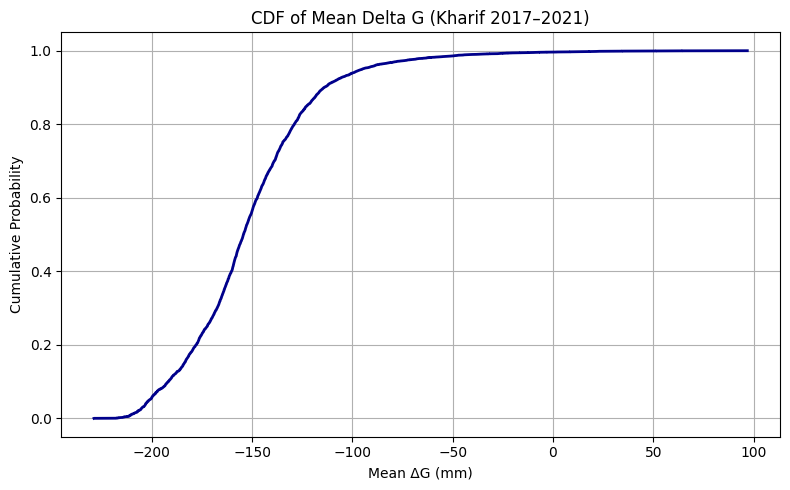

In [ ]:
# ---- Percentiles ----
percentiles = [10, 25, 50, 75, 90, 99]
print("\n--- Percentiles ---")
for p in percentiles:
    val = np.percentile(delta_g_flat, p)
    print(f"{p}th percentile: {val:.2f} mm")

# ---- CDF Plot ----
sorted_vals = np.sort(delta_g_flat)
cdf = np.linspace(0, 1, len(sorted_vals))

plt.figure(figsize=(8, 5))
plt.plot(sorted_vals, cdf, color='darkblue', linewidth=2)
plt.title('CDF of Mean Delta G (Kharif 2017–2021)')
plt.xlabel('Mean ΔG (mm)')
plt.ylabel('Cumulative Probability')
plt.grid(True)
plt.tight_layout()
plt.show()

# Building Irrigation Profile of a region for a season

In [ ]:
pwd

'/content/drive/MyDrive/Equity_Aatif'

In [ ]:

# # ======= STEP 1: SENSITIVITY CALCULATION =======
# Already Done

# ======= STEP 2: UTILITY FUNCTIONS =======
def degrees_to_meters(lat1, lon1, lat2, lon2):
    """Convert lat/lon differences to meters using Haversine formula"""
    R = 6371000  # Earth radius in meters
    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = math.sin(dlat/2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon/2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    return R * c

def create_buffer_zones(water_data, transform, source_type):
    """Create buffer zones around water sources"""
    # Handle NaN and ensure binary data
    water_data_clean = np.nan_to_num(water_data, nan=0)

    # Create binary mask - handle different possible values
    if np.max(water_data_clean) > 1:
        # If data has values > 1, normalize to binary
        water_mask = water_data_clean > 0
    else:
        # Assume already binary or close to binary
        water_mask = water_data_clean >= 0.5

    if np.sum(water_mask) == 0:
        return np.zeros_like(water_data)

    # Calculate pixel size in meters
    center_lat = transform[5] + transform[4] * water_data.shape[0] / 2
    center_lon = transform[2] + transform[0] * water_data.shape[1] / 2

    # Calculate pixel dimensions
    pixel_height = abs(transform[4]) * 111000  # Approximate meters per degree
    pixel_width = abs(transform[0]) * 111000 * math.cos(math.radians(center_lat))
    pixel_size = (pixel_width + pixel_height) / 2

    # Buffer radii in meters
    radii = {
        'Ponds': 100,
        'SWB': 200,
        'Canals': 200,
        'Wells': 50,
        'CheckDams': 200
    }

    buffer_radius = radii.get(source_type, 100)
    buffer_pixels = max(1, int(buffer_radius / pixel_size))

    # Create distance transform and buffer zones
    distances = ndimage.distance_transform_edt(~water_mask)
    zones = (distances <= buffer_pixels).astype(np.int32)

    return zones

def check_file_exists(filepath):
    """Check if file exists"""
    return os.path.exists(filepath)

# ======= STEP 3: ANALYSIS FUNCTIONS =======
def analyze_cropping_patterns(zones_dict, crop_data, transform, sensitivity_data=None):
    """Analyze cropping patterns with water source influence"""

    # Calculate pixel area
    center_lat = transform[5] + transform[4] * crop_data.shape[0] / 2
    pixel_height = abs(transform[4]) * 111000  # Approximate meters per degree
    pixel_width = abs(transform[0]) * 111000 * math.cos(math.radians(center_lat))
    pixel_area = pixel_height * pixel_width  # m²

    # Ensure crop data is binary
    crop_mask = crop_data >= 0.5 if np.max(crop_data) <= 1 else crop_data > 0
    total_crop_pixels = np.sum(crop_mask)

    if total_crop_pixels == 0:
        return {source: 0 for source in zones_dict.keys()}

    results = {}

    # Calculate overlap with each water source
    for source, zones in zones_dict.items():
        if zones is None:
            results[source] = 0
            continue

        # Create zone mask
        zone_mask = zones >= 0.5 if np.max(zones) <= 1 else zones > 0

        # Calculate overlap
        overlap = zone_mask & crop_mask
        overlap_pixels = np.sum(overlap)
        area_hectares = overlap_pixels * pixel_area / 10000  # Convert to hectares

        results[source] = area_hectares

    # Calculate combined water influence
    combined_influence = np.zeros_like(crop_data, dtype=bool)
    for source, zones in zones_dict.items():
        if zones is not None:
            zone_mask = zones >= 0.5 if np.max(zones) <= 1 else zones > 0
            combined_influence = combined_influence | zone_mask

    # Find crop areas not influenced by mapped water sources
    other_zone = crop_mask & (~combined_influence)
    other_pixels = np.sum(other_zone)

    # Split other zone based on sensitivity and groundwater abstraction if available
    if sensitivity_data is not None and other_pixels > 0:
        # Ensure sensitivity data alignment
        if sensitivity_data.shape != crop_data.shape:
            # Try to resize or handle mismatch
            if sensitivity_data.size == crop_data.size:
                sensitivity_data = sensitivity_data.reshape(crop_data.shape)
            else:
                other_area = other_pixels * pixel_area / 10000
                results['Kharif_Protected_Irrigated_by_Borewell'] = other_area
                results['Kharif_Rainfed_NDVI_Sensitivity'] = 0
                return results

        # Clean sensitivity data
        sensitivity_clean = np.nan_to_num(sensitivity_data, nan=0)

        # Load and process groundwater abstraction data if available
        delta_g_data = None
        delta_g_path = "1.Entire_Data/Delta G/Masalia_mean/GW_Abstracted_Kharif_Mean_2017_2022.tif"
        if os.path.exists(delta_g_path):
            try:
                with rasterio.open(delta_g_path) as src:
                    if src.shape == crop_data.shape:
                        delta_g_data = src.read(1)
                    else:
                        delta_g_data = src.read(1, out_shape=crop_data.shape, resampling=rasterio.enums.Resampling.nearest)
                    # Clean delta G data
                    delta_g_data = np.nan_to_num(delta_g_data, nan=0)
            except Exception:
                delta_g_data = None

        # Split based on sensitivity and groundwater abstraction
        if delta_g_data is not None:
            # Resilient areas: Both conditions must be true
            # 1. sensitivity_clean >= 0 (NDVI resilient)
            # 2. delta_g_data < 0 (negative groundwater abstraction)
            stable_irrigated = other_zone & (sensitivity_clean >= 0) & (delta_g_data < 0)

            # Sensitive areas: Either condition is false
            # 1. sensitivity_clean < 0 (NDVI sensitive) OR
            # 2. delta_g_data >= 0 (positive/zero groundwater abstraction)
            vulnerable_irrigated = other_zone & (~((sensitivity_clean >= 0) & (delta_g_data < 0)))
        else:
            # Fallback to original logic if Delta G data not available
            stable_irrigated = other_zone & (sensitivity_clean >= 0)  # Resilient areas
            vulnerable_irrigated = other_zone & (sensitivity_clean < 0)  # Sensitive areas

        stable_pixels = np.sum(stable_irrigated)
        vulnerable_pixels = np.sum(vulnerable_irrigated)

        stable_area = stable_pixels * pixel_area / 10000
        vulnerable_area = vulnerable_pixels * pixel_area / 10000

        results['Kharif_Rainfed_NDVI_Sensitivity'] = stable_area
        results['Kharif_Protected_Irrigated_by_Borewell'] = vulnerable_area
    else:
        # No sensitivity data available
        other_area = other_pixels * pixel_area / 10000
        results['Kharif_Protected_Irrigated_by_Borewell'] = other_area
        results['Kharif_Rainfed_NDVI_Sensitivity'] = 0

    return results

def compute_protection_features(results):
    """Compute protection features from analysis results"""
    feature_dict = {}

    # Water source features
    for src in ['SWB', 'Ponds', 'Wells', 'Canals', 'CheckDams']:
        feature_dict[f"Kharif_Protected_Irrigated_by_{src}"] = results.get(src, 0)

    # Sensitivity-based features
    feature_dict['Kharif_Rainfed_NDVI_Sensitivity'] = results.get('Kharif_Rainfed', 0)
    feature_dict['Kharif_Protected_Irrigated_by_Borewell'] = results.get('Kharif_Protected_Irrigated_by_Borewell', 0)

    return feature_dict

# ======= STEP 4: MAIN PROCESSING FUNCTIONS =======
def process_mws_folder(base_dir, sensitivity_path=None):
    """Process a single MWS folder"""

    # Define file paths
    static_sources = {
        'Canals': os.path.join(base_dir, 'Canals.tif'),
        'Wells': os.path.join(base_dir, 'Wells.tif'),
        'Ponds': os.path.join(base_dir, 'Ponds.tif'),
        'CheckDams': os.path.join(base_dir, 'CheckDams.tif')
    }

    seasonal_swb_files = {
        'Kharif': os.path.join(base_dir, 'SWB_Kharif.tif')
    }

    crop_types = {
        'single_kharif': os.path.join(base_dir, "Single_Kharif_Cropping.tif"),
        'double_crop': os.path.join(base_dir, "Double_Cropping.tif"),
        'triple_crop': os.path.join(base_dir, "Triple_Cropping.tif")
    }

    try:
        # Load reference raster (SWB Kharif)
        swb_path = seasonal_swb_files['Kharif']
        if not os.path.exists(swb_path):
            return None

        with rasterio.open(swb_path) as ref_src:
            ref_shape = ref_src.shape
            transform = ref_src.transform
            swb_data = ref_src.read(1)

        # Load sensitivity data
        sensitivity_data = None
        if sensitivity_path and os.path.exists(sensitivity_path):
            try:
                with rasterio.open(sensitivity_path) as src:
                    sens_shape = src.shape

                    # Check if shapes match
                    if sens_shape == ref_shape:
                        sensitivity_data = src.read(1)
                    else:
                        # Try to read with resampling
                        sensitivity_data = src.read(1, out_shape=ref_shape, resampling=rasterio.enums.Resampling.nearest)

            except Exception:
                sensitivity_data = None

        # Create buffer zones
        zones_dict = {}

        # Process SWB
        zones_dict['SWB'] = create_buffer_zones(swb_data, transform, 'SWB')

        # Process static sources
        for source_type, source_path in static_sources.items():
            if os.path.exists(source_path):
                try:
                    with rasterio.open(source_path) as src:
                        data = src.read(1, out_shape=ref_shape, resampling=rasterio.enums.Resampling.nearest)
                        zones_dict[source_type] = create_buffer_zones(data, transform, source_type)
                except Exception:
                    zones_dict[source_type] = np.zeros(ref_shape)
            else:
                zones_dict[source_type] = np.zeros(ref_shape)

        # Analyze cropping patterns
        results = {}
        for crop_name in ['single_kharif']:  # Focus on single_kharif
            crop_path = crop_types[crop_name]
            if os.path.exists(crop_path):
                try:
                    with rasterio.open(crop_path) as crop_src:
                        crop_data = crop_src.read(1, out_shape=ref_shape, resampling=rasterio.enums.Resampling.nearest)

                        crop_results = analyze_cropping_patterns(
                            zones_dict, crop_data, transform, sensitivity_data
                        )
                        results[crop_name] = crop_results

                except Exception:
                    results[crop_name] = {source: 0 for source in zones_dict.keys()}
            else:
                results[crop_name] = {source: 0 for source in zones_dict.keys()}

        # Compute final features
        final_results = results.get('single_kharif', {source: 0 for source in zones_dict.keys()})
        feature_table = compute_protection_features(final_results)

        # Add MSW ID
        msw_id = os.path.basename(base_dir)
        feature_table['MSW_ID'] = msw_id

        return feature_table

    except Exception:
        return None

def run_irrigation_analysis(master_input_dir, master_output_dir, target_region="Masalia",
                          sensitivity_path=None):
    """Main function to run irrigation analysis"""

    print(f"STARTING IRRIGATION ANALYSIS FOR {target_region}")

    input_region_path = os.path.join(master_input_dir, target_region)
    output_region_path = os.path.join(master_output_dir, target_region)

    if not os.path.isdir(input_region_path):
        return

    if sensitivity_path and not os.path.exists(sensitivity_path):
        sensitivity_path = None

    # Process each year
    year_folders = [f for f in os.listdir(input_region_path) if os.path.isdir(os.path.join(input_region_path, f))]

    if not year_folders:
        return

    for year_folder in sorted(year_folders):
        input_year_dir = os.path.join(input_region_path, year_folder)

        print(f"PROCESSING YEAR: {year_folder}")

        # Get MWS folders
        mws_folders = [f for f in os.listdir(input_year_dir) if os.path.isdir(os.path.join(input_year_dir, f))]

        if not mws_folders:
            continue

        all_features = []
        successful_processing = 0

        for i, mws_folder in enumerate(mws_folders):
            base_dir = os.path.join(input_year_dir, mws_folder)

            features = process_mws_folder(base_dir, sensitivity_path)

            if features:
                all_features.append(features)
                successful_processing += 1

            # Progress update every 100 MWS
            if (i + 1) % 100 == 0:
                print(f"Processed {i + 1}/{len(mws_folders)} MWS folders")

        # Save results
        if all_features:
            df_out = pd.DataFrame(all_features)

            # Create output directory
            output_csv_dir = os.path.join(output_region_path, year_folder)
            os.makedirs(output_csv_dir, exist_ok=True)

            # Save CSV
            output_csv_path = os.path.join(output_csv_dir, f"{target_region}_Kharif_Features_{year_folder}.csv")
            df_out.to_csv(output_csv_path, index=False)

            # Show summary statistics
            print(f"SUMMARY FOR {year_folder}: Processed {successful_processing}/{len(mws_folders)} MWS folders")
            print(f"Results saved to: {output_csv_path}")

    print(f"IRRIGATION ANALYSIS COMPLETED FOR {target_region}")

In [ ]:
# ======= MAIN EXECUTION =======
if __name__ == "__main__":
    # Configuration
    PWD = "/content/drive/MyDrive/Equity_Aatif"  # Update this path

    # Input directories
    NDVI_INPUT_FOLDER = os.path.join(PWD, "1.Entire_Data/Crop_Health_NDVI/Masalia")
    MASTER_INPUT_DIR = os.path.join(PWD, "3.Output_Rasters")
    MASTER_OUTPUT_DIR = os.path.join(PWD, "4.TRY")

    # Parameters
    TARGET_REGION = "Masalia"
    SEASON = "kharif"
    DROUGHT_YEARS = [2018, 2022]
    ALL_YEARS = list(range(2017, 2023))

    print("Starting complete irrigation analysis pipeline...")

    # Step 1: Calculate sensitivity (if not already done)
    sensitivity_path = f"1.Entire_Data/Crop_Health_NDVI/Sensitivity/Masalia/{TARGET_REGION.lower()}_{SEASON}_ndvi_sensitivity.tif"


    # Step 2: Run irrigation analysis
    run_irrigation_analysis(
        MASTER_INPUT_DIR,
        MASTER_OUTPUT_DIR,
        TARGET_REGION,
        sensitivity_path
    )

Starting complete irrigation analysis pipeline...
STARTING IRRIGATION ANALYSIS FOR Masalia
PROCESSING YEAR: 17_18
SUMMARY FOR 17_18: Processed 64/64 MWS folders
Results saved to: /content/drive/MyDrive/Equity_Aatif/4.TRY/Masalia/17_18/Masalia_Kharif_Features_17_18.csv
PROCESSING YEAR: 18_19


In [ ]:
# # ======= CONSTANTS =======
# master_input_dir = "3.Output_Rasters"
# master_output_dir = "4.TRY"
# target_region = "Masalia"  # Only process Masalia region
# season = "Kharif"         # Only process Kharif season

In [ ]:
# def degrees_to_meters(lat1, lon1, lat2, lon2):
#     R = 6371000
#     lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])
#     dlat = lat2 - lat1
#     dlon = lon2 - lon1
#     a = math.sin(dlat/2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon/2)**2
#     c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
#     return R * c

# def create_buffer_zones(water_data, transform, source_type):
#     water_data = np.nan_to_num(water_data, nan=0)
#     water_mask = water_data == 1

#     center_lat = transform[5] + transform[4] * water_data.shape[0] / 2
#     center_lon = transform[2] + transform[0] * water_data.shape[1] / 2
#     pixel_height = degrees_to_meters(center_lat, center_lon, center_lat + abs(transform[4]), center_lon)
#     pixel_width = degrees_to_meters(center_lat, center_lon, center_lat, center_lon + abs(transform[0]))
#     pixel_size = (pixel_width + pixel_height) / 2

#     distances = ndimage.distance_transform_edt(~water_mask) * pixel_size

#     radii = {
#         'Ponds': 100,
#         'SWB': 200,
#         'Canals': 200,
#         'Wells': 50,
#         'CheckDams': 200
#     }

#     zones = np.zeros_like(water_data)
#     zones[distances <= radii[source_type]] = 1
#     return zones

# def analyze_cropping_patterns(zones_dict, crop_data, transform, sensitivity_data=None):
#     center_lat = transform[5] + transform[4] * crop_data.shape[0] / 2
#     pixel_height = degrees_to_meters(center_lat, center_lat + abs(transform[4]), center_lat, center_lat)
#     pixel_width = degrees_to_meters(center_lat, center_lat, center_lat, center_lat + abs(transform[0]))
#     pixel_area = pixel_height * pixel_width

#     results = {}
#     for source, zones in zones_dict.items():
#         overlap = (zones == 1) & (crop_data == 1)
#         area = np.sum(overlap) * pixel_area / 10000
#         results[source] = area

#     combined_influence = np.zeros_like(crop_data)
#     for zones in zones_dict.values():
#         combined_influence = np.logical_or(combined_influence, zones == 1)

#     # Modified to incorporate sensitivity data
#     other_zone = ~combined_influence & (crop_data == 1)
#     if sensitivity_data is not None:
#         # Split other_zone into two categories based on sensitivity
#         stable_irrigated = other_zone & (sensitivity_data >= 0)  # Green areas
#         vulnerable_irrigated = other_zone & (sensitivity_data < 0)  # Red areas

#         stable_area = np.sum(stable_irrigated) * pixel_area / 10000
#         vulnerable_area = np.sum(vulnerable_irrigated) * pixel_area / 10000

#         results['Kharif_Rainfed_NDVI_Sensitivity'] = stable_area
#         results['Kharif_Protected_Irrigated_by_Borewell'] = vulnerable_area
#     else:
#         other_area = np.sum(other_zone) * pixel_area / 10000
#         results['Kharif_Protected_Irrigated_by_Borewell'] = other_area

#     return results

# def compute_protection_features(results):
#     # Simplified for Kharif only
#     feature_dict = {}

#     # Water source features
#     for src in ['SWB', 'Ponds', 'Wells', 'Canals', 'CheckDams']:
#         feature_dict[f"Kharif_Protected_Irrigated_by_{src}"] = results.get(src, 0)

#     # Add the sensitivity-based features
#     feature_dict['Kharif_Rainfed_NDVI_Sensitivity'] = results.get('Kharif_Rainfed_NDVI_Sensitivity', 0)
#     feature_dict['Kharif_Protected_Irrigated_by_Borewell'] = results.get('Kharif_Protected_Irrigated_by_Borewell', 0)

#     return feature_dict

# def extract_features_from_table(feature_table, msw_id):
#     feature_table['MSW_ID'] = msw_id
#     return feature_table

# def process_mws_folder(base_dir, sensitivity_path=None):
#     static_sources = {
#         'Canals': os.path.join(base_dir, 'Canals.tif'),
#         'Wells': os.path.join(base_dir, 'Wells.tif'),
#         'Ponds': os.path.join(base_dir, 'Ponds.tif'),
#         'CheckDams': os.path.join(base_dir, 'CheckDams.tif')
#     }

#     seasonal_swb_files = {
#         'Kharif': os.path.join(base_dir, 'SWB_Kharif.tif')
#     }

#     crop_types = {
#         'single_kharif': os.path.join(base_dir, "Single_Kharif_Cropping.tif"),
#         'double_crop': os.path.join(base_dir, "Double_Cropping.tif"),
#         'triple_crop': os.path.join(base_dir, "Triple_Cropping.tif")
#     }

#     try:
#         transform = None
#         results = {}
#         sensitivity_data = None

#         # First get the reference raster's shape and transform
#         with rasterio.open(seasonal_swb_files['Kharif']) as ref_src:
#             ref_shape = ref_src.shape
#             transform = ref_src.transform

#         # Load and align sensitivity data if provided
#         if sensitivity_path and os.path.exists(sensitivity_path):
#             with rasterio.open(sensitivity_path) as src:
#                 # Read the window that matches our MSW's extent
#                 window = rasterio.windows.from_bounds(
#                     transform[2], transform[5] + transform[4]*ref_shape[0],
#                     transform[2] + transform[0]*ref_shape[1], transform[5],
#                     transform=src.transform
#                 )
#                 sensitivity_data = src.read(1, window=window, out_shape=ref_shape)
#                 sensitivity_data = np.nan_to_num(sensitivity_data, nan=0)  # Replace NaN with 0

#         zones_dict = {}

#         with rasterio.open(seasonal_swb_files['Kharif']) as swb_src:
#             swb_data = swb_src.read(1)
#             transform = swb_src.transform
#             zones_dict['SWB'] = create_buffer_zones(swb_data, transform, 'SWB')

#         for source_type, source_path in static_sources.items():
#             with rasterio.open(source_path) as src:
#                 data = src.read(1)
#                 if transform is None:
#                     transform = src.transform
#                 zones_dict[source_type] = create_buffer_zones(data, transform, source_type)

#         for crop_name in ['single_kharif', 'double_crop', 'triple_crop']:
#             crop_path = crop_types[crop_name]
#             with rasterio.open(crop_path) as crop_src:
#                 crop_data = crop_src.read(1)
#                 results[crop_name] = analyze_cropping_patterns(zones_dict, crop_data, transform, sensitivity_data)

#         feature_table = compute_protection_features(results)
#         msw_id = os.path.basename(base_dir)
#         return extract_features_from_table(feature_table, msw_id)

#     except Exception as e:
#         print(f"Error processing {base_dir}: {str(e)}")
#         return None

# def run_masalia_kharif(master_input_dir, master_output_dir):
#     input_region_path = os.path.join(master_input_dir, target_region)
#     output_region_path = os.path.join(master_output_dir, target_region)

#     if not os.path.isdir(input_region_path):
#         print(f"Region directory not found: {input_region_path}")
#         return

#     # Load sensitivity data (assuming it's the same for all years in Masalia)
#     sensitivity_path = "1.Entire_Data/Sensitivity/Masalia/masalia_kharif_ndvi_sensitivity.tif"

#     print(f"\n=== PROCESSING REGION: {target_region} (Kharif only) ===")

#     for year_folder in os.listdir(input_region_path):
#         input_year_dir = os.path.join(input_region_path, year_folder)
#         if not os.path.isdir(input_year_dir):
#             continue

#         print(f"\n→ Year: {year_folder}")
#         output_csv_dir = os.path.join(output_region_path, year_folder)
#         output_csv_path = os.path.join(output_csv_dir, f"{target_region}_Kharif_Features_{year_folder}.csv")

#         all_features = []
#         for mws_folder in os.listdir(input_year_dir):
#             base_dir = os.path.join(input_year_dir, mws_folder)
#             if os.path.isdir(base_dir):
#                 print(f"   ↳ {mws_folder}")  # Fixed variable name here
#                 features = process_mws_folder(base_dir, sensitivity_path)
#                 if features:
#                     all_features.append(features)

#         if all_features:
#             df_out = pd.DataFrame(all_features)
#             os.makedirs(output_csv_dir, exist_ok=True)
#             df_out.to_csv(output_csv_path, index=False)
#             print(f"✅ Saved: {output_csv_path}")
#         else:
#             print(f"⚠️ No features extracted for {target_region} - {year_folder}.")

In [ ]:
# if __name__ == "__main__":
#     run_masalia_kharif(master_input_dir, master_output_dir)


# Building Irrigation Profile of a region across all seasons

In [ ]:
pwd

'/content'

In [ ]:
# CHANGE FROM 'MANDALGHAR' TO 'MANDALGARH'

In [ ]:
# Note: WATER_IN_NON_KHARIF is now set per region in the main execution section
# Purunakot and Boipariguda: 1 (water available in non-kharif seasons)
# All other regions: 0 (no water in non-kharif seasons)

In [ ]:
# ======= UTILITY FUNCTIONS =======
def degrees_to_meters(lat1, lon1, lat2, lon2):
    """Convert lat/lon differences to meters using Haversine formula"""
    R = 6371000  # Earth radius in meters
    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = math.sin(dlat/2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon/2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    return R * c

def create_buffer_zones(water_data, transform, source_type):
    """Create buffer zones around water sources"""
    water_data = np.nan_to_num(water_data, nan=0)
    water_mask = water_data == 1

    center_lat = transform[5] + transform[4] * water_data.shape[0] / 2
    center_lon = transform[2] + transform[0] * water_data.shape[1] / 2
    pixel_height = degrees_to_meters(center_lat, center_lon, center_lat + abs(transform[4]), center_lon)
    pixel_width = degrees_to_meters(center_lat, center_lon, center_lat, center_lon + abs(transform[0]))
    pixel_size = (pixel_width + pixel_height) / 2

    distances = ndimage.distance_transform_edt(~water_mask) * pixel_size

    radii = {
        'Ponds': 100,
        'SWB': 200,
        'Canals': 200,
        'Wells': 50,
        'CheckDams': 200
    }

    zones = np.zeros_like(water_data)
    zones[distances <= radii[source_type]] = 1
    return zones

def analyze_cropping_patterns(zones_dict, crop_data, transform, sensitivity_data=None,
                            season='kharif', target_region='Masalia'):
    """Analyze cropping patterns with water source influence"""
    center_lat = transform[5] + transform[4] * crop_data.shape[0] / 2
    pixel_height = degrees_to_meters(center_lat, center_lat + abs(transform[4]), center_lat, center_lat)
    pixel_width = degrees_to_meters(center_lat, center_lat, center_lat, center_lat + abs(transform[0]))
    pixel_area = pixel_height * pixel_width

    results = {}

    # Calculate overlap with each water source
    for source, zones in zones_dict.items():
        if zones is None:
            results[source] = 0
            continue
        overlap = (zones == 1) & (crop_data == 1)
        area = np.sum(overlap) * pixel_area / 10000  # Convert to hectares
        results[source] = area

    # Calculate combined water influence
    combined_influence = np.zeros_like(crop_data)
    for zones in zones_dict.values():
        if zones is not None:
            combined_influence = np.logical_or(combined_influence, zones == 1)

    # Find crop areas not influenced by mapped water sources
    other_zone = ~combined_influence & (crop_data == 1)
    other_pixels = np.sum(other_zone)

    # Split other zone based on sensitivity and groundwater abstraction if available
    if other_pixels > 0:
        # Load and process groundwater abstraction data if available
        delta_g_data = None
        delta_g_path = f"1.Entire_Data/Ground_Water_Abstraction/{target_region}_mean/GW_{target_region}_{season.title()}_Mean_2017_2022.tif"
        if os.path.exists(delta_g_path):
            try:
                with rasterio.open(delta_g_path) as src:
                    if src.shape == crop_data.shape:
                        delta_g_data = src.read(1)
                    else:
                        delta_g_data = src.read(1, out_shape=crop_data.shape, resampling=rasterio.enums.Resampling.nearest)
                    delta_g_data = np.nan_to_num(delta_g_data, nan=0)
            except Exception:
                delta_g_data = None

        # Check if sensitivity data is available and properly aligned
        sensitivity_available = False
        if sensitivity_data is not None:
            # Ensure sensitivity data alignment
            if sensitivity_data.shape != crop_data.shape:
                if sensitivity_data.size == crop_data.size:
                    sensitivity_data = sensitivity_data.reshape(crop_data.shape)
                else:
                    sensitivity_data = None

            if sensitivity_data is not None:
                sensitivity_clean = np.nan_to_num(sensitivity_data, nan=0)
                sensitivity_available = True

        # Split based on availability of sensitivity and groundwater data
        if sensitivity_available and delta_g_data is not None:
            # Both sensitivity and delta_g available - use original logic
            stable_irrigated = other_zone & (sensitivity_clean >= 0) & (delta_g_data < 0)
            vulnerable_irrigated = other_zone & (~((sensitivity_clean >= 0) & (delta_g_data < 0)))
        elif not sensitivity_available and delta_g_data is not None:
            # Only delta_g available - use delta_g condition only
            stable_irrigated = other_zone & (delta_g_data < 0)
            vulnerable_irrigated = other_zone & (delta_g_data >= 0)
        elif sensitivity_available and delta_g_data is None:
            # Only sensitivity available - use sensitivity condition only
            stable_irrigated = other_zone & (sensitivity_clean >= 0)
            vulnerable_irrigated = other_zone & (sensitivity_clean < 0)
        else:
            # Neither available - all goes to borewell category
            stable_irrigated = np.zeros_like(other_zone, dtype=bool)
            vulnerable_irrigated = other_zone

        stable_pixels = np.sum(stable_irrigated)
        vulnerable_pixels = np.sum(vulnerable_irrigated)

        stable_area = stable_pixels * pixel_area / 10000
        vulnerable_area = vulnerable_pixels * pixel_area / 10000

        results['Rainfed_NDVI_Sensitivity'] = stable_area
        results['Protected_Irrigated_by_Borewell'] = vulnerable_area
    else:
        # No other zone pixels
        results['Protected_Irrigated_by_Borewell'] = 0
        results['Rainfed_NDVI_Sensitivity'] = 0

    return results

def compute_protection_features(results, water_in_non_kharif):
    """Compute protection features from analysis results"""
    season_map = {
        'Kharif': ['single_kharif', 'double_crop', 'triple_crop'],
        'Rabi': ['single_non_kharif', 'double_crop', 'triple_crop'],
        'Zaid': ['triple_crop']
    }

    all_sources = ['SWB', 'Ponds', 'Wells', 'Canals', 'CheckDams']
    feature_dict = {f"{season}_Protected_Irrigated_by_{src}": 0 for season in season_map for src in all_sources}
    feature_dict.update({f"{season}_Protected_Irrigated_by_Borewell": 0 for season in season_map})
    feature_dict.update({f"{season}_Rainfed_NDVI_Sensitivity": 0 for season in season_map})

    for season, crops in season_map.items():
        for crop in crops:
            if crop in results:
                crop_data = results[crop]

                # Add per-source values
                for src in all_sources:
                    # For Ponds and Wells in Rabi/Zaid, respect the water_in_non_kharif flag
                    if src in ['Ponds', 'Wells']:
                        if season == 'Kharif' or water_in_non_kharif == 1:
                            feature_dict[f"{season}_Protected_Irrigated_by_{src}"] += crop_data.get(src, 0)
                        else:
                            # Add to borewell if ponds/wells not considered in non-kharif
                            feature_dict[f"{season}_Protected_Irrigated_by_Borewell"] += crop_data.get(src, 0)
                    else:
                        feature_dict[f"{season}_Protected_Irrigated_by_{src}"] += crop_data.get(src, 0)

                # Add sensitivity-based areas
                feature_dict[f"{season}_Protected_Irrigated_by_Borewell"] += crop_data.get("Protected_Irrigated_by_Borewell", 0)
                feature_dict[f"{season}_Rainfed_NDVI_Sensitivity"] += crop_data.get("Rainfed_NDVI_Sensitivity", 0)

    return feature_dict

def extract_features_from_table(feature_table, msw_id):
    """Extract features from table and add MSW ID"""
    feature_table['MSW_ID'] = msw_id
    return feature_table

def process_mws_folder(base_dir, sensitivity_paths=None, target_region='Masalia', water_in_non_kharif=0):
    """Process a single MWS folder for all seasons"""

    # Static sources (don't change seasonally)
    static_sources = {
        'Canals': os.path.join(base_dir, 'Canals.tif'),
        'Wells': os.path.join(base_dir, 'Wells.tif'),
        'Ponds': os.path.join(base_dir, 'Ponds.tif'),
        'CheckDams': os.path.join(base_dir, 'CheckDams.tif')
    }

    # Seasonal SWB files
    seasonal_swb_files = {
        'Kharif': os.path.join(base_dir, 'SWB_Kharif.tif'),
        'Rabi': os.path.join(base_dir, 'SWB_Rabi.tif'),
        'Zaid': os.path.join(base_dir, 'SWB_Zaid.tif')
    }

    crop_types = {
        'single_kharif': os.path.join(base_dir, "Single_Kharif_Cropping.tif"),
        'single_non_kharif': os.path.join(base_dir, "Single_Non_Kharif_Cropping.tif"),
        'double_crop': os.path.join(base_dir, "Double_Cropping.tif"),
        'triple_crop': os.path.join(base_dir, "Triple_Cropping.tif")
    }

    try:
        transform = None
        results = {}

        # Process season-wise
        season_crop_map = {
            'Kharif': ['single_kharif', 'double_crop', 'triple_crop'],
            'Rabi': ['single_non_kharif', 'double_crop', 'triple_crop'],
            'Zaid': ['triple_crop']
        }

        for season, crops in season_crop_map.items():
            # Create zones dict for this season
            zones_dict = {}

            # Load seasonal SWB
            swb_path = seasonal_swb_files[season]
            if not os.path.exists(swb_path):
                print(f"Warning: SWB file not found for {season}: {swb_path}")
                continue

            with rasterio.open(swb_path) as swb_src:
                swb_data = swb_src.read(1)
                transform = swb_src.transform
                zones_dict['SWB'] = create_buffer_zones(swb_data, transform, 'SWB')

            # Load other water sources (same for all seasons)
            for source_type, source_path in static_sources.items():
                if os.path.exists(source_path):
                    with rasterio.open(source_path) as src:
                        data = src.read(1)
                        if transform is None:
                            transform = src.transform
                        zones_dict[source_type] = create_buffer_zones(data, transform, source_type)
                else:
                    zones_dict[source_type] = np.zeros_like(swb_data)

            # Load sensitivity data for this season
            sensitivity_data = None
            if sensitivity_paths and season.lower() in sensitivity_paths:
                sens_path = sensitivity_paths[season.lower()]
                if os.path.exists(sens_path):
                    try:
                        with rasterio.open(sens_path) as src:
                            if src.shape == swb_data.shape:
                                sensitivity_data = src.read(1)
                            else:
                                sensitivity_data = src.read(1, out_shape=swb_data.shape,
                                                          resampling=rasterio.enums.Resampling.nearest)
                    except Exception as e:
                        print(f"Error loading sensitivity data for {season}: {e}")
                        sensitivity_data = None
                else:
                    print(f"Warning: Sensitivity file not found for {season}: {sens_path}")

            # Analyze all relevant cropping types for this season
            for crop_name in crops:
                if crop_name in crop_types:
                    crop_path = crop_types[crop_name]
                    if os.path.exists(crop_path):
                        with rasterio.open(crop_path) as crop_src:
                            crop_data = crop_src.read(1)

                            # For season-specific analysis, only process if not already done
                            if crop_name not in results:
                                results[crop_name] = analyze_cropping_patterns(
                                    zones_dict, crop_data, transform, sensitivity_data,
                                    season.lower(), target_region
                                )

        # Compute features using all seasonal results
        feature_table = compute_protection_features(results, water_in_non_kharif)
        msw_id = os.path.basename(base_dir)
        return extract_features_from_table(feature_table, msw_id)

    except Exception as e:
        print(f"Error processing {base_dir}: {e}")
        return None

def run_multi_season_analysis(master_input_dir, master_output_dir, target_region="Masalia",
                            water_in_non_kharif=0):
    """Main function to run multi-season irrigation analysis"""

    print(f"STARTING MULTI-SEASON IRRIGATION ANALYSIS FOR {target_region}")
    print(f"Water in non-kharif: {'Yes' if water_in_non_kharif else 'No'}")

    base_input_dir = os.path.join(master_input_dir, target_region)
    base_output_dir = os.path.join(master_output_dir, target_region)

    if not os.path.isdir(base_input_dir):
        print(f"Input directory not found: {base_input_dir}")
        return

    # Define sensitivity file paths
    sensitivity_paths = {
        'kharif': f"1.Entire_Data/Crop_Health_NDVI/Sensitivity/{target_region}/{target_region.lower()}_kharif_ndvi_sensitivity.tif",
        'rabi': f"1.Entire_Data/Crop_Health_NDVI/Sensitivity/{target_region}/{target_region.lower()}_rabi_ndvi_sensitivity.tif",
        'zaid': f"1.Entire_Data/Crop_Health_NDVI/Sensitivity/{target_region}/{target_region.lower()}_zaid_ndvi_sensitivity.tif"
    }

    # Check if sensitivity directory exists for the target region
    sensitivity_dir = f"1.Entire_Data/Crop_Health_NDVI/Sensitivity/{target_region}"
    if not os.path.exists(sensitivity_dir):
        print(f"Warning: Sensitivity directory not found for {target_region}: {sensitivity_dir}")
        print("Analysis will rely only on groundwater data (delta_g) for classification when available.")

    # Process each year
    for year_folder in os.listdir(base_input_dir):
        input_root_dir = os.path.join(base_input_dir, year_folder)
        if not os.path.isdir(input_root_dir):
            continue

        print(f"\n==== Processing year: {year_folder} ====")

        # Create separate output directories for each season
        seasons = ['Kharif', 'Rabi', 'Zaid']
        season_features = {season: [] for season in seasons}

        # Process all MWS folders
        all_combined_features = []

        for folder in os.listdir(input_root_dir):
            base_dir = os.path.join(input_root_dir, folder)
            if os.path.isdir(base_dir):
                print(f"  ↳ Processing {folder}...")

                # Get combined features for all seasons
                combined_features = process_mws_folder(base_dir, sensitivity_paths, target_region, water_in_non_kharif)
                if combined_features:
                    all_combined_features.append(combined_features)

                    # Extract season-specific features
                    msw_id = combined_features['MSW_ID']

                    for season in seasons:
                        season_feature = {'MSW_ID': msw_id}
                        for key, value in combined_features.items():
                            if key.startswith(f"{season}_"):
                                season_feature[key] = value
                        season_features[season].append(season_feature)

        # Save results for each season separately
        for season in seasons:
            if season_features[season]:
                season_output_dir = os.path.join(base_output_dir, year_folder)
                os.makedirs(season_output_dir, exist_ok=True)

                season_output_path = os.path.join(season_output_dir, f"{target_region}_{season}_Features_{year_folder}.csv")
                df_season = pd.DataFrame(season_features[season])
                df_season.to_csv(season_output_path, index=False)
                print(f"✅ Saved {season} features to {season_output_path}")

    print(f"\nMULTI-SEASON IRRIGATION ANALYSIS COMPLETED FOR {target_region}")



In [ ]:
# ======= MAIN EXECUTION =======
if __name__ == "__main__":
    # Configuration
    PWD = "/content/drive/MyDrive/Equity_Aatif"  # Update this path

    # Input directories
    MASTER_INPUT_DIR = os.path.join(PWD, "3.Output_Rasters")
    MASTER_OUTPUT_DIR = os.path.join(PWD, "4.TRY")

    # Define all regions and their water_in_non_kharif settings
    regions_config = {
        "Masalia": 0,
        "Mandalgarh": 0,
        "Pindwara": 0,
        "Sawali": 0,
        "Rajnagar": 0,
        "Devadurga": 0,
        "Purunakot": 1,  # Special case - water available in non-kharif
        "Boipariguda": 1,  # Special case - water available in non-kharif
        "Lakshmipur": 0
    }

    print("="*80)
    print("STARTING COMPLETE MULTI-REGION IRRIGATION ANALYSIS")
    print("="*80)
    print(f"Total regions to process: {len(regions_config)}")
    print("Regions with water in non-kharif: Purunakot, Boipariguda")
    print("="*80)

    # Process each region
    for region_name, water_setting in regions_config.items():
        print(f"\n{'='*60}")
        print(f"PROCESSING REGION: {region_name}")
        print(f"Water in non-kharif setting: {water_setting}")
        print(f"{'='*60}")

        try:
            # Run multi-season irrigation analysis for this region
            run_multi_season_analysis(
                MASTER_INPUT_DIR,
                MASTER_OUTPUT_DIR,
                region_name,
                water_setting
            )
            print(f"✅ COMPLETED SUCCESSFULLY: {region_name}")

        except Exception as e:
            print(f"❌ ERROR processing {region_name}: {e}")
            continue

    print(f"\n{'='*80}")
    print("MULTI-REGION IRRIGATION ANALYSIS PIPELINE COMPLETED")
    print(f"{'='*80}")

Streaming output truncated to the last 5000 lines.
  ↳ Processing 12_76622...
  ↳ Processing 12_82023...
  ↳ Processing 12_86921...
  ↳ Processing 12_93346...
  ↳ Processing 12_101214...
  ↳ Processing 12_92385...
  ↳ Processing 12_96824...
  ↳ Processing 12_97410...
  ↳ Processing 12_87571...
  ↳ Processing 12_75954...
  ↳ Processing 12_81633...
  ↳ Processing 12_90128...
  ↳ Processing 12_80959...
  ↳ Processing 12_103799...
  ↳ Processing 12_108502...
  ↳ Processing 12_75340...
  ↳ Processing 12_99067...
  ↳ Processing 12_108326...
  ↳ Processing 12_97901...
  ↳ Processing 12_88460...
  ↳ Processing 12_108500...
  ↳ Processing 12_100174...
  ↳ Processing 12_99037...
  ↳ Processing 12_87203...
  ↳ Processing 12_61137...
  ↳ Processing 12_85194...
  ↳ Processing 12_56100...
  ↳ Processing 12_106205...
  ↳ Processing 12_104029...
  ↳ Processing 12_103570...
  ↳ Processing 12_88159...
  ↳ Processing 12_102173...
  ↳ Processing 12_107275...
  ↳ Processing 12_60911...
  ↳ Processing 12_10

# NOT AUTOMATED: Drought Years


In [ ]:
pwd

'/content/drive/MyDrive/Equity_Aatif'

In [ ]:
raster_path = "3.Output_Rasters/Masalia/19_20"

In [ ]:
# Get names of subfolders (only directories)
masalia_subfolders = [name for name in os.listdir(raster_path)
                      if os.path.isdir(os.path.join(raster_path, name))]


In [ ]:
drought_data = gpd.read_file('Drought_Data/Sawali.json')

In [ ]:
# Filter to only rows whose uid is in masalia_subfolders
filtered = drought_data[drought_data['uid'].isin(masalia_subfolders)]

# Keep only the row with the maximum area_in_ha
max_row = filtered.loc[filtered['area_in_ha'].idxmax()]

# If you want to keep it as a GeoDataFrame
max_row_gdf = filtered[filtered['area_in_ha'] == filtered['area_in_ha'].max()]

ValueError: attempt to get argmax of an empty sequence

In [ ]:
# List of drought label columns
drlb_columns = ['drlb_2017', 'drlb_2018', 'drlb_2019', 'drlb_2020',
                'drlb_2021', 'drlb_2022']

In [ ]:
drought_years = []

for col in drlb_columns:
    values = max_row_gdf.iloc[0][col]

    # Ensure it's a list (or convert from string if needed)
    if isinstance(values, str):
        import ast
        values = ast.literal_eval(values)

    count_2_3 = sum(v in [2, 3] for v in values)

    if count_2_3 >= 5:
        drought_years.append(col[-4:])  # Extract year from column name

print("Drought years based on drlb values:", drought_years)

NameError: name 'drlb_columns' is not defined

# Merge Season's CSV

In [ ]:
pwd

'/content/drive/MyDrive/Equity_Aatif'

In [ ]:
input_root = "4.TRY"
output_root = "4.TRY_MERGED"  # merged CSVs will be saved here
os.makedirs(output_root, exist_ok=True)

seasons = ['Kharif', 'Rabi', 'Zaid']


In [ ]:
for block in os.listdir(input_root):
    block_path = os.path.join(input_root, block)
    if not os.path.isdir(block_path):
        continue

    block_output_dir = os.path.join(output_root, block)
    os.makedirs(block_output_dir, exist_ok=True)

    for year_folder in os.listdir(block_path):
        year_path = os.path.join(block_path, year_folder)
        if not os.path.isdir(year_path):
            continue

        merged_df = None

        for season in seasons:
            season_file = [f for f in os.listdir(year_path) if season in f and f.endswith(".csv")]
            if not season_file:
                print(f"Missing {season} file for {block}/{year_folder}")
                continue

            season_path = os.path.join(year_path, season_file[0])
            season_df = pd.read_csv(season_path)

            if merged_df is None:
                merged_df = season_df
            else:
                # Merge on MSW_ID
                merged_df = pd.merge(merged_df, season_df, on='MSW_ID', how='outer')

        if merged_df is not None:
            output_path = os.path.join(block_output_dir, f"{block}_Merged_{year_folder}.csv")
            merged_df.to_csv(output_path, index=False)
            print(f"Merged CSV saved: {output_path}")

Merged CSV saved: 4.TRY_MERGED/Masalia/Masalia_Merged_21_22.csv
Merged CSV saved: 4.TRY_MERGED/Masalia/Masalia_Merged_22_23.csv
Merged CSV saved: 4.TRY_MERGED/Masalia/Masalia_Merged_19_20.csv
Merged CSV saved: 4.TRY_MERGED/Masalia/Masalia_Merged_17_18.csv
Merged CSV saved: 4.TRY_MERGED/Masalia/Masalia_Merged_18_19.csv
Merged CSV saved: 4.TRY_MERGED/Masalia/Masalia_Merged_20_21.csv
Merged CSV saved: 4.TRY_MERGED/Mandalgarh/Mandalgarh_Merged_17_18.csv
Merged CSV saved: 4.TRY_MERGED/Mandalgarh/Mandalgarh_Merged_20_21.csv
Merged CSV saved: 4.TRY_MERGED/Mandalgarh/Mandalgarh_Merged_21_22.csv
Merged CSV saved: 4.TRY_MERGED/Mandalgarh/Mandalgarh_Merged_22_23.csv
Merged CSV saved: 4.TRY_MERGED/Mandalgarh/Mandalgarh_Merged_18_19.csv
Merged CSV saved: 4.TRY_MERGED/Mandalgarh/Mandalgarh_Merged_19_20.csv
Merged CSV saved: 4.TRY_MERGED/Pindwara/Pindwara_Merged_17_18.csv
Merged CSV saved: 4.TRY_MERGED/Pindwara/Pindwara_Merged_22_23.csv
Merged CSV saved: 4.TRY_MERGED/Pindwara/Pindwara_Merged_20_21.cs

# Done: Individual Bar Graphs

In [ ]:
pwd

'/content/drive/MyDrive/Equity_Aatif'

In [ ]:
# Change to merged input root
input_root = "4.TRY_MERGED"
output_root = "5.Bar_Graphs"

In [ ]:
# Define seasonal source columns
seasonal_columns_template = {
    'Kharif': [
        'Kharif_Protected_Irrigated_by_SWB',
        'Kharif_Protected_Irrigated_by_Ponds',
        'Kharif_Protected_Irrigated_by_Wells',
        'Kharif_Protected_Irrigated_by_Canals',
        'Kharif_Protected_Irrigated_by_CheckDams',
        'Kharif_Protected_Irrigated_by_Borewell',
        'Kharif_Rainfed_NDVI_Sensitivity'
    ],
    'Rabi': [
        'Rabi_Protected_Irrigated_by_SWB',
        'Rabi_Protected_Irrigated_by_Ponds',
        'Rabi_Protected_Irrigated_by_Wells',
        'Rabi_Protected_Irrigated_by_Canals',
        'Rabi_Protected_Irrigated_by_CheckDams',
        'Rabi_Protected_Irrigated_by_Borewell',
        'Rabi_Rainfed_NDVI_Sensitivity'
    ],
    'Zaid': [
        'Zaid_Protected_Irrigated_by_SWB',
        'Zaid_Protected_Irrigated_by_Ponds',
        'Zaid_Protected_Irrigated_by_Wells',
        'Zaid_Protected_Irrigated_by_Canals',
        'Zaid_Protected_Irrigated_by_CheckDams',
        'Zaid_Protected_Irrigated_by_Borewell',
        'Zaid_Rainfed_NDVI_Sensitivity'
    ]
}

In [ ]:
sources = ['SWB', 'Ponds', 'Wells', 'Canals', 'CheckDams', 'Borewell', 'Crop_Health']
seasons = ['Kharif', 'Rabi', 'Zaid']
season_colors = {'Kharif': '#1f77b4', 'Rabi': '#2ca02c', 'Zaid': '#ff7f0e'}

In [ ]:
# Loop through each block (e.g., Masalia, Sawali)
for block in os.listdir(input_root):
    block_path = os.path.join(input_root, block)
    if not os.path.isdir(block_path):
        continue

    # Prepare output directory for this block
    block_output_dir = os.path.join(output_root, block)
    os.makedirs(block_output_dir, exist_ok=True)

    # Loop through year CSVs (e.g., Masalia_Merged_17_18.csv)
    for file in os.listdir(block_path):
        if not file.endswith(".csv"):
            continue

        csv_path = os.path.join(block_path, file)
        df = pd.read_csv(csv_path)

        # Initialize containers for plotting
        bar_labels = []
        bar_values = []
        bar_colors = []
        season_totals = {}

        # Compute totals and percentages
        for season in seasons:
            total = sum(df[col].sum() for col in seasonal_columns_template[season] if col in df.columns)
            season_totals[season] = total

        for season in seasons:
            total = season_totals[season]
            for col, label in zip(seasonal_columns_template[season], sources):
                if col not in df.columns:
                    continue
                val = df[col].sum()
                pct = (val / total * 100) if total else 0
                bar_labels.append(f"{season}\n{label}")
                bar_values.append(pct)
                bar_colors.append(season_colors[season])

        # Plot
        fig, ax = plt.subplots(figsize=(12, 6))
        x = np.arange(len(bar_labels))
        ax.bar(x, bar_values, color=bar_colors)
        ax.set_xticks(x)
        ax.set_xticklabels(bar_labels, rotation=45, ha='right')
        ax.set_ylabel("Percent of Irrigated Area")

        csv_title = os.path.splitext(file)[0]
        ax.set_title(f"{csv_title}: Season-wise % Irrigation by Source (Within Season)")

        legend_text = (
            f"Total irrigated area per season (ha):\n"
            f"Kharif = {season_totals['Kharif']:.0f}, "
            f"Rabi = {season_totals['Rabi']:.0f}, "
            f"Zaid = {season_totals['Zaid']:.0f}"
        )
        legend_patches = [Patch(color=color, label=season) for season, color in season_colors.items()]
        ax.legend(handles=legend_patches, title=legend_text, fontsize=6, title_fontsize=6, loc='upper left')

        # Annotate each bar
        for i, val in enumerate(bar_values):
            ax.text(i, val + 1, f"{val:.1f}%", ha='center', fontsize=8)

        plt.tight_layout()

        # Save plot
        output_path = os.path.join(block_output_dir, f"{csv_title}.png")
        fig.savefig(output_path, dpi=300, bbox_inches='tight')
        print(f"Saved: {output_path}")
        plt.close(fig)

Saved: 5.Bar_Graphs/Masalia/Masalia_Merged_21_22.png
Saved: 5.Bar_Graphs/Masalia/Masalia_Merged_22_23.png
Saved: 5.Bar_Graphs/Masalia/Masalia_Merged_19_20.png
Saved: 5.Bar_Graphs/Masalia/Masalia_Merged_17_18.png
Saved: 5.Bar_Graphs/Masalia/Masalia_Merged_18_19.png
Saved: 5.Bar_Graphs/Masalia/Masalia_Merged_20_21.png
Saved: 5.Bar_Graphs/Mandalgarh/Mandalgarh_Merged_17_18.png
Saved: 5.Bar_Graphs/Mandalgarh/Mandalgarh_Merged_20_21.png
Saved: 5.Bar_Graphs/Mandalgarh/Mandalgarh_Merged_21_22.png
Saved: 5.Bar_Graphs/Mandalgarh/Mandalgarh_Merged_22_23.png
Saved: 5.Bar_Graphs/Mandalgarh/Mandalgarh_Merged_18_19.png
Saved: 5.Bar_Graphs/Mandalgarh/Mandalgarh_Merged_19_20.png
Saved: 5.Bar_Graphs/Pindwara/Pindwara_Merged_17_18.png
Saved: 5.Bar_Graphs/Pindwara/Pindwara_Merged_22_23.png
Saved: 5.Bar_Graphs/Pindwara/Pindwara_Merged_20_21.png
Saved: 5.Bar_Graphs/Pindwara/Pindwara_Merged_19_20.png
Saved: 5.Bar_Graphs/Pindwara/Pindwara_Merged_18_19.png
Saved: 5.Bar_Graphs/Pindwara/Pindwara_Merged_21_22.pn

# DONE: Merged Bar Graph - With Drought Years


In [ ]:
pwd

'/content/drive/MyDrive/Equity_Aatif'

In [ ]:
# Specify excluded years per block
excluded_years = {
      'Rajnagar': [2018, 2022],
      'Masalia': [2018, 2022],
      'Devadurga': [2018],
      'Lakshmipur': [],
      'Boipariguda': [],
      'Purunakot': [],
      'Pindwara': [],
      'Mandalghar': [],
      'Sawali': [2018],
}


In [ ]:
# Root directories
input_root = "4.TRY_MERGED"  # Merged CSV folder
output_root = "5.Bar_Graphs/Combined/With_Drought"

In [ ]:
# Define seasonal source columns
seasonal_columns_template = {
    'Kharif': [
        'Kharif_Protected_Irrigated_by_SWB',
        'Kharif_Protected_Irrigated_by_Ponds',
        'Kharif_Protected_Irrigated_by_Wells',
        'Kharif_Protected_Irrigated_by_Canals',
        'Kharif_Protected_Irrigated_by_CheckDams',
        'Kharif_Protected_Irrigated_by_Borewell',
        'Kharif_Rainfed_NDVI_Sensitivity'
    ],
    'Rabi': [
        'Rabi_Protected_Irrigated_by_SWB',
        'Rabi_Protected_Irrigated_by_Ponds',
        'Rabi_Protected_Irrigated_by_Wells',
        'Rabi_Protected_Irrigated_by_Canals',
        'Rabi_Protected_Irrigated_by_CheckDams',
        'Rabi_Protected_Irrigated_by_Borewell',
        'Rabi_Rainfed_NDVI_Sensitivity'
    ],
    'Zaid': [
        'Zaid_Protected_Irrigated_by_SWB',
        'Zaid_Protected_Irrigated_by_Ponds',
        'Zaid_Protected_Irrigated_by_Wells',
        'Zaid_Protected_Irrigated_by_Canals',
        'Zaid_Protected_Irrigated_by_CheckDams',
        'Zaid_Protected_Irrigated_by_Borewell',
        'Zaid_Rainfed_NDVI_Sensitivity'
    ]
}


In [ ]:
sources = ['SWB', 'Ponds', 'Wells', 'Canals', 'CheckDams', 'Borewell', 'Crop_Health']
seasons = ['Kharif', 'Rabi', 'Zaid']
season_colors = {'Kharif': '#1f77b4', 'Rabi': '#2ca02c', 'Zaid': '#ff7f0e'}

In [ ]:
# Iterate over each block
for block in os.listdir(input_root):
    block_path = os.path.join(input_root, block)
    if not os.path.isdir(block_path):
        continue

    print(f"\n🔍 Processing block: {block}")
    block_output_dir = os.path.join(output_root)
    os.makedirs(block_output_dir, exist_ok=True)

    cumulative_totals = {season: {source: 0 for source in sources} for season in seasons}
    year_counts = 0

    for csv_file in os.listdir(block_path):
        if not csv_file.endswith(".csv"):
            continue

        print(f"  📂 Checking file: {csv_file}")
        try:
            parts = csv_file.replace(".csv", "").split("_")
            year_range = parts[-1]  # should be like '21_22'
            end_year = int(year_range.split("_")[-1]) + 2000
        except (IndexError, ValueError):
            print("    ⚠️ Skipped due to filename format issue.")
            continue

        if block in excluded_years and end_year in excluded_years[block]:
            print(f"    ❌ Excluded year {end_year}. Skipping.")
            continue

        df_path = os.path.join(block_path, csv_file)
        try:
            df = pd.read_csv(df_path)
        except Exception as e:
            print(f"    ❌ Error reading {df_path}: {e}")
            continue

        year_counts += 1
        for season in seasons:
            for col, label in zip(seasonal_columns_template[season], sources):
                if col in df.columns:
                    cumulative_totals[season][label] += df[col].sum()
                else:
                    print(f"    ⚠️ Missing: {col} in {df_path}")

    if year_counts == 0:
        print(f"⚠️ No valid years processed for {block}. Skipping plot.")
        continue

    # Prepare bar plot
    bar_labels = []
    bar_values = []
    bar_colors = []
    season_totals = {}

    for season in seasons:
        total = sum(cumulative_totals[season][s] for s in sources)
        season_totals[season] = total / year_counts if year_counts else 0

    for season in seasons:
        total = season_totals[season]
        for source in sources:
            val = cumulative_totals[season][source] / year_counts if year_counts else 0
            pct = (val / total * 100) if total else 0
            bar_labels.append(f"{season}\n{source}")
            bar_values.append(pct)
            bar_colors.append(season_colors[season])

    fig, ax = plt.subplots(figsize=(12, 6))
    x = np.arange(len(bar_labels))
    ax.bar(x, bar_values, color=bar_colors)
    ax.set_xticks(x)
    ax.set_xticklabels(bar_labels, rotation=45, ha='right')
    ax.set_ylabel("Avg % of Irrigated Area")

    excluded_info = excluded_years.get(block, [])
    title_suffix = f" (Excluding {excluded_info})" if excluded_info else ""
    ax.set_title(f"{block}: Avg Season-wise % Irrigation by Source{title_suffix}")

    legend_text = (
        f"Avg irrigated area per season (ha):\n"
        f"Kharif = {season_totals['Kharif']:.0f}, "
        f"Rabi = {season_totals['Rabi']:.0f}, "
        f"Zaid = {season_totals['Zaid']:.0f}"
    )
    legend_patches = [Patch(color=color, label=season) for season, color in season_colors.items()]
    ax.legend(handles=legend_patches, title=legend_text, fontsize=6, title_fontsize=6, loc='upper left')

    for i, val in enumerate(bar_values):
        ax.text(i, val + 1, f"{val:.1f}%", ha='center', fontsize=8)

    plt.tight_layout()
    output_path = os.path.join(block_output_dir, f"{block}_avg_irrigation.png")
    fig.savefig(output_path, dpi=300, bbox_inches='tight')
    print(f"✅ Saved: {output_path}")
    plt.close(fig)


🔍 Processing block: Masalia
  📂 Checking file: Masalia_Merged_21_22.csv
    ❌ Excluded year 2022. Skipping.
  📂 Checking file: Masalia_Merged_22_23.csv
  📂 Checking file: Masalia_Merged_19_20.csv
  📂 Checking file: Masalia_Merged_17_18.csv
    ❌ Excluded year 2018. Skipping.
  📂 Checking file: Masalia_Merged_18_19.csv
  📂 Checking file: Masalia_Merged_20_21.csv
✅ Saved: 5.Bar_Graphs/Combined/With_Drought/Masalia_avg_irrigation.png

🔍 Processing block: Mandalgarh
  📂 Checking file: Mandalgarh_Merged_17_18.csv
  📂 Checking file: Mandalgarh_Merged_20_21.csv
  📂 Checking file: Mandalgarh_Merged_21_22.csv
  📂 Checking file: Mandalgarh_Merged_22_23.csv
  📂 Checking file: Mandalgarh_Merged_18_19.csv
  📂 Checking file: Mandalgarh_Merged_19_20.csv
✅ Saved: 5.Bar_Graphs/Combined/With_Drought/Mandalgarh_avg_irrigation.png

🔍 Processing block: Pindwara
  📂 Checking file: Pindwara_Merged_17_18.csv
  📂 Checking file: Pindwara_Merged_22_23.csv
  📂 Checking file: Pindwara_Merged_20_21.csv
  📂 Checkin

# DONE: Average CSV'S across years

In [ ]:
pwd

'/content/drive/MyDrive/Equity_Aatif'

In [ ]:
# Updated root
input_root = '4.TRY_MERGED'
output_root = '5.Merged_CSVs'
os.makedirs(output_root, exist_ok=True)

In [ ]:
# Excluded years per block
excluded_years = {
    'Rajnagar': [2018, 2022],
    'Masalia': [2018, 2022],
    'Devadurga': [2018],
    'Lakshmipur': [],
    'Boipariguda': [],
    'Purunakot': [],
    'Pindwara': [],
    'Mandalghar': [],
    'Sawali': [2018],
}

In [ ]:
for block in os.listdir(input_root):
    block_path = os.path.join(input_root, block)
    if not os.path.isdir(block_path):
        continue

    dfs = []
    msw_ids = None

    csv_files = [f for f in os.listdir(block_path) if f.endswith('.csv')]
    if not csv_files:
        print(f"No CSVs in {block}")
        continue

    for file in csv_files:
        try:
            parts = file.replace('.csv', '').split('_')  # e.g., ['Masalia', 'Merged', '21', '22']
            end_year = int(parts[-1]) + 2000
        except Exception as e:
            print(f"⚠️ Skipping {file} due to filename format error: {e}")
            continue

        if block in excluded_years and end_year in excluded_years[block]:
            print(f"Skipping {block}/{file} (excluded year: {end_year})")
            continue

        file_path = os.path.join(block_path, file)
        df = pd.read_csv(file_path)

        if 'MSW_ID' not in df.columns:
            print(f"Skipping {file_path}: No MSW_ID column")
            continue

        if msw_ids is None:
            msw_ids = df['MSW_ID']
        else:
            if not df['MSW_ID'].equals(msw_ids):
                if len(df['MSW_ID']) == len(msw_ids):
                    print(f"⚠️ MSW_ID mismatch in {file}. Proceeding with existing IDs.")
                else:
                    print(f"❌ Skipping {file}: MSW_ID length mismatch.")
                    continue

        df_numeric = df.drop(columns=['MSW_ID'], errors='ignore').select_dtypes(include='number')
        dfs.append(df_numeric)
        print(f"Including {file} in average")

    if not dfs:
        print(f"❌ No valid data to average for {block}")
        continue

    avg_df = sum(dfs) / len(dfs)
    avg_df.insert(0, 'MSW_ID', msw_ids)
    output_path = os.path.join(output_root, f"{block}.csv")
    avg_df.to_csv(output_path, index=False)
    print(f"✅ Averaged CSV saved: {output_path}")

Skipping Masalia/Masalia_Merged_21_22.csv (excluded year: 2022)
Including Masalia_Merged_22_23.csv in average
Including Masalia_Merged_19_20.csv in average
Skipping Masalia/Masalia_Merged_17_18.csv (excluded year: 2018)
Including Masalia_Merged_18_19.csv in average
Including Masalia_Merged_20_21.csv in average
✅ Averaged CSV saved: 5.Merged_CSVs/Masalia.csv
Including Mandalgarh_Merged_17_18.csv in average
Including Mandalgarh_Merged_20_21.csv in average
Including Mandalgarh_Merged_21_22.csv in average
Including Mandalgarh_Merged_22_23.csv in average
Including Mandalgarh_Merged_18_19.csv in average
Including Mandalgarh_Merged_19_20.csv in average
✅ Averaged CSV saved: 5.Merged_CSVs/Mandalgarh.csv
Including Pindwara_Merged_17_18.csv in average
Including Pindwara_Merged_22_23.csv in average
Including Pindwara_Merged_20_21.csv in average
Including Pindwara_Merged_19_20.csv in average
Including Pindwara_Merged_18_19.csv in average
Including Pindwara_Merged_21_22.csv in average
✅ Averaged CS

# DONE: Divide by total cropping area instead of 0-1 normaliztion




In [ ]:
pwd

'/content/drive/MyDrive/Equity_Aatif'

In [ ]:
# Define paths
union_cropping_folder = "3.Union_Cropping_Intensity"
merged_csvs_folder = "5.Merged_CSVs"
output_folder = "6.Proportion_to_total_cropped_areaNEW"
os.makedirs(output_folder, exist_ok=True)


In [ ]:
# Get list of union cropping files
union_files = glob.glob(os.path.join(union_cropping_folder, "*_Cropping_Areas_Union.csv"))

In [ ]:
# Process each file pair
for union_file in union_files:
    # Extract location name from filename (e.g., "Masalia" from "Masalia_Cropping_Areas_Union.csv")
    location = os.path.basename(union_file).split("_Cropping_Areas_Union.csv")[0]

    # Define corresponding merged CSV path
    merged_file = os.path.join(merged_csvs_folder, f"{location}.csv")

    # Check if both files exist
    if not os.path.exists(merged_file):
        print(f"Skipping {location}: No matching merged CSV found")
        continue

    print(f"Processing {location}...")

    # Load data
    union_cropping = pd.read_csv(union_file)
    merged_csvs = pd.read_csv(merged_file)

    # Create a dictionary from union_cropping for quick lookup
    seasonal_areas = union_cropping.set_index('mws_id')[['Kharif', 'Rabi', 'Zaid']].to_dict('index')

    # Define the columns to process for each season
    season_columns = {
        'Kharif': [
            'Kharif_Protected_Irrigated_by_SWB',
            'Kharif_Protected_Irrigated_by_Ponds',
            'Kharif_Protected_Irrigated_by_Wells',
            'Kharif_Protected_Irrigated_by_Canals',
            'Kharif_Protected_Irrigated_by_CheckDams',
            'Kharif_Protected_Irrigated_by_Borewell',
            'Kharif_Rainfed_NDVI_Sensitivity'
        ],
        'Rabi': [
            'Rabi_Protected_Irrigated_by_SWB',
            'Rabi_Protected_Irrigated_by_Ponds',
            'Rabi_Protected_Irrigated_by_Wells',
            'Rabi_Protected_Irrigated_by_Canals',
            'Rabi_Protected_Irrigated_by_CheckDams',
            'Rabi_Protected_Irrigated_by_Borewell',
            'Rabi_Rainfed_NDVI_Sensitivity'
        ],
        'Zaid': [
            'Zaid_Protected_Irrigated_by_SWB',
            'Zaid_Protected_Irrigated_by_Ponds',
            'Zaid_Protected_Irrigated_by_Wells',
            'Zaid_Protected_Irrigated_by_Canals',
            'Zaid_Protected_Irrigated_by_CheckDams',
            'Zaid_Protected_Irrigated_by_Borewell',
            'Zaid_Rainfed_NDVI_Sensitivity'
        ]
    }

    # Iterate through each row and divide the columns by the corresponding seasonal area
    for index, row in merged_csvs.iterrows():
        mws_id = row['MSW_ID']
        if mws_id in seasonal_areas:
            # Get the seasonal areas for this MSW_ID
            areas = seasonal_areas[mws_id]

            # Process Kharif columns
            for col in season_columns['Kharif']:
                if col in merged_csvs.columns and areas['Kharif'] != 0:
                    merged_csvs.at[index, col] = row[col] / areas['Kharif']
                elif col in merged_csvs.columns:
                    merged_csvs.at[index, col] = 0

            # Process Rabi columns
            for col in season_columns['Rabi']:
                if col in merged_csvs.columns and areas['Rabi'] != 0:
                    merged_csvs.at[index, col] = row[col] / areas['Rabi']
                elif col in merged_csvs.columns:
                    merged_csvs.at[index, col] = 0

            # Process Zaid columns
            for col in season_columns['Zaid']:
                if col in merged_csvs.columns and areas['Zaid'] != 0:
                    merged_csvs.at[index, col] = row[col] / areas['Zaid']
                elif col in merged_csvs.columns:
                    merged_csvs.at[index, col] = 0

    # Save the result
    output_path = os.path.join(output_folder, f"{location}.csv")
    merged_csvs.to_csv(output_path, index=False)
    print(f"Saved processed data to {output_path}")

print("All files processed!")

Processing Masalia...
Saved processed data to 6.Proportion_to_total_cropped_areaNEW/Masalia.csv
Processing Sawali...
Saved processed data to 6.Proportion_to_total_cropped_areaNEW/Sawali.csv
Processing Pindwara...
Saved processed data to 6.Proportion_to_total_cropped_areaNEW/Pindwara.csv
Skipping Purunakot: No matching merged CSV found
Processing Boipariguda...
Saved processed data to 6.Proportion_to_total_cropped_areaNEW/Boipariguda.csv
Processing Lakshmipur...
Saved processed data to 6.Proportion_to_total_cropped_areaNEW/Lakshmipur.csv
Processing Devadurga...
Saved processed data to 6.Proportion_to_total_cropped_areaNEW/Devadurga.csv
Processing Rajnagar...
Saved processed data to 6.Proportion_to_total_cropped_areaNEW/Rajnagar.csv
Processing Mandalgarh...
Saved processed data to 6.Proportion_to_total_cropped_areaNEW/Mandalgarh.csv
All files processed!


# DONE: Remove Borewell Features

In [ ]:
pwd

'/content/drive/MyDrive/Equity_Aatif'

In [ ]:
# Define paths
input_folder = "6.Proportion_to_total_cropped_areaNEW"
output_folder = "7.Remove_borewell_features"
os.makedirs(output_folder, exist_ok=True)  # Create output folder if it doesn't exist

In [ ]:
# Columns to remove (case-sensitive)
columns_to_remove = [
    'Kharif_Protected_Irrigated_by_Borewell',
    'Rabi_Protected_Irrigated_by_Borewell',
    'Zaid_Protected_Irrigated_by_Borewell'
]

In [ ]:
# Get all CSV files in input folder
input_files = glob.glob(os.path.join(input_folder, "*.csv"))

# Process each file
for input_file in input_files:
    # Get the filename (e.g., 'Masalia.csv')
    filename = os.path.basename(input_file)
    output_path = os.path.join(output_folder, filename)

    print(f"Processing {filename}...")

    try:
        # Read the CSV file
        df = pd.read_csv(input_file)

        # Remove borewell columns if they exist
        df = df.drop(columns=[col for col in columns_to_remove if col in df.columns], errors='ignore')

        # Save to new location
        df.to_csv(output_path, index=False)
        print(f"Saved processed file to {output_path}")

    except Exception as e:
        print(f"Error processing {filename}: {str(e)}")

print("\nAll files processed successfully!")

Processing Masalia.csv...
Saved processed file to 7.Remove_borewell_features/Masalia.csv
Processing Sawali.csv...
Saved processed file to 7.Remove_borewell_features/Sawali.csv
Processing Pindwara.csv...
Saved processed file to 7.Remove_borewell_features/Pindwara.csv
Processing Rajnagar.csv...
Saved processed file to 7.Remove_borewell_features/Rajnagar.csv
Processing Mandalgarh.csv...
Saved processed file to 7.Remove_borewell_features/Mandalgarh.csv
Processing Boipariguda.csv...
Saved processed file to 7.Remove_borewell_features/Boipariguda.csv
Processing Lakshmipur.csv...
Saved processed file to 7.Remove_borewell_features/Lakshmipur.csv
Processing Devadurga.csv...
Saved processed file to 7.Remove_borewell_features/Devadurga.csv

All files processed successfully!


# DONE: Merge features

In [ ]:
pwd

'/content/drive/MyDrive/Equity_Aatif'

In [ ]:
# File paths
#input_folder = '7.Remove_borewell_features'
input_folder = '6.Proportion_to_total_cropped_areaNEW'
output_path = '7.Merged_CSV/Merged_Features.csv'
os.makedirs(os.path.dirname(output_path), exist_ok=True)


In [ ]:

# Get all CSV files in the input folder
csv_files = [f for f in os.listdir(input_folder) if f.endswith('.csv')]

# Initialize an empty list to store dataframes
dfs = []

# Read each CSV file and add to the list
for file in csv_files:
    file_path = os.path.join(input_folder, file)
    df = pd.read_csv(file_path)

    # Add region column based on filename (remove 'Normalized_' and '.csv')
    region_name = file.replace('Normalized_', '').replace('_Features.csv', '')
    df['Region'] = region_name

    dfs.append(df)

# Merge all dataframes
merged_df = pd.concat(dfs, ignore_index=True)

# Save the merged file
merged_df.to_csv(output_path, index=False)

print(f"Successfully merged {len(csv_files)} files into {output_path}")

Successfully merged 8 files into 7.Merged_CSV/Merged_Features.csv


# 0 - 1 Normalization

### Plot Distribution

In [ ]:
pwd

'/content/drive/MyDrive/Equity_Aatif'

In [ ]:
# Load the data
path = '7.Merged_CSV/Merged_Features.csv'
df = pd.read_csv(path)

In [ ]:
df.columns

Index(['MSW_ID', 'Kharif_Protected_Irrigated_by_SWB',
       'Kharif_Protected_Irrigated_by_Ponds',
       'Kharif_Protected_Irrigated_by_Wells',
       'Kharif_Protected_Irrigated_by_Canals',
       'Kharif_Protected_Irrigated_by_CheckDams',
       'Kharif_Protected_Irrigated_by_Borewell',
       'Kharif_Rainfed_NDVI_Sensitivity', 'Rabi_Protected_Irrigated_by_SWB',
       'Rabi_Protected_Irrigated_by_Ponds',
       'Rabi_Protected_Irrigated_by_Wells',
       'Rabi_Protected_Irrigated_by_Canals',
       'Rabi_Protected_Irrigated_by_CheckDams',
       'Rabi_Protected_Irrigated_by_Borewell', 'Rabi_Rainfed_NDVI_Sensitivity',
       'Zaid_Protected_Irrigated_by_SWB', 'Zaid_Protected_Irrigated_by_Ponds',
       'Zaid_Protected_Irrigated_by_Wells',
       'Zaid_Protected_Irrigated_by_Canals',
       'Zaid_Protected_Irrigated_by_CheckDams',
       'Zaid_Protected_Irrigated_by_Borewell', 'Zaid_Rainfed_NDVI_Sensitivity',
       'Region'],
      dtype='object')

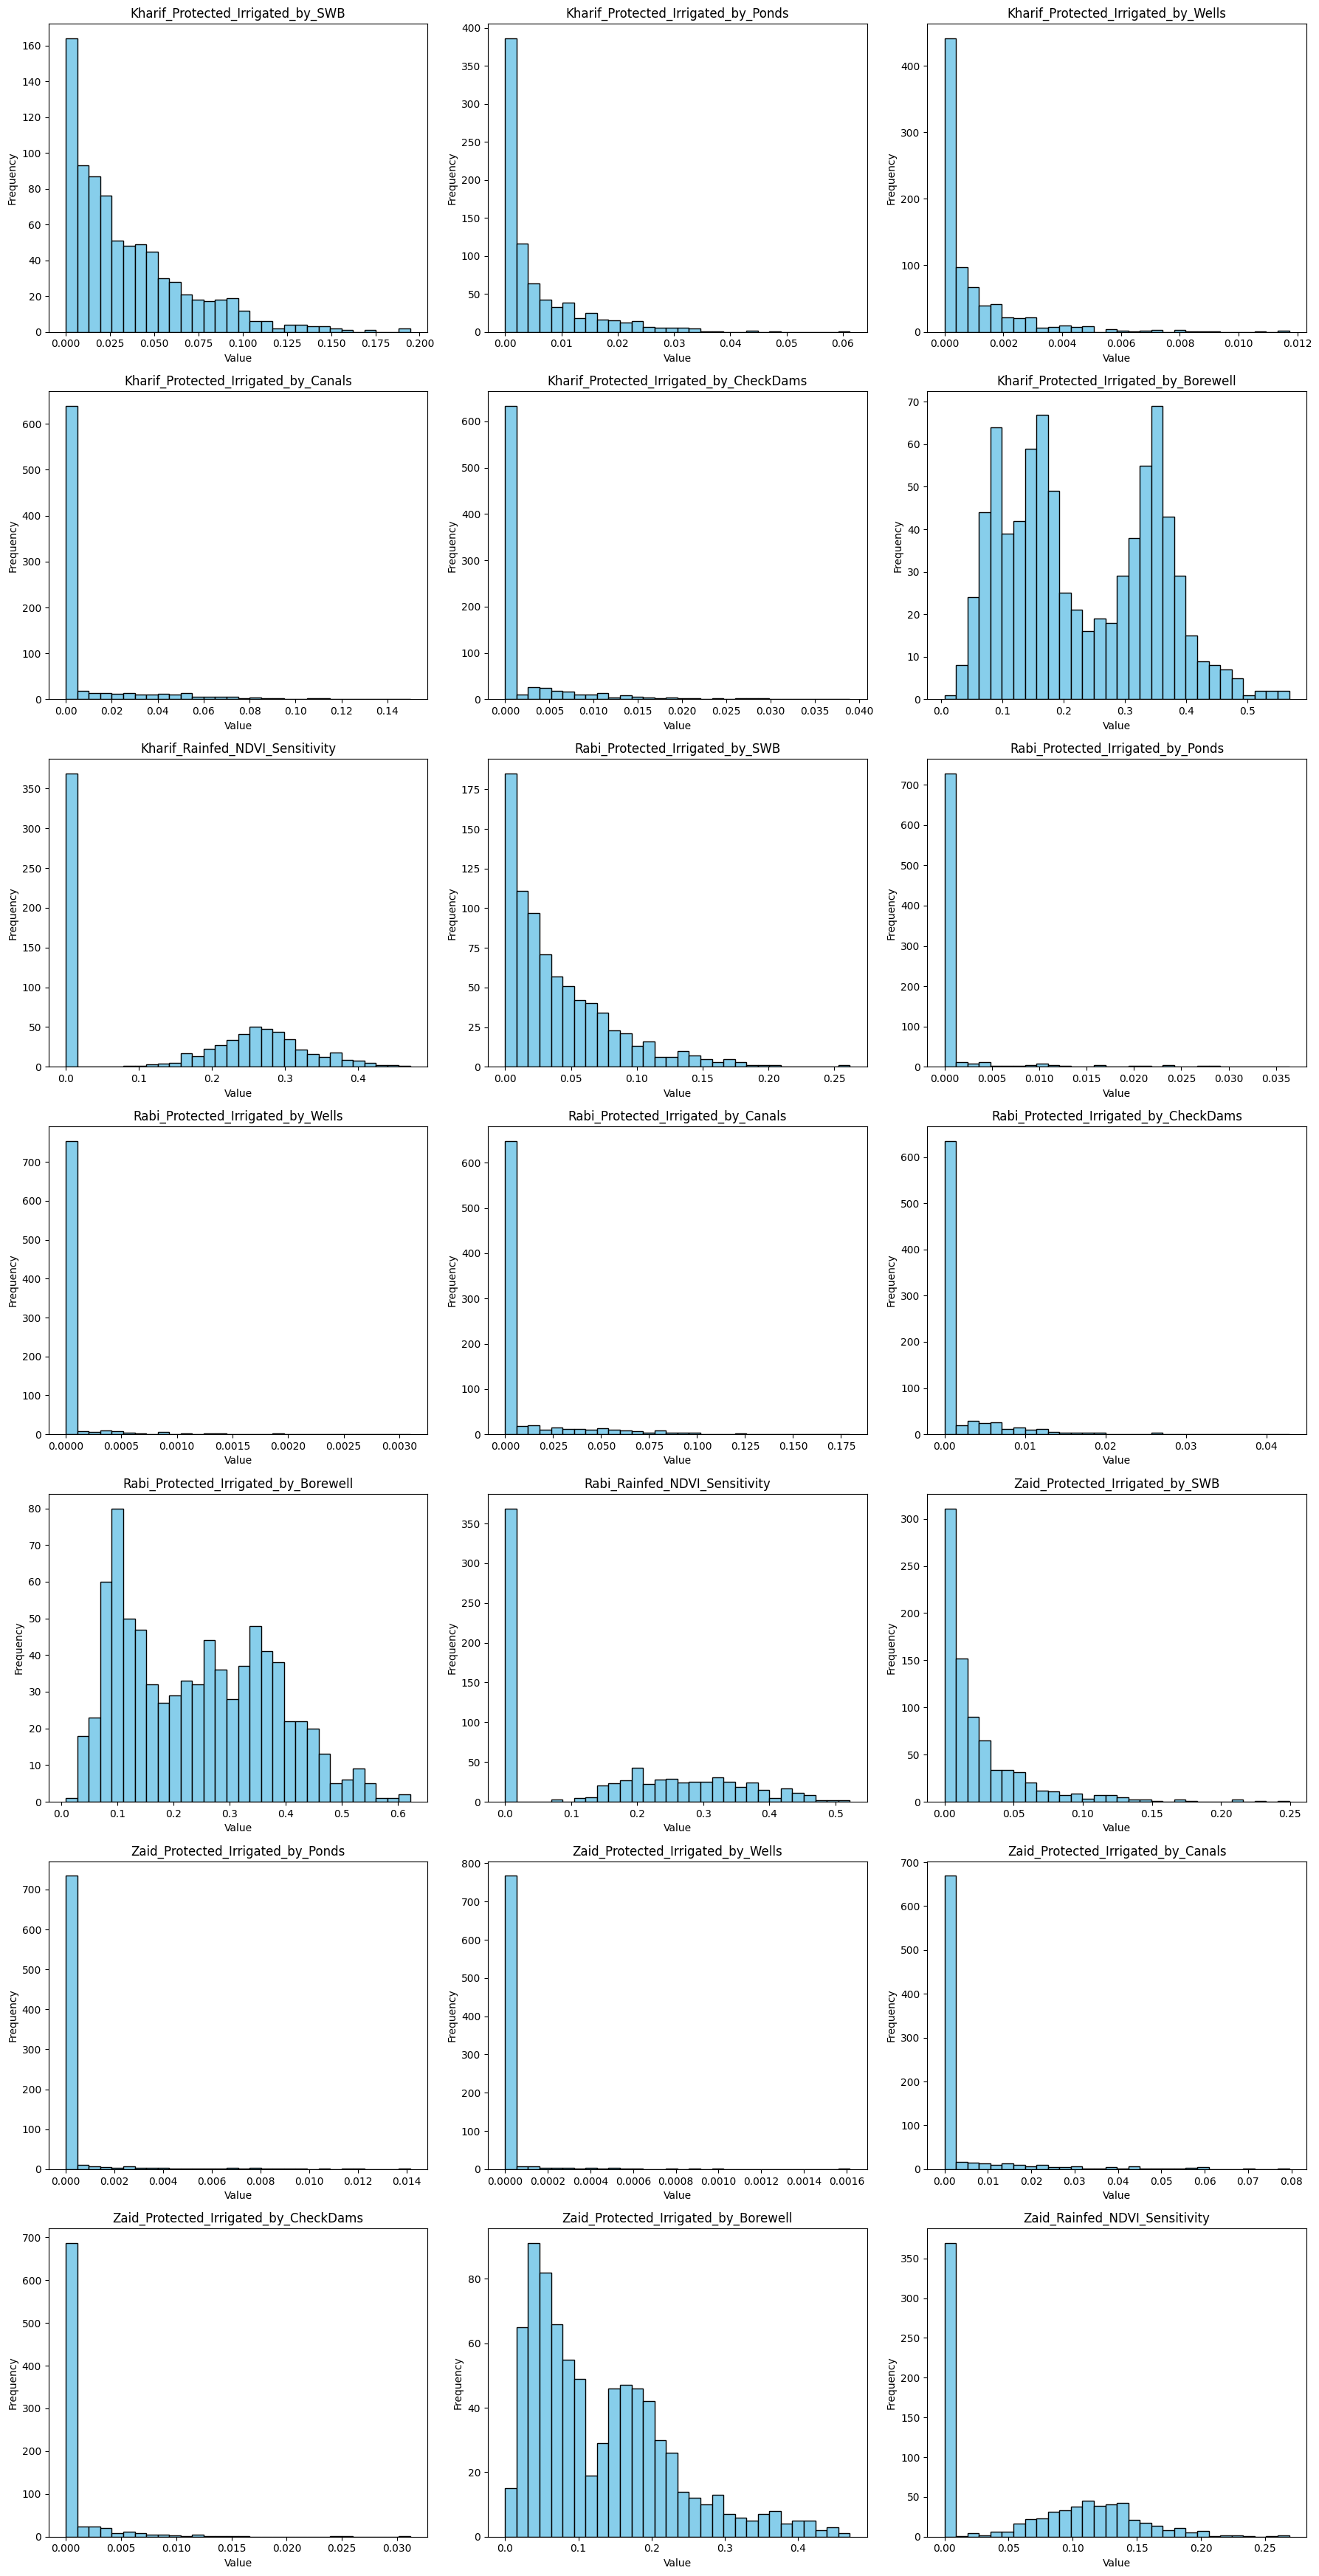

In [ ]:
# Drop non-numeric columns
numeric_df = df.drop(columns=['MSW_ID', 'Region'])

# Plot histograms
num_cols = numeric_df.shape[1]
nrows = (num_cols + 2) // 3  # 3 plots per row

fig, axes = plt.subplots(nrows=nrows, ncols=3, figsize=(18, 5 * nrows))
axes = axes.flatten()

for i, col in enumerate(numeric_df.columns):
    ax = axes[i]
    numeric_df[col].plot(kind='hist', bins=30, ax=ax, color='skyblue', edgecolor='black')
    ax.set_title(col)
    ax.set_xlabel("Value")
    ax.set_ylabel("Frequency")

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()


### Normalization

In [ ]:
pwd

'/content/drive/MyDrive/Equity_Aatif'

✅ Transformed data with only non-negative values saved to: 7.Merged_CSV_Normalized/Merged_Features_Normalized.csv


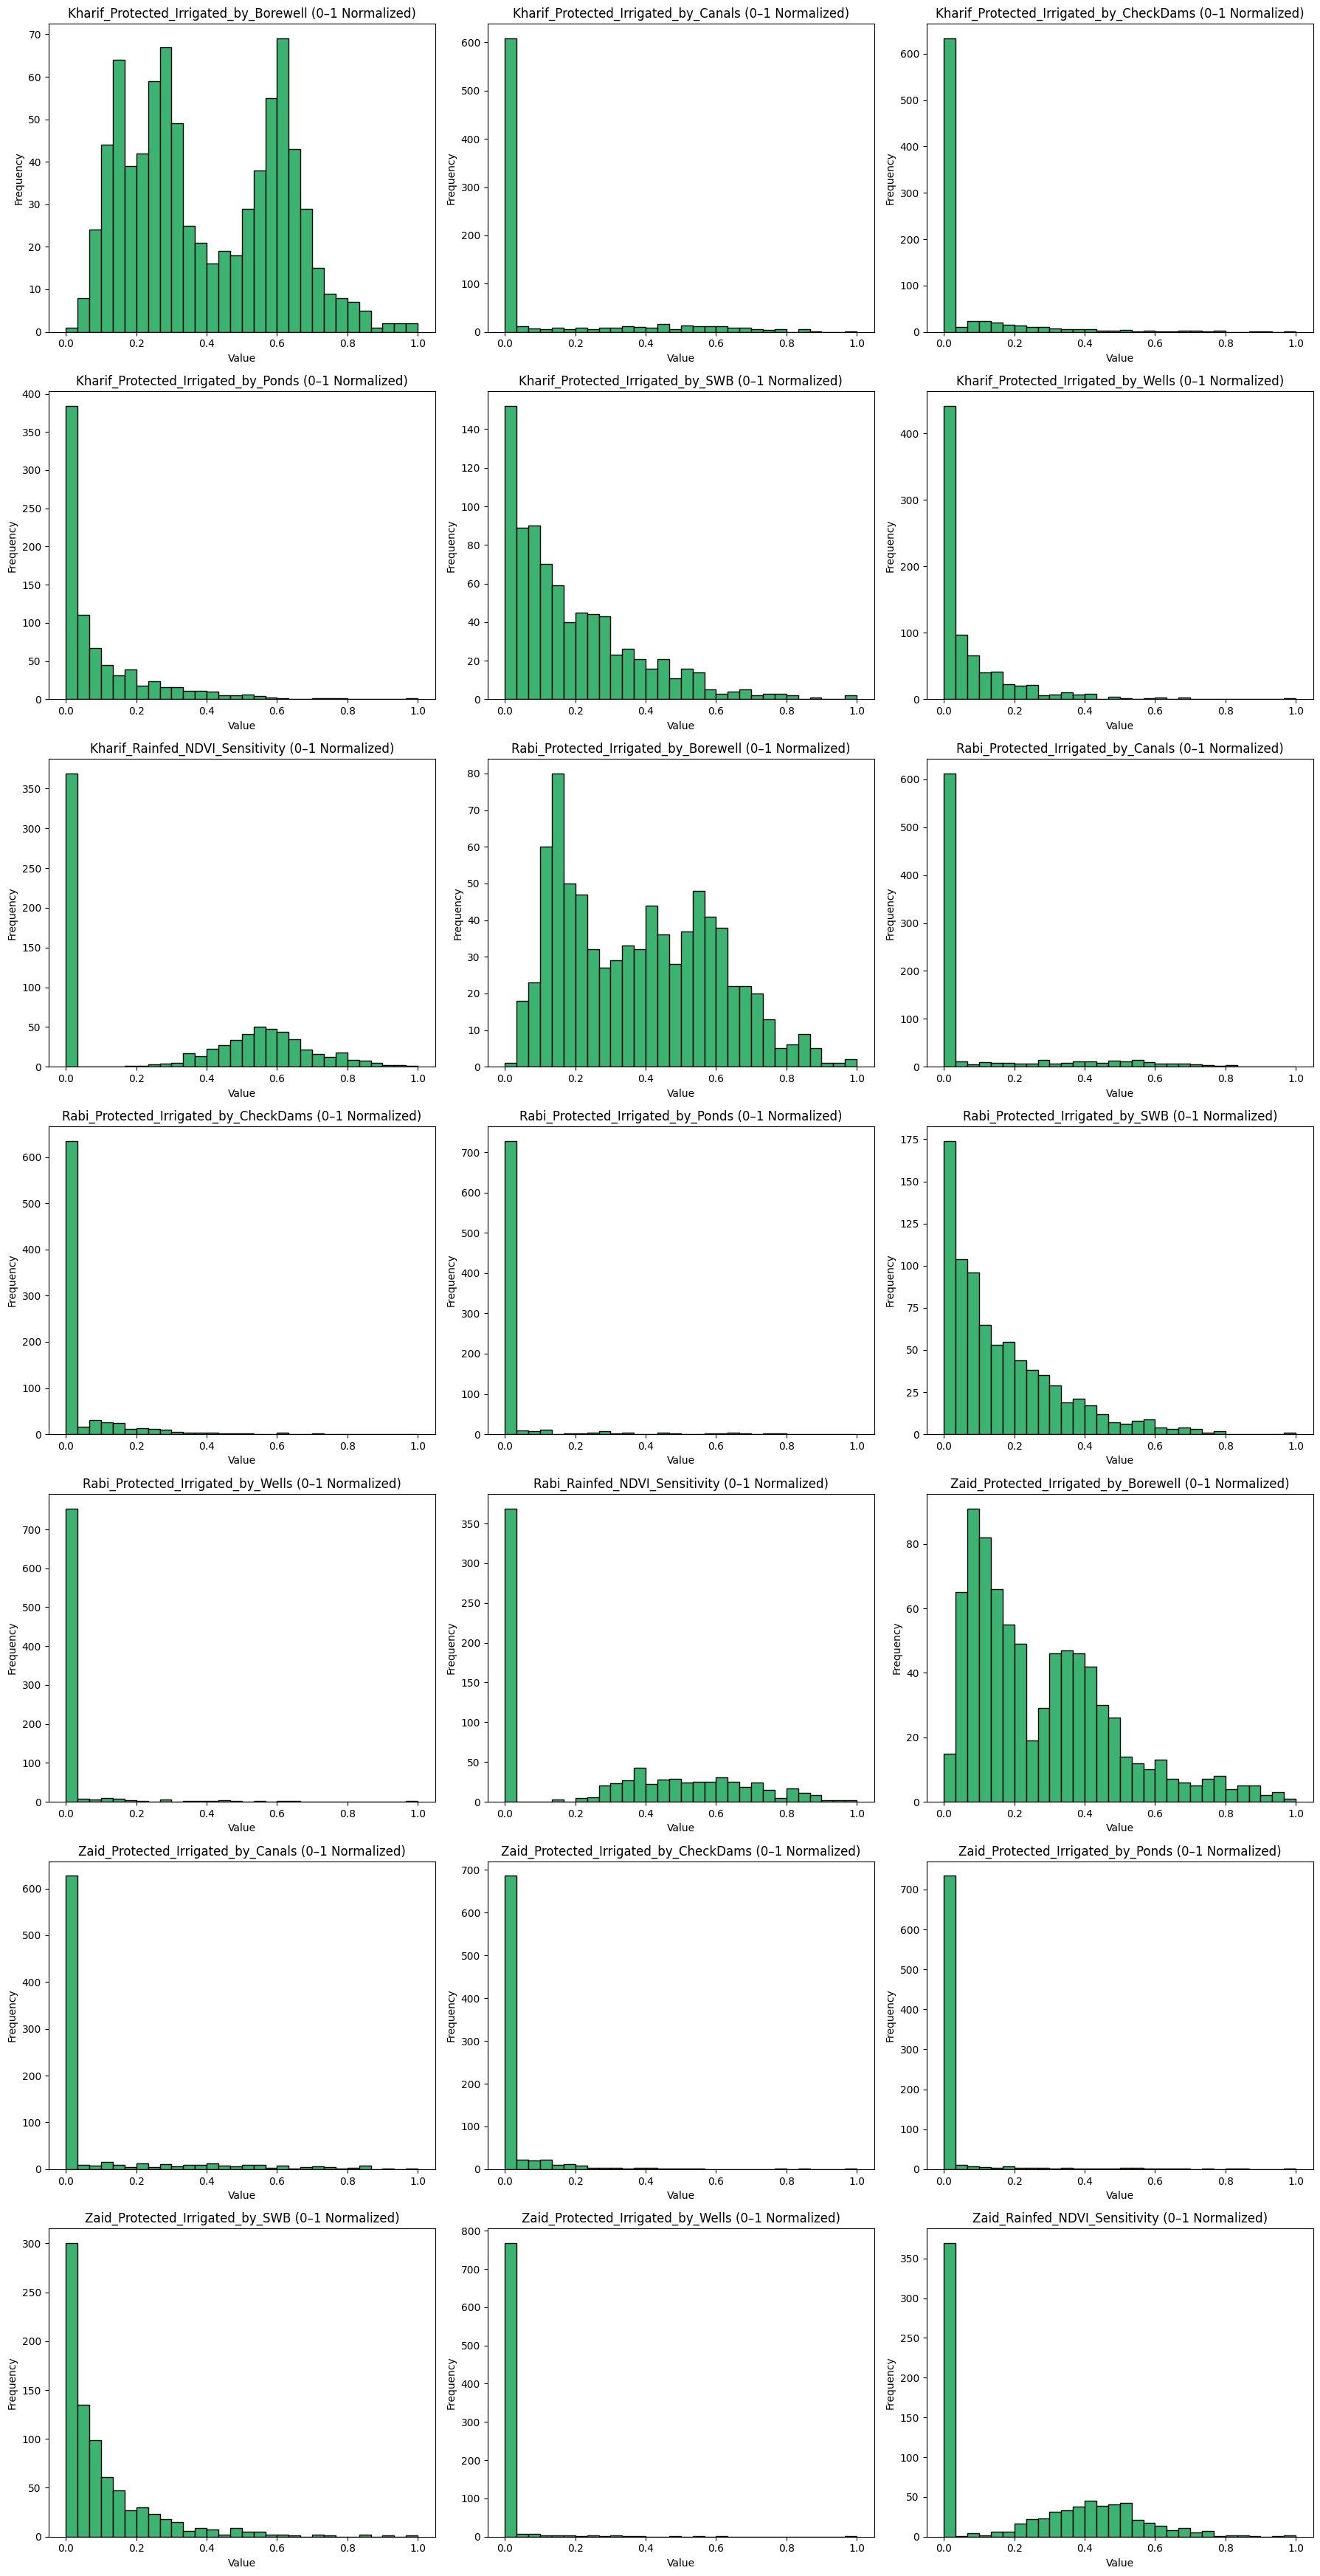

In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Load the data
path = '7.Merged_CSV/Merged_Features.csv'
df = pd.read_csv(path)

# Preserve IDs
df_transformed = pd.DataFrame()
df_transformed['MSW_ID'] = df['MSW_ID']
df_transformed['Region'] = df['Region']

# Feature groups
log_minmax = [
    'Kharif_Protected_Irrigated_by_SWB', 'Kharif_Protected_Irrigated_by_Ponds',
    'Kharif_Protected_Irrigated_by_Wells', 'Kharif_Protected_Irrigated_by_CheckDams',
    'Rabi_Protected_Irrigated_by_SWB', 'Rabi_Protected_Irrigated_by_Ponds',
    'Rabi_Protected_Irrigated_by_Wells', 'Rabi_Protected_Irrigated_by_CheckDams',
    'Zaid_Protected_Irrigated_by_SWB', 'Zaid_Protected_Irrigated_by_Ponds',
    'Zaid_Protected_Irrigated_by_Wells', 'Zaid_Protected_Irrigated_by_CheckDams'
]

sqrt_minmax = [
    'Kharif_Protected_Irrigated_by_Canals', 'Rabi_Protected_Irrigated_by_Canals',
    'Zaid_Protected_Irrigated_by_Canals'
]

minmax_scale = [
    'Kharif_Protected_Irrigated_by_Borewell',
    'Rabi_Protected_Irrigated_by_Borewell',
    'Zaid_Protected_Irrigated_by_Borewell'
]

ndvi_minmax = [
    'Kharif_Rainfed_NDVI_Sensitivity',
    'Rabi_Rainfed_NDVI_Sensitivity',
    'Zaid_Rainfed_NDVI_Sensitivity'
]

# Apply log + MinMax normalization
for col in log_minmax:
    log_vals = np.log1p(df[col])
    scaled = MinMaxScaler().fit_transform(log_vals.values.reshape(-1, 1)).flatten()
    df_transformed[col] = scaled

# Apply sqrt + MinMax normalization
for col in sqrt_minmax:
    sqrt_vals = np.sqrt(df[col])
    scaled = MinMaxScaler().fit_transform(sqrt_vals.values.reshape(-1, 1)).flatten()
    df_transformed[col] = scaled

# Apply MinMax directly
for col in minmax_scale + ndvi_minmax:
    scaled = MinMaxScaler().fit_transform(df[[col]]).flatten()
    df_transformed[col] = scaled

# Save to CSV
output_dir = '7.Merged_CSV_Normalized'
os.makedirs(output_dir, exist_ok=True)
output_path = os.path.join(output_dir, 'Merged_Features_Normalized.csv')
df_transformed.to_csv(output_path, index=False)
print(f"✅ Transformed data with only non-negative values saved to: {output_path}")

# Plot histograms of transformed features
plot_cols = df_transformed.columns.difference(['MSW_ID', 'Region'])
num_cols = len(plot_cols)
nrows = (num_cols + 2) // 3

fig, axes = plt.subplots(nrows=nrows, ncols=3, figsize=(18, 5 * nrows))
axes = axes.flatten()

for i, col in enumerate(plot_cols):
    ax = axes[i]
    df_transformed[col].plot(kind='hist', bins=30, ax=ax, color='mediumseagreen', edgecolor='black')
    ax.set_title(f"{col} (0–1 Normalized)")
    ax.set_xlabel("Value")
    ax.set_ylabel("Frequency")

for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()


In [ ]:
# # Load data
# path = '7.Merged_CSV/Merged_Features.csv'
# df = pd.read_csv(path)

In [ ]:
# # Save output
# output_dir = '7.Merged_CSV_NORMALIZED'
# os.makedirs(output_dir, exist_ok=True)
# output_path = os.path.join(output_dir, 'Merged_Features_NORMALIZED.csv')

In [ ]:
#df.columns

In [ ]:
# # Columns to normalize
# log_cols = [
#     'Kharif_Protected_Irrigated_by_SWB',
#     'Kharif_Protected_Irrigated_by_Ponds',
#     'Kharif_Protected_Irrigated_by_Wells',
#     'Kharif_Protected_Irrigated_by_Canals',
#     'Kharif_Protected_Irrigated_by_CheckDams',
#     'Kharif_Rainfed_NDVI_Sensitivity'
# ]

# minmax_cols = ['Kharif_Protected_Irrigated_by_Borewell']

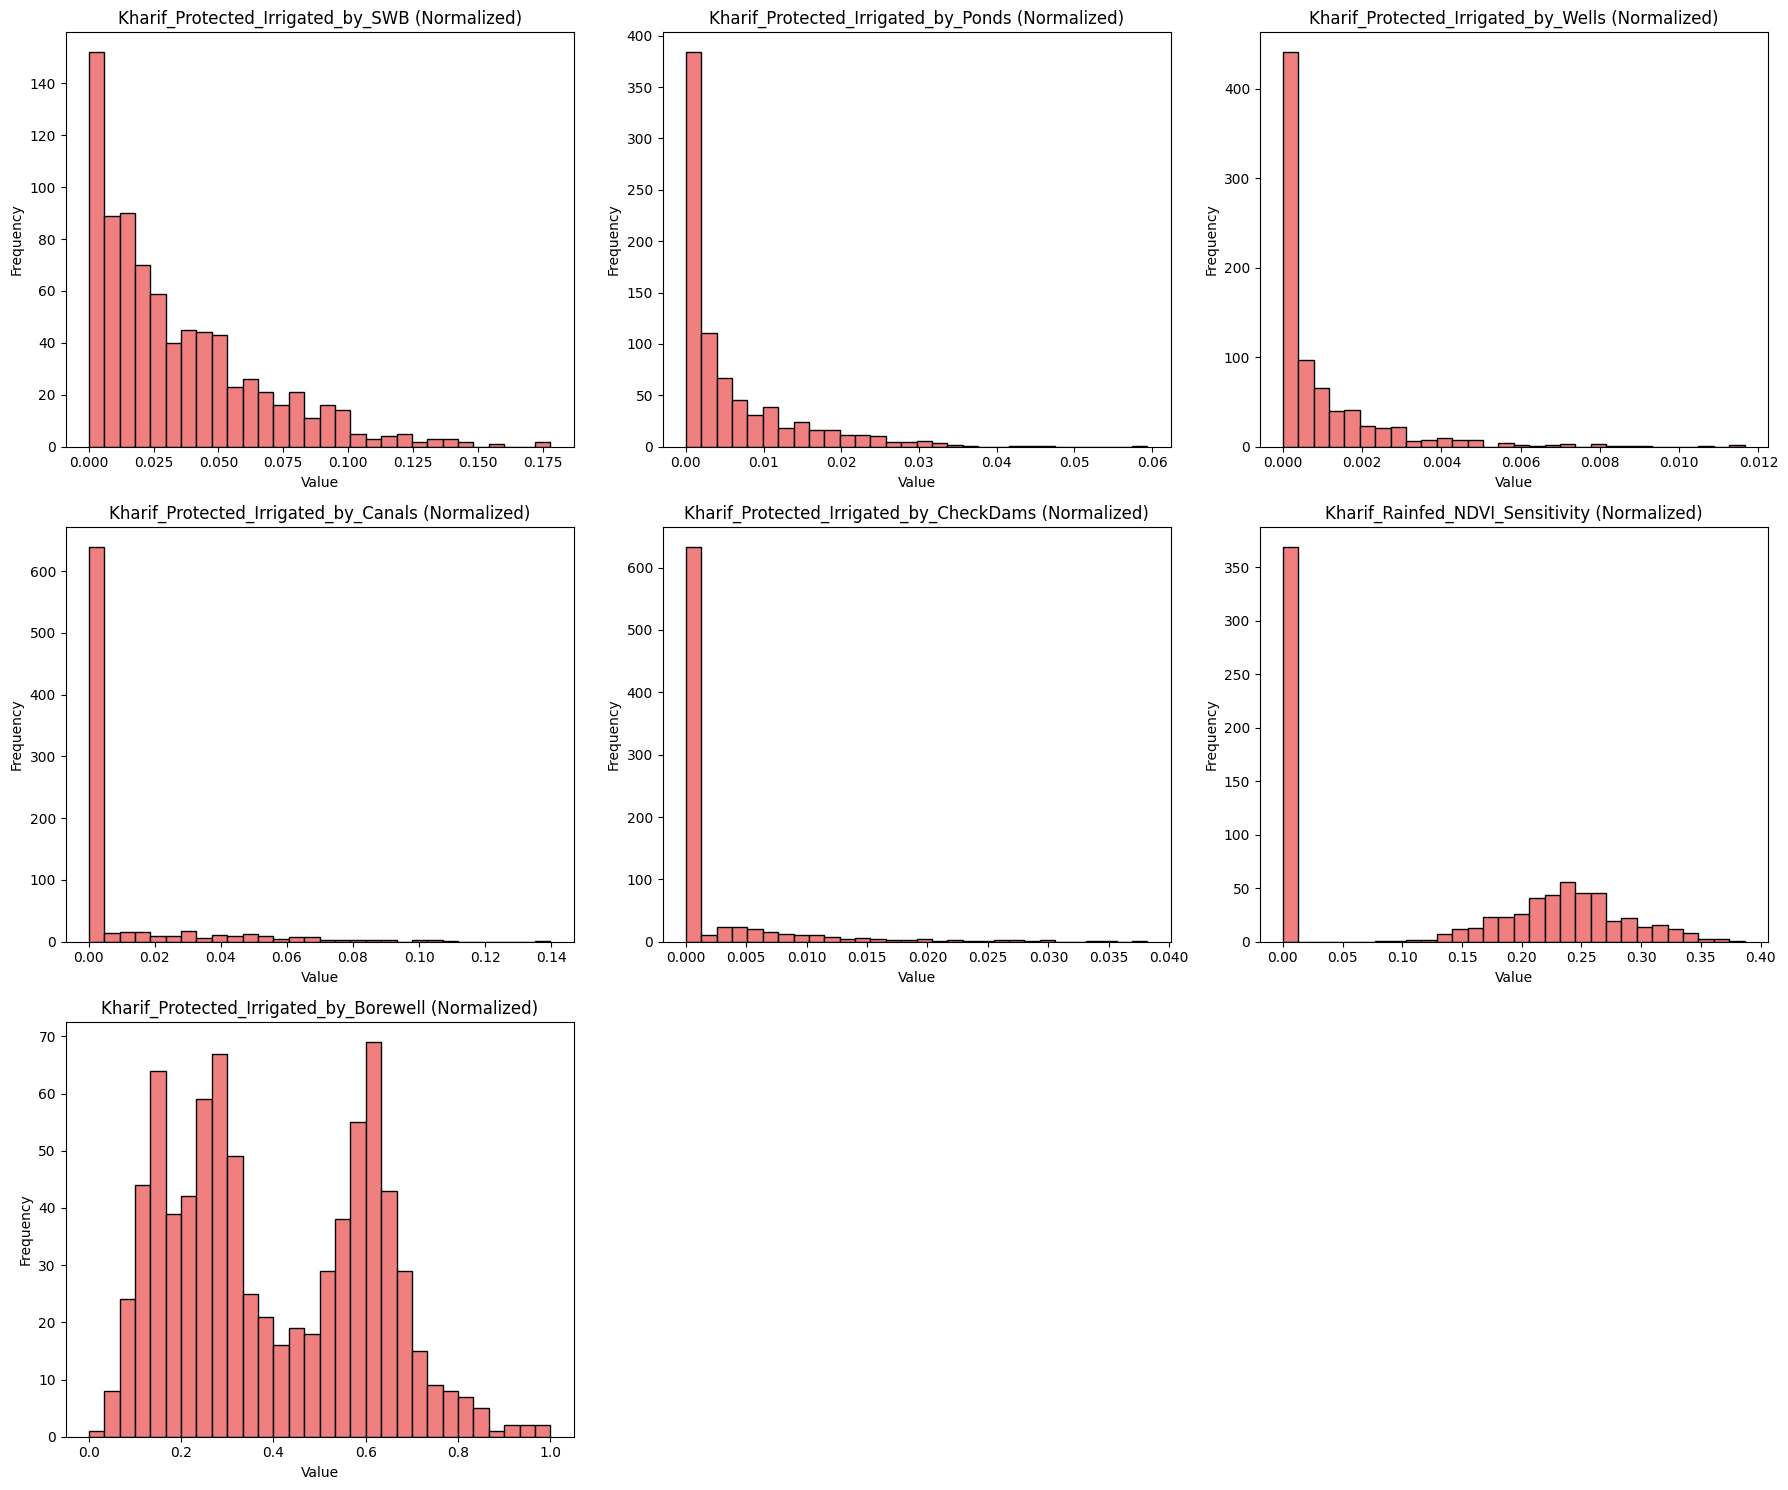

In [ ]:
# # Copy to preserve original
# df_norm = pd.DataFrame()
# df_norm['MSW_ID'] = df['MSW_ID']
# df_norm['Region'] = df['Region']

# # Log normalize selected columns (add small epsilon to avoid log(0))
# epsilon = 1e-6
# for col in log_cols:
#     df_norm[col] = np.log1p(df[col])  # log1p(x) = log(1 + x)

# # Min-max normalize Borewell
# for col in minmax_cols:
#     col_min = df[col].min()
#     col_max = df[col].max()
#     df_norm[col] = (df[col] - col_min) / (col_max - col_min)


# df_norm.to_csv(output_path, index=False)

# # Plotting histograms
# plot_cols = log_cols + minmax_cols
# num_cols = len(plot_cols)
# nrows = (num_cols + 2) // 3  # 3 per row

# fig, axes = plt.subplots(nrows=nrows, ncols=3, figsize=(18, 5 * nrows))
# axes = axes.flatten()

# for i, col in enumerate(plot_cols):
#     ax = axes[i]
#     df_norm[col].plot(kind='hist', bins=30, ax=ax, color='lightcoral', edgecolor='black')
#     ax.set_title(f"{col} (Normalized)")
#     ax.set_xlabel("Value")
#     ax.set_ylabel("Frequency")

# # Hide unused axes
# for j in range(i + 1, len(axes)):
#     axes[j].set_visible(False)

# plt.tight_layout()
# plt.show()

# Elbow Curve

In [ ]:
pwd

'/content/drive/MyDrive/Equity_Aatif'

In [ ]:
# File paths
input_csv_path = '7.Merged_CSV_Normalized/Merged_Features_Normalized.csv'

# Load data
df = pd.read_csv(input_csv_path)

# Drop non-feature columns
features = df.drop(columns=['MSW_ID', 'Region'])


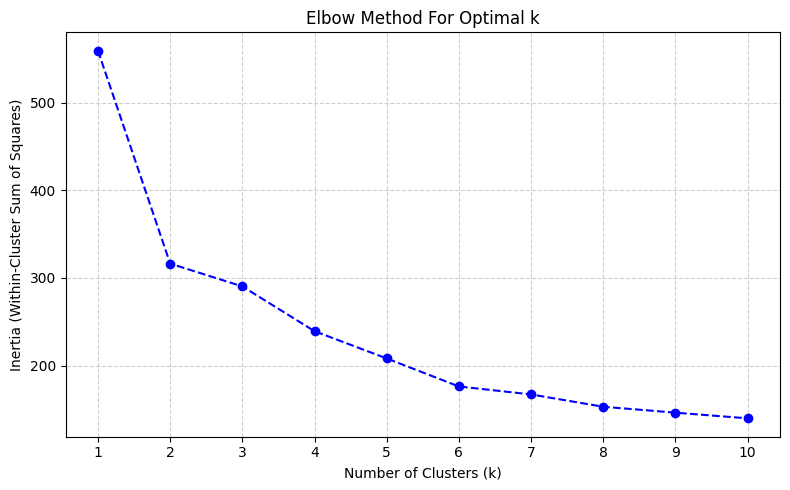

In [ ]:
# ---------- Elbow Curve Plot ----------
inertia_values = []
k_range = range(1, 11)  # Test k from 1 to 10

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features)
    inertia_values.append(kmeans.inertia_)

# Plot elbow curve
plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia_values, marker='o', linestyle='--', color='blue')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (Within-Cluster Sum of Squares)')
plt.title('Elbow Method For Optimal k')
plt.xticks(k_range)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()
# ---------- End Elbow Plot ----------

# DONE: K Means Clustering

In [ ]:
pwd

'/content/drive/MyDrive/Equity_Aatif'

In [ ]:
# File paths using the region name
input_csv_path = '7.Merged_CSV_Normalized/Merged_Features_Normalized.csv'
output_csv_path = '8.Clustered_CSV/Clusteres_Merged_Features.csv'
os.makedirs(os.path.dirname(output_csv_path), exist_ok=True)

In [ ]:
# Load the CSV
df = pd.read_csv(input_csv_path)

In [ ]:
# Check for NA values
print("Total NA values before removal:")
print(df.isna().sum())

# Remove rows with ANY NA values
df_cleaned = df.dropna()
print(f"\nRemoved {len(df) - len(df_cleaned)} rows with NA values.")

Total NA values before removal:
MSW_ID                                     0
Region                                     0
Kharif_Protected_Irrigated_by_SWB          0
Kharif_Protected_Irrigated_by_Ponds        0
Kharif_Protected_Irrigated_by_Wells        0
Kharif_Protected_Irrigated_by_CheckDams    0
Rabi_Protected_Irrigated_by_SWB            0
Rabi_Protected_Irrigated_by_Ponds          0
Rabi_Protected_Irrigated_by_Wells          0
Rabi_Protected_Irrigated_by_CheckDams      0
Zaid_Protected_Irrigated_by_SWB            0
Zaid_Protected_Irrigated_by_Ponds          0
Zaid_Protected_Irrigated_by_Wells          0
Zaid_Protected_Irrigated_by_CheckDams      0
Kharif_Protected_Irrigated_by_Canals       0
Rabi_Protected_Irrigated_by_Canals         0
Zaid_Protected_Irrigated_by_Canals         0
Kharif_Protected_Irrigated_by_Borewell     0
Rabi_Protected_Irrigated_by_Borewell       0
Zaid_Protected_Irrigated_by_Borewell       0
Kharif_Rainfed_NDVI_Sensitivity            0
Rabi_Rainfed_NDVI_Sensi

In [ ]:
# Drop non-feature columns (MSW_ID and Region) for clustering
features = df_cleaned.drop(columns=['MSW_ID', 'Region'])

# Perform K-Means clustering
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
df_cleaned['Cluster'] = kmeans.fit_predict(features)

# Save the result with the cluster assignments
df_cleaned.to_csv(output_csv_path, index=False)

print(f"Clustered data saved to {output_csv_path}")

Clustered data saved to 8.Clustered_CSV/Clusteres_Merged_Features.csv


# DONE: Plot clusters

In [ ]:
pwd

'/content/drive/MyDrive/Equity_Aatif'

In [ ]:
# Load the clustered CSV
df_clusters = pd.read_csv(f'8.Clustered_CSV/Clusteres_Merged_Features.csv')

In [ ]:
# Clean region names by removing '.csv' if present
df_clusters['Region'] = df_clusters['Region'].str.replace('.csv', '', regex=False)

In [ ]:
# Define shapefile regions
regions = ['Mandalgarh', 'Masalia', 'Purunakot', 'Sawali',
         'Rajnagar', 'Lakshmipur', 'Pindwara', 'Boipariguda', 'Devadurga']

shapefiles = [
    f'1.Entire_Data/MicroWaterSheds/{region}_mws/{region.lower()}_shapefile.shp'
    for region in regions
]

Skipping region 'Purunakot' - no cluster data available.


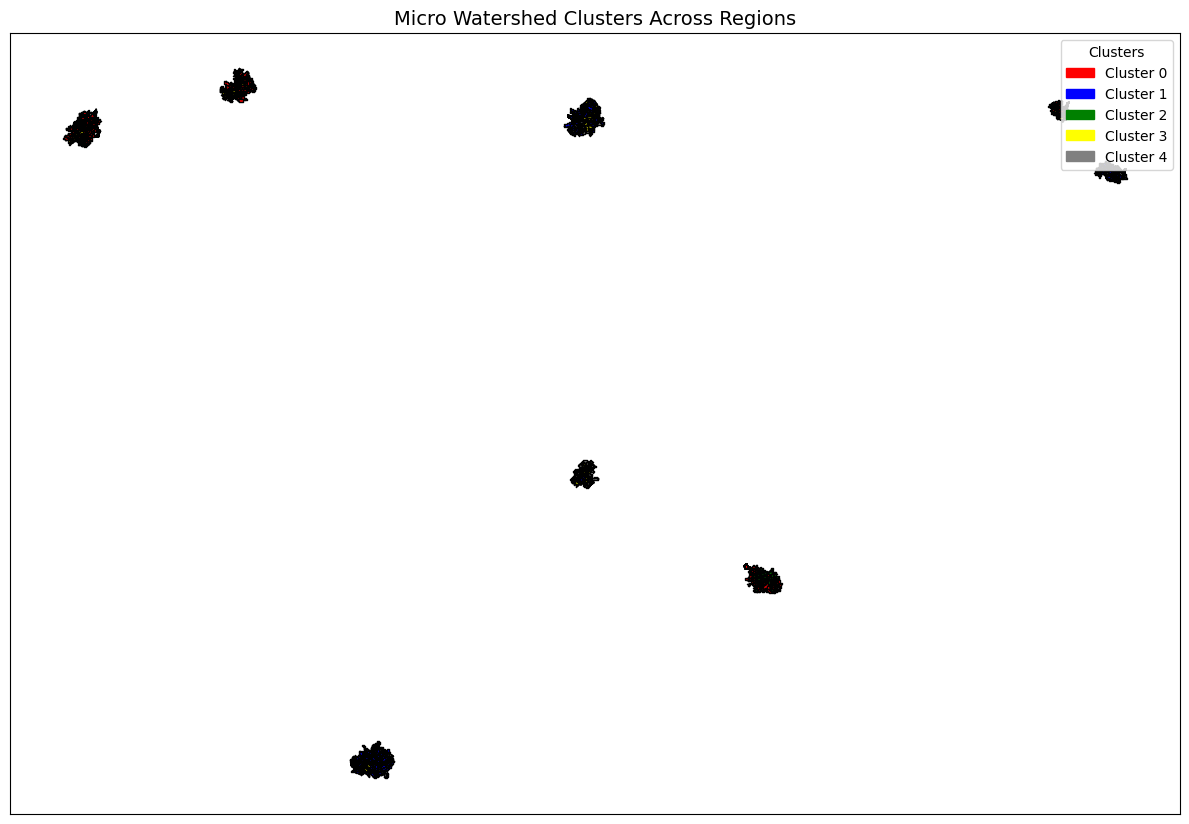

In [ ]:
# Define cluster colors
#cluster_colors = {0: "red", 1: "blue", 2: "green"}
cluster_colors = {0: "red", 1: "blue", 2: "green", 3: "yellow", 4: "grey"}
#cluster_colors = {0: "red", 1: "blue"}
# Create a figure
fig, ax = plt.subplots(figsize=(12, 10))

# Loop over detected regions and shapefiles
for region, shp in zip(regions, shapefiles):
    gdf = gpd.read_file(shp)
    gdf.rename(columns={'uid': 'MSW_ID'}, inplace=True)

    # Filter cluster data by region
    region_df = df_clusters[df_clusters['Region'] == region]

    if region_df.empty:
        print(f"Skipping region '{region}' - no cluster data available.")
        continue

    # Merge and assign color
    gdf = gdf.merge(region_df, on="MSW_ID", how="inner")
    gdf["color"] = gdf["Cluster"].map(cluster_colors)

    # Plot
    gdf.plot(color=gdf["color"], ax=ax, edgecolor="black")

# Create legend
legend_patches = [mpatches.Patch(color=color, label=f'Cluster {i}') for i, color in cluster_colors.items()]
ax.legend(handles=legend_patches, title="Clusters", loc="upper right")

# Formatting
ax.set_title("Micro Watershed Clusters Across Regions", fontsize=14)
ax.set_xticks([])
ax.set_yticks([])

plt.tight_layout()
plt.show()

# DONE: Overall Plot distribution

In [ ]:
pwd

'/content/drive/MyDrive/Equity_Aatif'

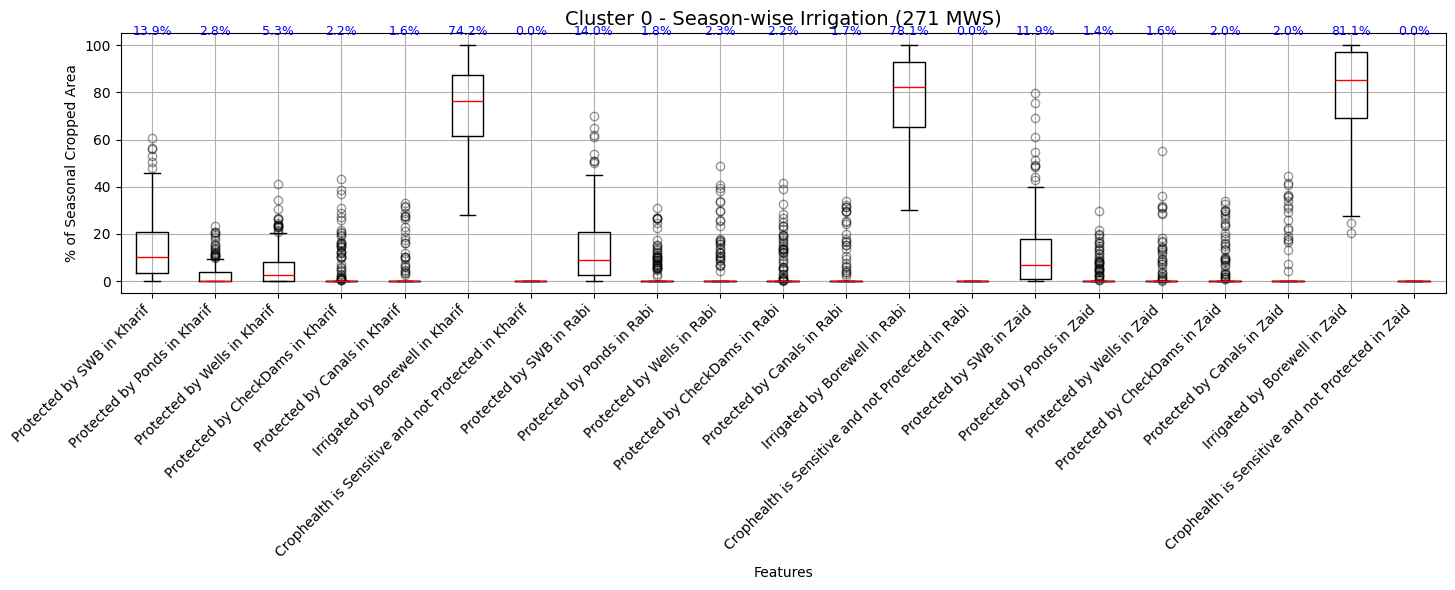

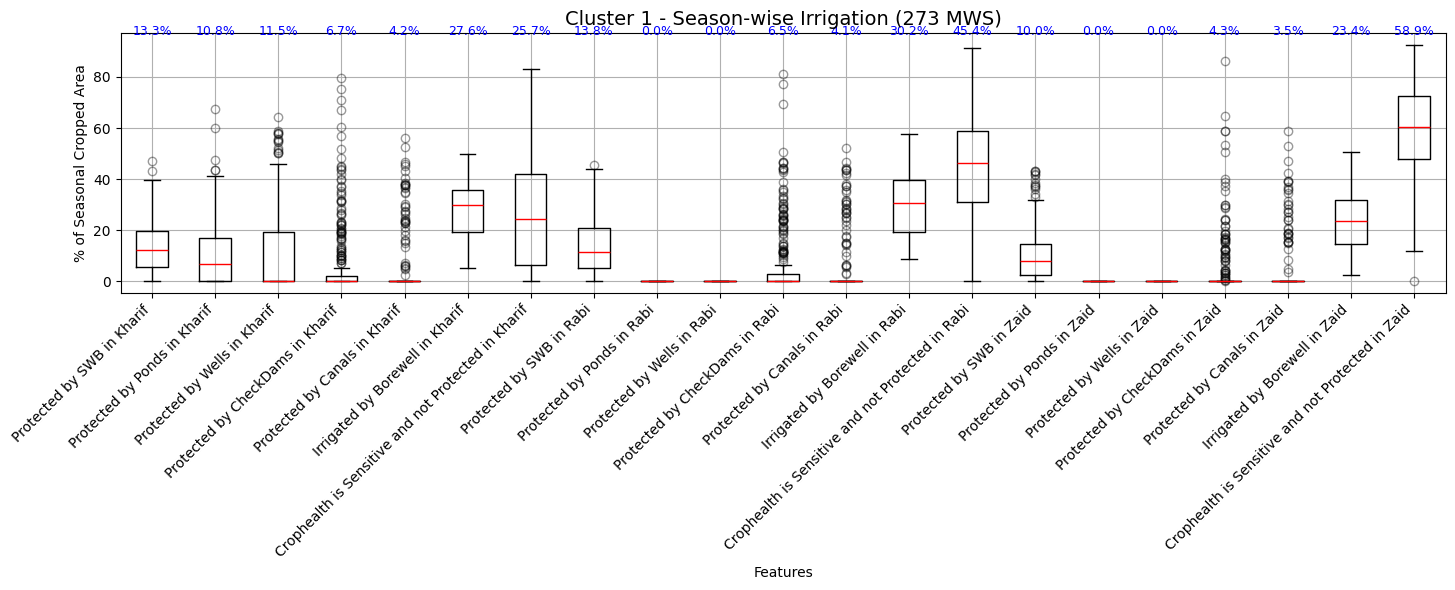

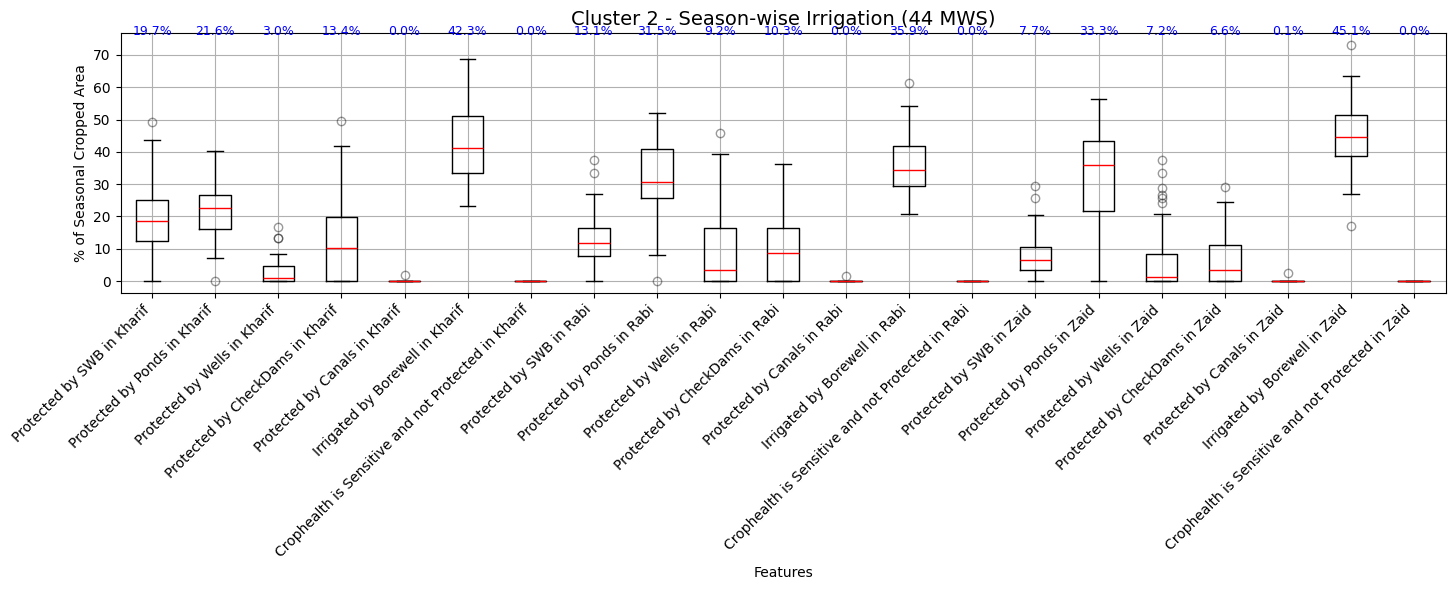

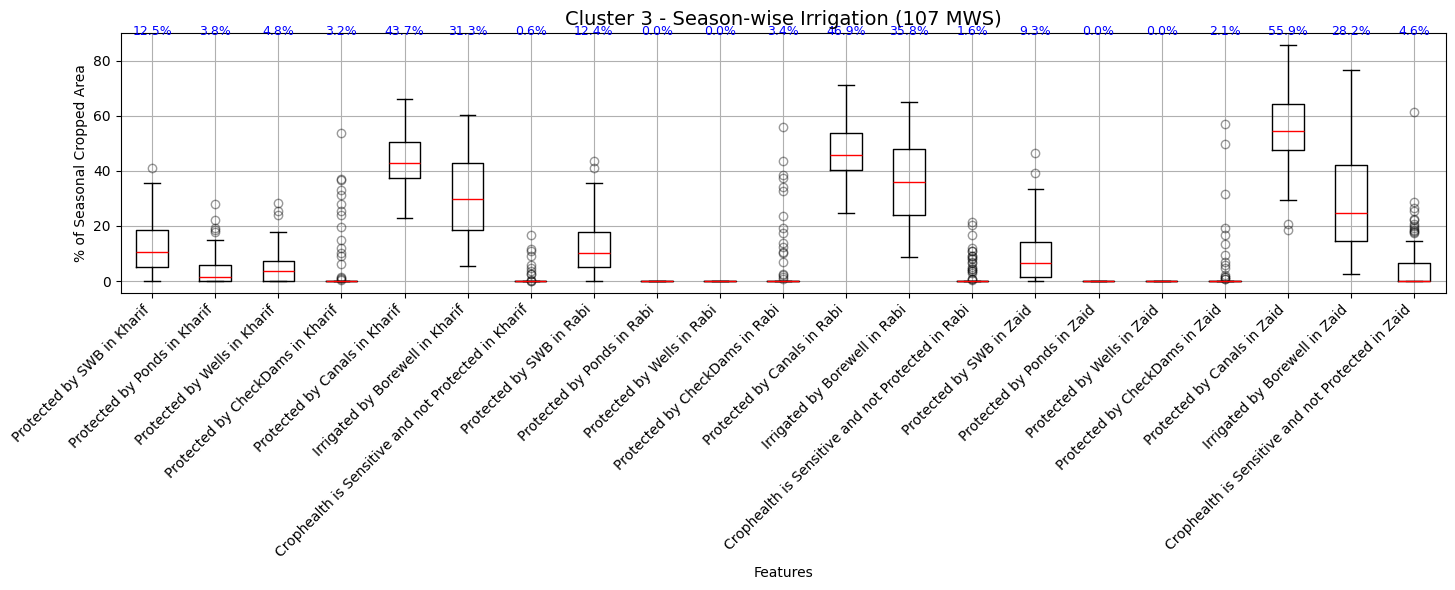

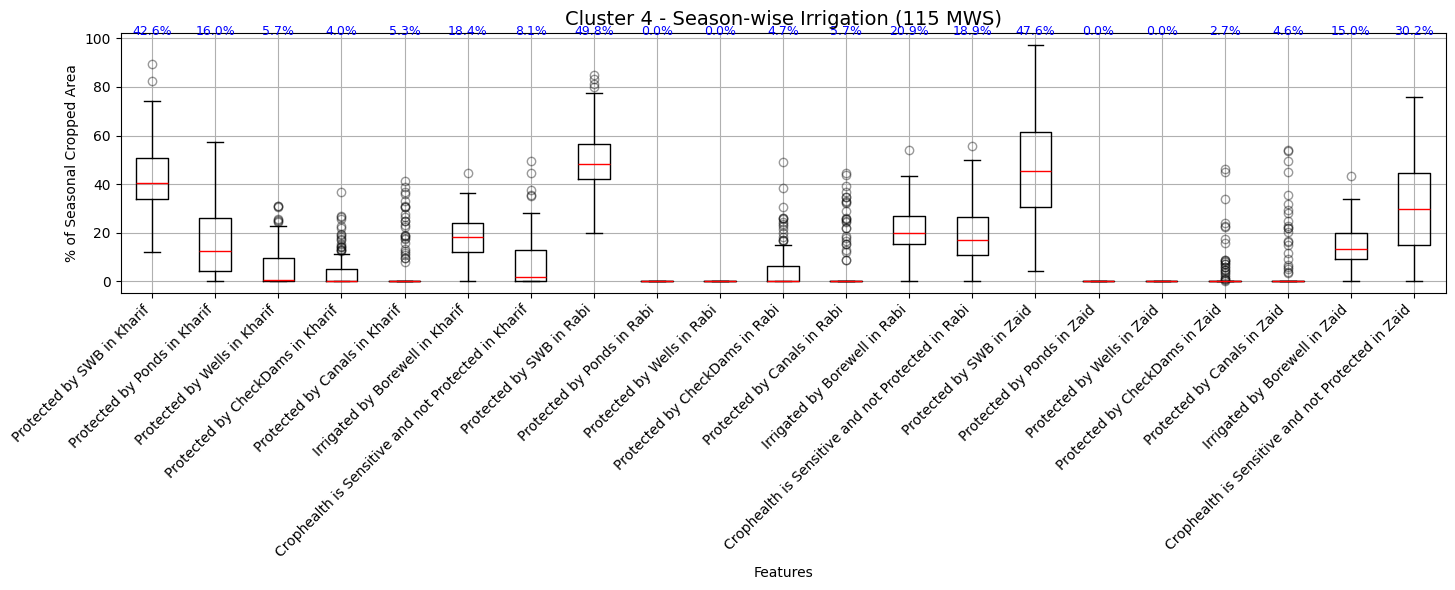

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load data
df_clusters = pd.read_csv('8.Clustered_CSV/Clusteres_Merged_Features.csv')
df_clusters['Region'] = df_clusters['Region'].str.replace('.csv', '', regex=False)

# Filter for selected regions
df_combined = df_clusters[df_clusters['Region'].isin([
    'Mandalgarh', 'Masalia', 'Purunakot', 'Sawali',
    'Rajnagar', 'Lakshmipur', 'Pindwara', 'Boipariguda', 'Devadurga'
])]

# Copy to work on
df_norm = df_combined.copy()

# Define seasons
seasons = ['Kharif', 'Rabi', 'Zaid']

# Irrigation sources to include
irrigation_sources = [
    'Protected_Irrigated_by_SWB',
    'Protected_Irrigated_by_Ponds',
    'Protected_Irrigated_by_Wells',
    'Protected_Irrigated_by_CheckDams',
    'Protected_Irrigated_by_Canals',
    'Protected_Irrigated_by_Borewell'
]

# Process season-wise
for season in seasons:
    irrig_cols = [f"{season}_{src}" for src in irrigation_sources]
    ndvi_col = f"{season}_Rainfed_NDVI_Sensitivity"
    rainfed_col = f"{season}_Rainfed_Sensitive"

    # Total irrigated area
    irrig_total = df_norm[irrig_cols].sum(axis=1)

    # Clip irrigated total to max 1
    irrig_total_clipped = irrig_total.clip(upper=1.0)

    # Rainfed = remaining area × NDVI sensitivity
    rainfed_area = (1.0 - irrig_total_clipped).clip(lower=0)
    df_norm[rainfed_col] = rainfed_area * df_norm[ndvi_col]

    # Combine columns and compute season sum
    season_all_cols = irrig_cols + [rainfed_col]
    season_sum = df_norm[season_all_cols].sum(axis=1)

    # Normalize all components to 100%
    df_norm[season_all_cols] = df_norm[season_all_cols].div(season_sum, axis=0) * 100


# Prepare final plot columns
plot_columns = []
for season in seasons:
    plot_columns.extend([f"{season}_{src}" for src in irrigation_sources])
    plot_columns.append(f"{season}_Rainfed_Sensitive")

# Drop non-feature columns
exclude_cols = {'MSW_ID', 'Region', 'Cluster'}

# Label mapping function
def get_friendly_label(col):
    if 'Rainfed_Sensitive' in col:
        season = col.split('_')[0]
        return f"Crophealth is Sensitive and not Protected in {season}"
    elif 'Protected_Irrigated_by' in col:
        parts = col.split('_')
        season = parts[0]
        source = '_'.join(parts[3:])
        source = source.replace('by_', '')  # ✅ remove redundant "by_"
        if source == 'Borewell':
            return f"Irrigated by Borewell in {season}"
        return f"Protected by {source} in {season}"
    else:
        return col


# Plot per cluster
for cluster in sorted(df_norm['Cluster'].unique()):
    subset = df_norm[df_norm['Cluster'] == cluster]
    cluster_size = len(subset)
    mean_vals = subset[plot_columns].mean()

    fig, ax = plt.subplots(figsize=(max(12, len(plot_columns) * 0.7), 6))

    # Boxplot
    subset[plot_columns].boxplot(ax=ax,
        boxprops=dict(color='black'),
        whiskerprops=dict(color='black'),
        capprops=dict(color='black'),
        medianprops=dict(color='red'),
        flierprops=dict(marker='o', color='gray', alpha=0.4)
    )

    ax.set_title(f'Cluster {cluster} - Season-wise Irrigation ({cluster_size} MWS)', fontsize=14)
    ax.set_xlabel('Features')
    ax.set_ylabel('% of Seasonal Cropped Area')

    # Replace x-tick labels
    friendly_labels = [get_friendly_label(col) for col in plot_columns]
    ax.set_xticklabels(friendly_labels, rotation=45, ha='right')

    # Annotate mean % above each box
    ylim_top = ax.get_ylim()[1]
    for i, col in enumerate(plot_columns, start=1):
        ax.text(i, ylim_top * 0.98, f'{mean_vals[col]:.1f}%', ha='center', va='bottom', fontsize=9, color='blue')

    plt.tight_layout()
    plt.show()



# DONE: Region Wise Plot distribution

In [ ]:
pwd

'/content/drive/MyDrive/Equity_Aatif'

In [ ]:
# Pick the region
region = 'Mandalgarh'  # Change to 'Mohanpur' for the other region

In [ ]:
# Fixed cluster-to-color mapping (extend as needed)
cluster_colors_global = {
    0: 'red',
    1: 'blue',
    2: 'green',
    3: 'orange',
    4: 'purple',
    5: 'cyan',
    6: 'brown',
    7: 'magenta',
    8: 'yellow',
    9: 'gray'
}


In [ ]:
def get_friendly_label(col):
    if 'Rainfed_Sensitive' in col:
        season = col.split('_')[0]
        return f"Crophealth is Sensitive and not Protected in {season}"
    elif 'Protected_Irrigated_by' in col:
        parts = col.split('_')
        season = parts[0]
        source = '_'.join(parts[3:])
        source = source.replace('by_', '')  # Clean up 'by_'
        if source == 'Borewell':
            return f"Irrigated by Borewell in {season}"
        return f"Protected by {source} in {season}"
    else:
        return col

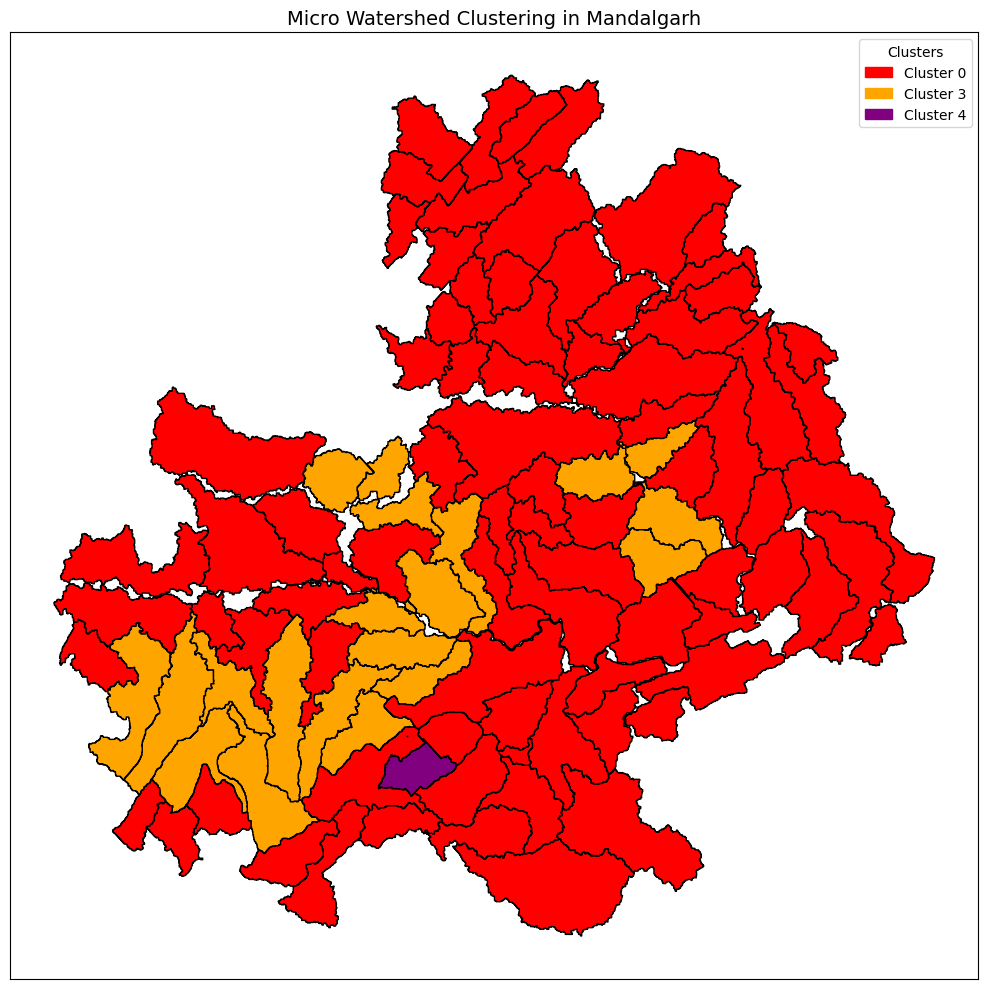

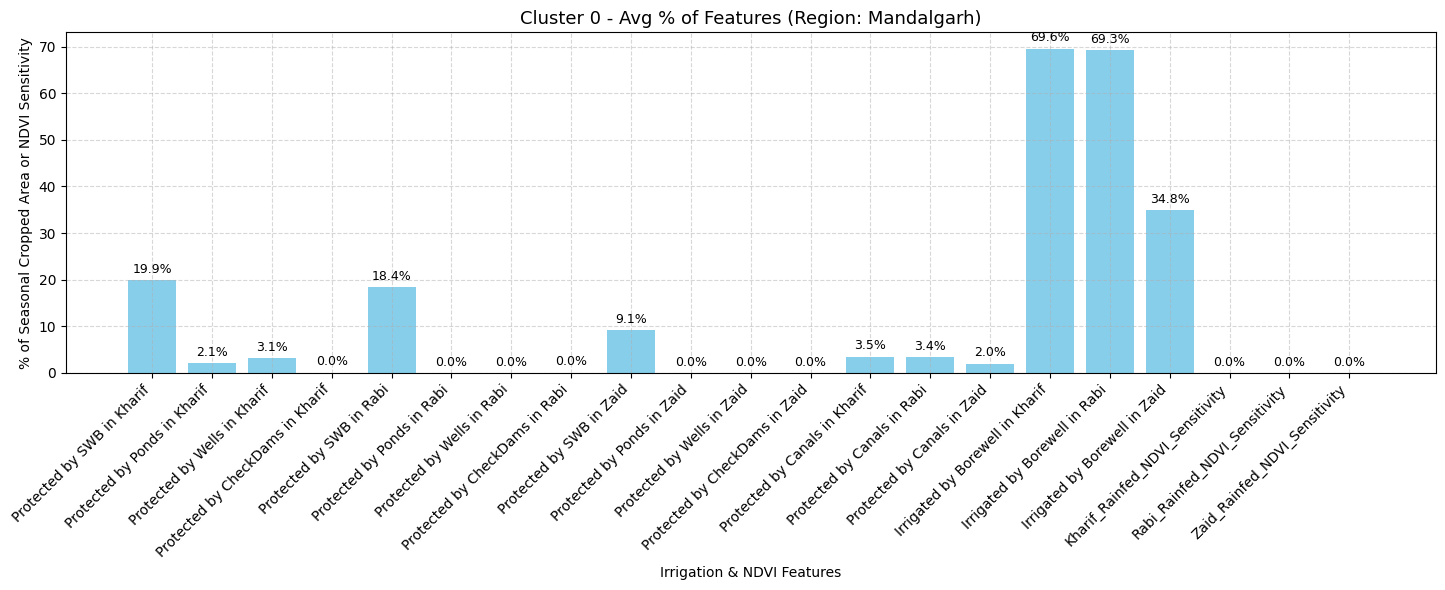

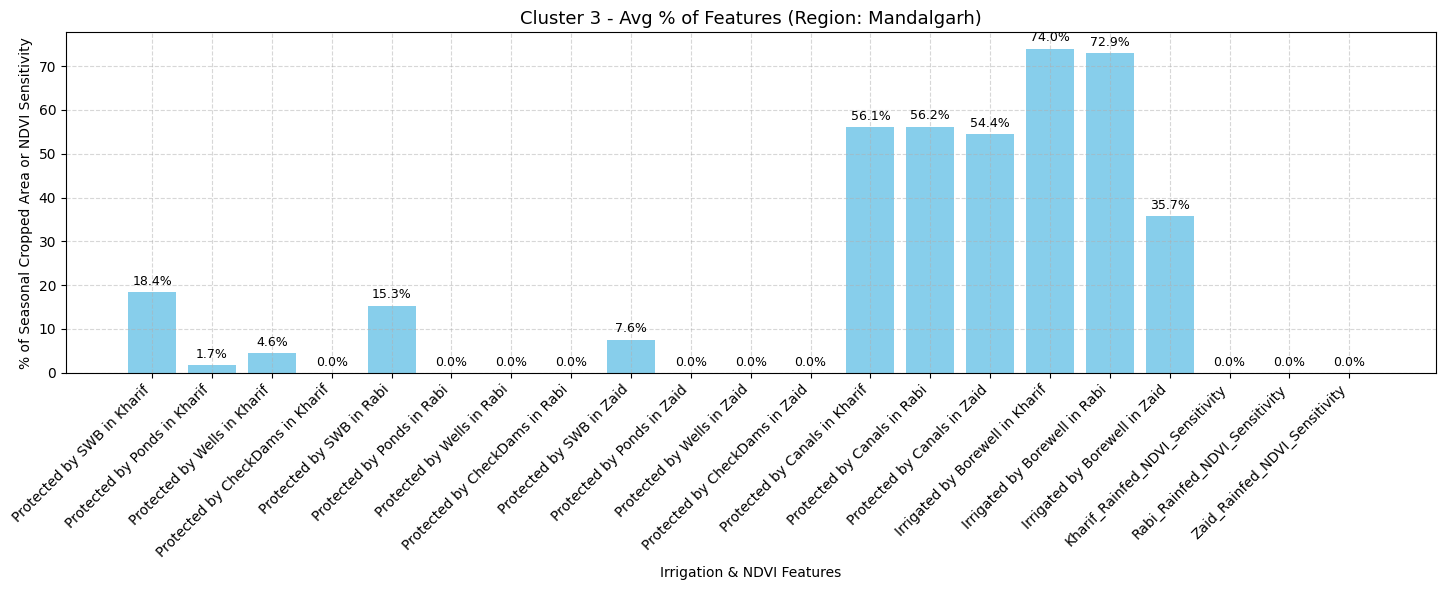

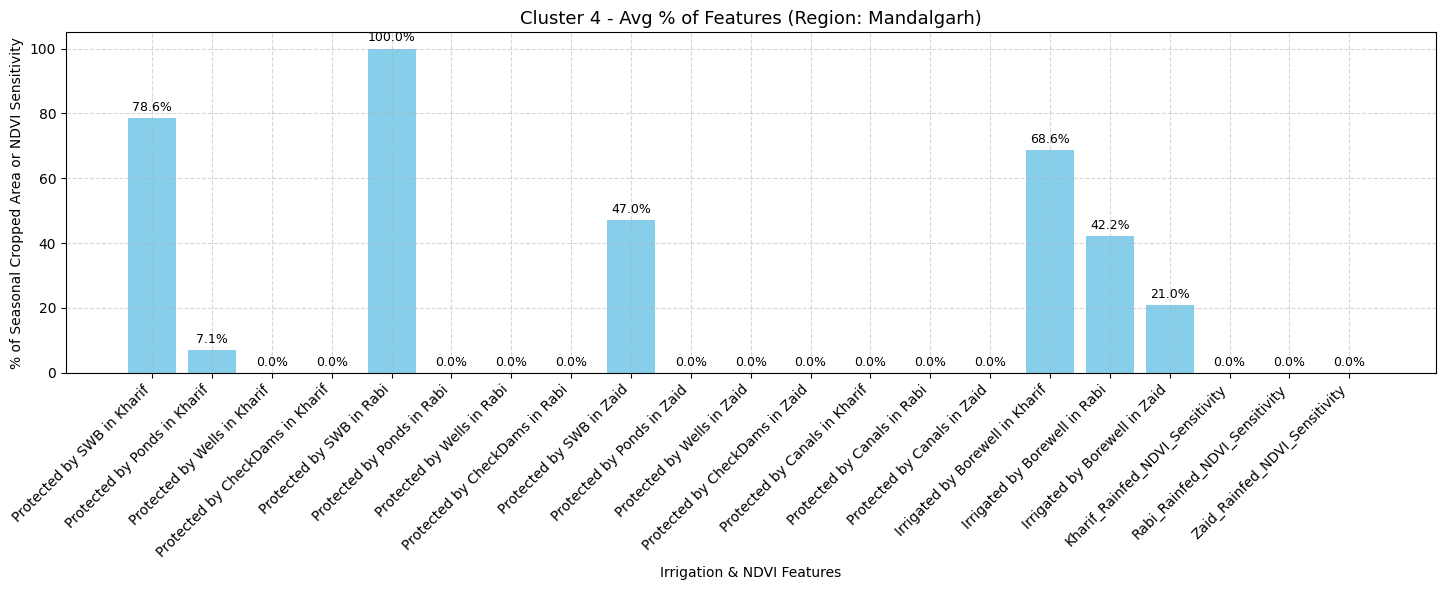

In [ ]:


# --- Load clustered CSV and clean region names ---
df_clusters = pd.read_csv('8.Clustered_CSV/Clusteres_Merged_Features.csv')
df_clusters['Region'] = df_clusters['Region'].str.replace('.csv', '', regex=False)

# --- Filter for the selected region ---
df_clusters_region = df_clusters[df_clusters['Region'] == region]

# --- Load region shapefile ---
shapefile_path = f"1.Entire_Data/MicroWaterSheds/{region}_mws/{region.lower()}_shapefile.shp"
gdf = gpd.read_file(shapefile_path)
gdf.rename(columns={'uid': 'MSW_ID'}, inplace=True)

# --- Merge spatial and cluster data ---
gdf = gdf.merge(df_clusters_region, on="MSW_ID", how="inner")

# --- Assign colors to clusters ---
unique_clusters = sorted(df_clusters_region["Cluster"].unique())
default_colors = ['red', 'blue', 'green', 'orange', 'purple', 'cyan', 'brown']
cluster_colors = {c: default_colors[i % len(default_colors)] for i, c in enumerate(unique_clusters)}
# --- Assign consistent colors to clusters using the fixed mapping ---


gdf["color"] = gdf["Cluster"].map(cluster_colors_global)

# --- Plot spatial clusters ---
fig, ax = plt.subplots(figsize=(12, 10))
gdf.plot(color=gdf["color"], ax=ax, edgecolor="black")

legend_patches = [
    mpatches.Patch(color=cluster_colors_global[c], label=f'Cluster {c}')
    for c in unique_clusters if c in cluster_colors_global
]
ax.legend(handles=legend_patches, title="Clusters", loc="upper right")
ax.set_title(f"Micro Watershed Clustering in {region}", fontsize=14)
ax.set_xticks([])
ax.set_yticks([])
plt.tight_layout()
plt.show()


# --- Get continuous feature columns ---
exclude_cols = {'MSW_ID', 'Region', 'Cluster'}
continuous_columns = [
    col for col in df_clusters_region.columns
    if col not in exclude_cols and df_clusters_region[col].dtype in ['float64', 'int64']
]

# --- Plot bar chart of mean values for each cluster ---
for cluster in unique_clusters:
    subset = df_clusters_region[df_clusters_region["Cluster"] == cluster]
    avg_values = subset[continuous_columns].mean() * 100  # Convert to %

    # Friendly labels
    friendly_labels = [get_friendly_label(col) for col in continuous_columns]

    fig, ax = plt.subplots(figsize=(max(12, len(continuous_columns)*0.7), 6))
    bars = ax.bar(friendly_labels, avg_values, color='skyblue')

    ax.set_title(f"Cluster {cluster} - Avg % of Features (Region: {region})", fontsize=13)
    ax.set_xlabel("Irrigation & NDVI Features")
    ax.set_ylabel("% of Seasonal Cropped Area or NDVI Sensitivity")
    ax.set_xticks(range(len(friendly_labels)))
    ax.set_xticklabels(friendly_labels, rotation=45, ha="right")

    # Annotate bars
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.1f}%',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=9)

    ax.grid(True, linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()


# EQUITY MEASUREMENT

In [ ]:
pwd

'/content/drive/MyDrive/Equity_Aatif'

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import rasterio
from rasterio.plot import show
from rasterio.mask import mask
import geopandas as gpd
import os
import math
from scipy import ndimage

# ======= UTILITY FUNCTIONS =======
def degrees_to_meters(lat1, lon1, lat2, lon2):
    """Convert lat/lon differences to meters using Haversine formula"""
    R = 6371000  # Earth radius in meters
    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = math.sin(dlat/2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon/2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    return R * c

def create_buffer_zones(water_data, transform, source_type):
    """Create buffer zones around water sources"""
    water_data = np.nan_to_num(water_data, nan=0)
    water_mask = water_data == 1

    center_lat = transform[5] + transform[4] * water_data.shape[0] / 2
    center_lon = transform[2] + transform[0] * water_data.shape[1] / 2
    pixel_height = degrees_to_meters(center_lat, center_lon, center_lat + abs(transform[4]), center_lon)
    pixel_width = degrees_to_meters(center_lat, center_lon, center_lat, center_lon + abs(transform[0]))
    pixel_size = (pixel_width + pixel_height) / 2

    distances = ndimage.distance_transform_edt(~water_mask) * pixel_size

    radii = {
        'Ponds': 100,
        'SWB': 200,
        'Canals': 200,
        'Wells': 50,
        'CheckDams': 200
    }

    zones = np.zeros_like(water_data)
    zones[distances <= radii[source_type]] = 1
    return zones

def load_mws_boundary(mws_id, boundary_dir):
    """Load MWS boundary from shapefile"""
    shapefile_path = os.path.join(boundary_dir, f"{mws_id}.shp")
    if os.path.exists(shapefile_path):
        return gpd.read_file(shapefile_path)
    return None

def clip_to_boundary(raster_data, transform, boundary):
    """Clip raster data to boundary polygon"""
    if boundary is None:
        return raster_data, transform

    try:
        # Convert boundary to raster CRS if needed
        boundary = boundary.to_crs(rasterio.crs.CRS.from_epsg(4326))

        # Perform the clip
        out_image, out_transform = mask(
            dataset=rasterio.open(raster_data) if isinstance(raster_data, str) else raster_data,
            shapes=boundary.geometry,
            crop=True,
            all_touched=True
        )
        return out_image[0] if len(out_image.shape) == 3 else out_image, out_transform
    except Exception as e:
        print(f"Error clipping to boundary: {e}")
        return raster_data, transform

def categorize_kharif_pixels(target_region="Masalia"):
    """Categorize pixels into 8 classes based on water source and crop health for Kharif season only"""

    # File paths
    base_dir = "/content/drive/MyDrive/Equity_Aatif/3.Output_Rasters"
    boundary_dir = "/content/drive/MyDrive/Equity_Aatif/MWS_Boundaries"  # Update this path
    year_folder = "21_22"
    region_dir = os.path.join(base_dir, target_region, year_folder)

    # Sensitivity file path (Kharif only)
    sensitivity_path = f"1.Entire_Data/Crop_Health_NDVI/Sensitivity/{target_region}/{target_region.lower()}_kharif_ndvi_sensitivity.tif"

    # Water source files (Kharif only)
    water_sources = {
        'Ponds': 'Ponds.tif',
        'Wells': 'Wells.tif',
        'Canals': 'Canals.tif',
        'CheckDams': 'CheckDams.tif',
        'SWB': 'SWB_Kharif.tif'
    }

    # Cropping pattern files (Kharif relevant only)
    cropping_files = {
        'single_kharif': 'Single_Kharif_Cropping.tif',
        'double_crop': 'Double_Cropping.tif',
        'triple_crop': 'Triple_Cropping.tif'
    }

    # Process each MWS folder
    for mws_folder in os.listdir(region_dir):
        mws_path = os.path.join(region_dir, mws_folder)
        if not os.path.isdir(mws_path):
            continue

        print(f"Processing {mws_folder}...")

        try:
            # Load MWS boundary
            boundary = load_mws_boundary(mws_folder, boundary_dir)

            # Load water sources and create buffer zones
            water_zones = {}
            transform = None

            for source, filename in water_sources.items():
                filepath = os.path.join(mws_path, filename)
                if os.path.exists(filepath):
                    with rasterio.open(filepath) as src:
                        data = src.read(1)
                        transform = src.transform
                        # Clip to boundary if available
                        if boundary is not None:
                            data, transform = clip_to_boundary(data, transform, boundary)
                        water_zones[source] = create_buffer_zones(data, transform, source.split('_')[0])

            # Load cropping patterns (Kharif relevant)
            crop_data = {}
            for pattern, filename in cropping_files.items():
                filepath = os.path.join(mws_path, filename)
                if os.path.exists(filepath):
                    with rasterio.open(filepath) as src:
                        data = src.read(1)
                        if boundary is not None:
                            data, _ = clip_to_boundary(data, src.transform, boundary)
                        crop_data[pattern] = data

            # Load Kharif sensitivity data
            sensitivity_data = None
            if os.path.exists(sensitivity_path):
                with rasterio.open(sensitivity_path) as src:
                    if boundary is not None:
                        data, transform = clip_to_boundary(src, src.transform, boundary)
                    else:
                        data = src.read(1)
                        transform = src.transform

                    if data.shape != crop_data[list(crop_data.keys())[0]].shape:
                        data = src.read(1, out_shape=crop_data[list(crop_data.keys())[0]].shape,
                                       resampling=rasterio.enums.Resampling.nearest)
                    sensitivity_data = np.nan_to_num(data, nan=0)

            # Create combined water influence (all water sources)
            combined_water = np.zeros_like(data, dtype=bool)
            for zones in water_zones.values():
                if zones.shape == combined_water.shape:
                    combined_water = np.logical_or(combined_water, zones == 1)

            # Create crop mask (Kharif crops only)
            crop_mask = np.zeros_like(data, dtype=bool)
            for crop in crop_data.values():
                if crop.shape == crop_mask.shape:
                    crop_mask = np.logical_or(crop_mask, crop == 1)

            # Create borewell mask (crop area not in water zones)
            borewell_mask = crop_mask & ~combined_water

            # Create crop health mask (sensitivity < 0 means affected)
            health_mask = np.zeros_like(data, dtype=bool)
            if sensitivity_data is not None and sensitivity_data.shape == health_mask.shape:
                health_mask = sensitivity_data < 0

            # Create classification raster (3-bit value)
            classification = np.zeros_like(data, dtype=np.uint8)

            # Bit 0: Waterbody (1 if in any water source zone)
            classification[combined_water] |= 0b100

            # Bit 1: Borewell (1 if in borewell-fed area)
            classification[borewell_mask] |= 0b010

            # Bit 2: Health affected (1 if sensitivity < 0)
            classification[health_mask & crop_mask] |= 0b001

            # Visualization
            # Color mapping (RGB values for each class)
            color_dict = {
                0b000: (1.0, 0.0, 0.0),    # Red
                0b001: (1.0, 0.5, 0.0),    # Orange
                0b010: (0.0, 0.0, 1.0),    # Blue
                0b011: (0.0, 0.5, 1.0),    # Light blue
                0b100: (0.0, 1.0, 0.0),    # Green
                0b101: (0.5, 1.0, 0.0),    # Yellow-green
                0b110: (1.0, 0.0, 1.0),    # Purple
                0b111: (0.5, 0.0, 0.5)     # Dark purple
            }

            # Create colormap
            cmap = mcolors.ListedColormap([color_dict[i] for i in range(8)])
            bounds = list(range(9))
            norm = mcolors.BoundaryNorm(bounds, cmap.N)

            # Plot with boundary
            fig, ax = plt.subplots(figsize=(12, 10))

            # Show the classification
            img = ax.imshow(classification, cmap=cmap, norm=norm)

            # Add boundary if available
            if boundary is not None:
                boundary.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=2)

            plt.title(f"Kharif Pixel Classification - {mws_folder}\n{target_region}", fontsize=14)

            # Create legend
            legend_labels = {
                0b000: "000: No waterbody, No borewell, Health not affected",
                0b001: "001: No waterbody, No borewell, Health affected",
                0b010: "010: No waterbody, Borewell, Health not affected",
                0b011: "011: No waterbody, Borewell, Health affected",
                0b100: "100: Waterbody, No borewell, Health not affected",
                0b101: "101: Waterbody, No borewell, Health affected",
                0b110: "110: Waterbody, Borewell, Health not affected",
                0b111: "111: Waterbody, Borewell, Health affected"
            }

            patches = [plt.plot([], [], marker="s", ms=10, ls="",
                                color=color_dict[key],
                                label=legend_labels[key])[0] for key in color_dict]

            plt.legend(handles=patches, bbox_to_anchor=(1.05, 1),
                      loc='upper left', borderaxespad=0., fontsize=10)

            plt.tight_layout()
            plt.show()

            # Save classification to CSV
            output_df = pd.DataFrame({
                'MSW_ID': [mws_folder] * classification.size,
                'Classification': classification.flatten()
            })

            # output_path = f"{target_region}_{mws_folder}_Kharif_pixel_classification.csv"
            # output_df.to_csv(output_path, index=False)
            # print(f"Saved Kharif classification to {output_path}")

        except Exception as e:
            print(f"Error processing {mws_folder}: {e}")
            continue

# Run for Masalia (Kharif only)
categorize_kharif_pixels("Masalia")

Output hidden; open in https://colab.research.google.com to view.

# Verification Using Logistic Regression

In [7]:
pwd

'/content/drive/MyDrive/Equity_Aatif'

In [8]:
gwra = gpd.read_file('1.Entire_Data/Explanation/gwra2020.geojson')

In [9]:
shapefile = gpd.read_file('1.Entire_Data/MicroWaterSheds/Masalia_mws/masalia_shapefile.shp')

In [10]:
# Load the data
df_clusters = pd.read_csv('8.Clustered_CSV/Clusteres_Merged_Features.csv')

# Strip '.csv' from Region column
df_clusters['Region'] = df_clusters['Region'].str.replace('.csv', '', regex=False)

# Now filter for Masalia
df_masalia = df_clusters[df_clusters['Region'] == 'Masalia']

In [11]:
# Merge on uid (shapefile) == MSW_ID (df_clusters)
shapefile = shapefile.merge(df_masalia[['MSW_ID', 'Cluster']], left_on='uid', right_on='MSW_ID', how='left')

# Drop duplicate MSW_ID column if not needed
shapefile.drop(columns=['MSW_ID'], inplace=True)


In [12]:
shapefile.head()

id        uid                                           geometry  Cluster
0  608  12_344879  POLYGON ((87.24821 24.14469, 87.24848 24.14469...        1
1  606  12_342256  MULTIPOLYGON (((87.28675 24.13472, 87.28648 24...        4
2  610  12_346952  POLYGON ((87.25576 24.16868, 87.25576 24.16895...        4
3  655  12_367323  POLYGON ((87.25764 24.02504, 87.25764 24.02315...        1
4  611  12_347489  MULTIPOLYGON (((87.31585 24.1075, 87.31585 24....        4

## GWRA - SoGE

In [13]:
# Ensure both are in the same CRS (Coordinate Reference System)
if gwra.crs != shapefile.crs:
    shapefile = shapefile.to_crs(gwra.crs)

# Clip GWRA to Masalia boundary
gwra_masalia = gpd.clip(gwra, shapefile)

In [14]:
gwra_masalia.head(2)

objectid     block tehsil district  gwr_2011_2  code class    na_gwa  \
629        618  Kundahit   None  Jamtara         NaN   1.0  Safe   771.620   
6359      6360  Rajnagar  -9999  Birbhum     -9999.0   1.0  Safe  2281.222   

      agwd_irr  sgw_dev_pe  agwd_dom_i  agwd_tot  ar_gwr_tot state  \
629     272.25   49.803012  112.040838   384.290     857.350    JH   
6359     44.10    7.550000  128.101000   172.201    2534.692    WB   

      nat_discharge  st_area(shape)  st_length(shape)  \
629           85.73    3.152016e+08     114316.929352   
6359       -9999.00    2.143781e+08      99156.202855   

                                               geometry  
629   POLYGON ((4708019.931 4023117.731, 4708040.984...  
6359  MULTIPOLYGON (((4724001.85 4023313.598, 472394...

In [15]:
gwra_masalia['class'].value_counts()

class
Safe    8
Name: count, dtype: int64

In [16]:
# Assign GWRA status
shapefile['SoGE'] = 'Safe'


In [17]:
shapefile.head(10)

id        uid                                           geometry  Cluster  \
0  608  12_344879  POLYGON ((4722034.266 4034290.616, 4722061.342...        1   
1  606  12_342256  MULTIPOLYGON (((4725926.039 4033406.758, 47258...        4   
2  610  12_346952  POLYGON ((4722651.537 4036930.807, 4722650.041...        4   
3  655  12_367323  POLYGON ((4723642.445 4021361.22, 4723652.992 ...        1   
4  611  12_347489  MULTIPOLYGON (((4728976.335 4030604.966, 47289...        4   
5  650  12_365066  MULTIPOLYGON (((4716834.056 4033965.149, 47168...        1   
6  613  12_349531  POLYGON ((4725771.329 4029120.262, 4725797.965...        1   
7  113  12_305795  POLYGON ((4718201.885 4034035.136, 4718200.399...        1   
8  654  12_366744  POLYGON ((4718064.946 4024093.301, 4718038.293...        1   
9  614  12_351003  POLYGON ((4725771.329 4029120.262, 4725777.384...        1   

   SoGE  
0  Safe  
1  Safe  
2  Safe  
3  Safe  
4  Safe  
5  Safe  
6  Safe  
7  Safe  
8  Safe  
9  Safe

## River

In [18]:
# Load river shapefile
shapefile_folder = '1.Entire_Data/Explanation/River'
for file in os.listdir(shapefile_folder):
    if file.endswith('.shp'):
        shapefile_path = os.path.join(shapefile_folder, file)
        break
else:
    raise FileNotFoundError("No .shp file found in the folder!")

river = gpd.read_file(shapefile_path)

In [19]:
river

objectid ripcode      rivname     shape_leng  k50 bacode    st_area(sh  \
0           1.0      01       Chenab  141981.422367  NaN   None  4.535306e+06   
1           2.0      01  Saichu Nala   32237.498166  NaN   None  9.398595e+05   
2           3.0      01   Miyar Nala   26864.659056  NaN   None  7.198171e+05   
3         103.0      01          Pin   32726.523116  NaN   None  4.662986e+06   
4           4.0      01  Jankar Nala   28014.111412  NaN   None  1.195577e+06   
...         ...     ...          ...            ...  ...    ...           ...   
40895   40896.0      02        Barak     646.747031  NaN   None  1.354540e+04   
40896   40897.0      02        Barak     593.672572  NaN   None  2.216552e+04   
40897   40898.0      02        Barak     582.245943  NaN   None  1.067515e+04   
40898   40899.0      02        Barak     536.796685  NaN   None  1.677109e+04   
40899   40900.0      02        Irang     486.890106  NaN   None  1.294843e+04   

          st_length(                                           geometry  
0      141981.422367  POLYGON ((8534275.517 3858401.954, 8534290.7 3...  
1       32237.498166  POLYGON ((8528094.15 3898170.983, 8528062.983 ...  
2       26864.659056  POLYGON ((8534290.7 3858386.897, 8534275.517 3...  
3       32726.523116  POLYGON ((8704462.883 3775807.507, 8704499.305...  
4       28014.111412  POLYGON ((8595085.944 3851894.601, 8595134.29 ...  
...              ...                                                ...  
40895     646.747031  POLYGON ((10474796.791 2919738.557, 10474779.8...  
40896     593.672572  POLYGON ((10474604.891 2919495.353, 10474596.7...  
40897     582.245943  POLYGON ((10474717.834 2919491.666, 10474701.0...  
40898     536.796685  POLYGON ((10473876.016 2917660.813, 10473860.9...  
40899     486.890106  POLYGON ((10437208.87 2895590.829, 10437213.68...  

[40900 rows x 9 columns]

In [20]:
# Ensure CRS matches
if shapefile.crs != river.crs:
    river = river.to_crs(shapefile.crs)

# Use spatial index for efficient intersection
river_sindex = river.sindex

# Function to compute total intersecting river area in hectares
def compute_river_area_ha(geom):
    possible_matches_index = list(river_sindex.intersection(geom.bounds))
    possible_matches = river.iloc[possible_matches_index]
    intersections = possible_matches.intersection(geom)
    total_area = intersections.area.sum()  # in CRS units (e.g., square meters)
    return total_area / 10000  # convert m² to hectares

# Apply to each microwatershed polygon
shapefile['River_Area_ha'] = shapefile['geometry'].apply(compute_river_area_ha)

In [21]:
shapefile.head(10)

id        uid                                           geometry  Cluster  \
0  608  12_344879  POLYGON ((4722034.266 4034290.616, 4722061.342...        1   
1  606  12_342256  MULTIPOLYGON (((4725926.039 4033406.758, 47258...        4   
2  610  12_346952  POLYGON ((4722651.537 4036930.807, 4722650.041...        4   
3  655  12_367323  POLYGON ((4723642.445 4021361.22, 4723652.992 ...        1   
4  611  12_347489  MULTIPOLYGON (((4728976.335 4030604.966, 47289...        4   
5  650  12_365066  MULTIPOLYGON (((4716834.056 4033965.149, 47168...        1   
6  613  12_349531  POLYGON ((4725771.329 4029120.262, 4725797.965...        1   
7  113  12_305795  POLYGON ((4718201.885 4034035.136, 4718200.399...        1   
8  654  12_366744  POLYGON ((4718064.946 4024093.301, 4718038.293...        1   
9  614  12_351003  POLYGON ((4725771.329 4029120.262, 4725777.384...        1   

   SoGE  River_Area_ha  
0  Safe       0.000000  
1  Safe     667.707991  
2  Safe     526.795568  
3  Safe      43.198495  
4  Safe     234.372459  
5  Safe       0.000000  
6  Safe       0.003677  
7  Safe       0.000000  
8  Safe       5.621926  
9  Safe       4.349850

## Aquifer

In [22]:
# Load river shapefile
shapefile_folder = '1.Entire_Data/Explanation/Aquifer'
for file in os.listdir(shapefile_folder):
    if file.endswith('.shp'):
        shapefile_path = os.path.join(shapefile_folder, file)
        break
else:
    raise FileNotFoundError("No .shp file found in the folder!")

aquifer = gpd.read_file(shapefile_path)

In [23]:
print(aquifer.columns.tolist())

['objectid', 'newcode14', 'aquifer', 'newcode43', 'aquifer0', 'system', 'aquifers', 'zone_m', 'mbgl', 'avg_mbgl', 'm2_perday', 'm3_per_day', 'yeild__', 'per_cm', 'state', 'pa_order', 'test', 'area_re', 'shape_Leng', 'shape_Area', 'geometry']


In [24]:
aquifer = aquifer[['objectid', 'newcode14', 'geometry']]
#aquifer.head(20)

In [25]:
aquifer['Aquifer'] = aquifer['newcode14'].apply(lambda x: 'alluvium aquifers' if x == 'AL' else 'hard rock aquifers')

In [26]:
#aquifer.head(50)

In [27]:
# Ensure same CRS
if shapefile.crs != aquifer.crs:
    aquifer = aquifer.to_crs(shapefile.crs)

# Spatial join: aquifers joined to each microwatershed polygon
joined = gpd.sjoin(aquifer[['Aquifer', 'geometry']], shapefile[['uid', 'geometry']], how='inner', predicate='intersects')

# Group by shapefile UID and find the dominant Aquifer type
dominant_aquifer = joined.groupby('uid')['Aquifer'].agg(lambda x: x.mode().iloc[0]).reset_index()

# Merge back into shapefile
shapefile = shapefile.merge(dominant_aquifer, on='uid', how='left')

In [28]:
shapefile.head(5)

id        uid                                           geometry  Cluster  \
0  608  12_344879  POLYGON ((4722034.266 4034290.616, 4722061.342...        1   
1  606  12_342256  MULTIPOLYGON (((4725926.039 4033406.758, 47258...        4   
2  610  12_346952  POLYGON ((4722651.537 4036930.807, 4722650.041...        4   
3  655  12_367323  POLYGON ((4723642.445 4021361.22, 4723652.992 ...        1   
4  611  12_347489  MULTIPOLYGON (((4728976.335 4030604.966, 47289...        4   

   SoGE  River_Area_ha             Aquifer  
0  Safe       0.000000  hard rock aquifers  
1  Safe     667.707991  hard rock aquifers  
2  Safe     526.795568  hard rock aquifers  
3  Safe      43.198495  hard rock aquifers  
4  Safe     234.372459  hard rock aquifers

## Terrian

In [29]:
terrain = pd.read_csv('1.Entire_Data/Explanation/Terrian/dumka_masalia_cluster.csv')

In [30]:
terrain.head(2)

FID                                           the_geom  \
0  dumka_masalia_cluster.1  MULTIPOLYGON (((87.2482070058227 24.1446944852...   
1  dumka_masalia_cluster.2  MULTIPOLYGON (((87.0423169634877 24.2171860816...   

   area_in_ha  hill_slope   id  plain_area  ridge_area  slopy_area  \
0  847.832509   11.981507  608   16.617719   10.803710   40.373439   
1  788.156499    0.000000  577   76.308094    3.625346   18.585984   

   terrainClu        uid  valley_are  
0           0  12_344879   20.223626  
1           1  12_321768    1.480576

In [31]:
terrain = terrain[['FID', 'the_geom', 'terrainClu']]
terrain.head(2)

FID                                           the_geom  \
0  dumka_masalia_cluster.1  MULTIPOLYGON (((87.2482070058227 24.1446944852...   
1  dumka_masalia_cluster.2  MULTIPOLYGON (((87.0423169634877 24.2171860816...   

   terrainClu  
0           0  
1           1

In [32]:
import geopandas as gpd
import pandas as pd
from shapely import wkt
import matplotlib.pyplot as plt

# Step 1: Load terrain CSV and convert to GeoDataFrame
terrain = pd.read_csv('1.Entire_Data/Explanation/Terrian/dumka_masalia_cluster.csv')
terrain = terrain[['FID', 'the_geom', 'terrainClu']].dropna(subset=['the_geom'])

# Convert WKT strings to geometry objects
terrain['geometry'] = terrain['the_geom'].apply(wkt.loads)
terrain_gdf = gpd.GeoDataFrame(terrain, geometry='geometry')

# Step 2: Set correct CRS (terrain is in WGS84 lat/lon)
terrain_gdf.set_crs("EPSG:4326", inplace=True)

# Step 3: Reproject terrain to match shapefile CRS
terrain_gdf = terrain_gdf.to_crs(shapefile.crs)

# Optional: Drop existing terrainClu in shapefile to avoid '_left/_right' suffixes
if 'terrainClu' in shapefile.columns:
    shapefile = shapefile.drop(columns='terrainClu')

# Step 4: Spatial join - find overlapping terrain polygons
terrain_for_join = terrain_gdf[['terrainClu', 'geometry']]
joined = gpd.sjoin(shapefile, terrain_for_join, how='left', predicate='intersects')

# Step 5: For each shapefile polygon, get max terrainClu from overlaps
max_terrain = joined.groupby(joined.index)['terrainClu'].max()

# Step 6: Assign max terrainClu back to shapefile
shapefile['terrainClu'] = shapefile.index.map(max_terrain)

# # Step 7 (Optional): Visual check
# ax = shapefile.plot(edgecolor='blue', facecolor='none', figsize=(10, 10))
# terrain_gdf.plot(ax=ax, edgecolor='red', facecolor='none')
# plt.title("Blue = shapefile, Red = terrain (after projection)")
# plt.show()

# # Step 8 (Optional): Save result
# # shapefile.to_file("output_with_terrainClu.shp")


In [33]:
shapefile.head(10)

id        uid                                           geometry  Cluster  \
0  608  12_344879  POLYGON ((4722034.266 4034290.616, 4722061.342...        1   
1  606  12_342256  MULTIPOLYGON (((4725926.039 4033406.758, 47258...        4   
2  610  12_346952  POLYGON ((4722651.537 4036930.807, 4722650.041...        4   
3  655  12_367323  POLYGON ((4723642.445 4021361.22, 4723652.992 ...        1   
4  611  12_347489  MULTIPOLYGON (((4728976.335 4030604.966, 47289...        4   
5  650  12_365066  MULTIPOLYGON (((4716834.056 4033965.149, 47168...        1   
6  613  12_349531  POLYGON ((4725771.329 4029120.262, 4725797.965...        1   
7  113  12_305795  POLYGON ((4718201.885 4034035.136, 4718200.399...        1   
8  654  12_366744  POLYGON ((4718064.946 4024093.301, 4718038.293...        1   
9  614  12_351003  POLYGON ((4725771.329 4029120.262, 4725777.384...        1   

   SoGE  River_Area_ha             Aquifer  terrainClu  
0  Safe       0.000000  hard rock aquifers           0  
1  Safe     667.707991  hard rock aquifers           1  
2  Safe     526.795568  hard rock aquifers           3  
3  Safe      43.198495  hard rock aquifers           1  
4  Safe     234.372459  hard rock aquifers           1  
5  Safe       0.000000  hard rock aquifers           3  
6  Safe       0.003677  hard rock aquifers           1  
7  Safe       0.000000  hard rock aquifers           0  
8  Safe       5.621926  hard rock aquifers           1  
9  Safe       4.349850  hard rock aquifers           1

## Census

In [72]:
pwd

'/content/drive/MyDrive/Equity_Aatif'

In [77]:
# Step 2: Load and fix CRS of metadata
metadata = gpd.read_file('1.Entire_Data/Explanation/Census/JH.geojson')
metadata = metadata[['pc11_village_id', 'P_SC', 'P_ST', 'P_LIT', 'P_ILL', 'TOT_P', 'geometry']]

# Set correct CRS: metadata is in EPSG:4326 (lat/lon)
metadata.set_crs("EPSG:4326", inplace=True)

# Reproject metadata to shapefile CRS (usually UTM)
metadata = metadata.to_crs(shapefile.crs)

# Step 3: Spatial join (intersects)
joined = gpd.sjoin(shapefile, metadata, how='left', predicate='intersects')

# Detect actual column names for census data
census_cols = ['P_SC', 'P_ST', 'P_LIT', 'P_ILL', 'TOT_P']

# Find which exist in joined (with or without _right)
census_cols_in_joined = []
for col in census_cols:
    if col in joined.columns:
        census_cols_in_joined.append(col)
    elif f"{col}_right" in joined.columns:
        census_cols_in_joined.append(f"{col}_right")

print("Using census columns:", census_cols_in_joined)

# Step 4: Aggregate mean values
avg_values = joined.groupby(joined.index)[census_cols_in_joined].mean()

# Step 5: Map back to shapefile
for col, col_in_joined in zip(census_cols, census_cols_in_joined):
    shapefile[col] = shapefile.index.map(avg_values[col_in_joined])

# Step 6: Optional clean-up of '_left' columns (if present)
shapefile = shapefile.drop(columns=[col for col in shapefile.columns if col.endswith('_left')], errors='ignore')

# Step 7: Check result
print("Sample with census data:\n", shapefile[['uid', 'P_SC', 'P_ST', 'P_LIT', 'P_ILL', 'TOT_P']].head(10))

# # Step 8: Optional - visualize overlap
# ax = shapefile.plot(edgecolor='blue', facecolor='none', figsize=(10, 10))
# metadata.plot(ax=ax, edgecolor='red', facecolor='none')
# plt.title("Blue = shapefile, Red = census metadata (after reprojection)")
# plt.show()

# # Step 9: Optional - export result
# # shapefile.to_file("shapefile_with_census_data.shp")
# # or shapefile.to_file("output.geojson", driver="GeoJSON")

Using census columns: ['P_SC_right', 'P_ST_right', 'P_LIT_right', 'P_ILL_right', 'TOT_P']
Sample with census data:
          uid       P_SC        P_ST       P_LIT       P_ILL       TOT_P
0  12_344879   4.500000  201.583333   79.500000  130.083333  209.583333
1  12_342256   4.666667  173.416667   97.708333  109.375000  207.083333
2  12_346952  10.631579  135.789474  100.947368   97.789474  198.736842
3  12_367323  44.000000  406.500000  276.000000  302.500000  578.500000
4  12_347489  43.666667  274.074074  227.481481  229.000000  456.481481
5  12_365066  16.840000  216.120000  160.440000  167.880000  328.320000
6  12_349531  35.090909  277.272727  257.000000  320.818182  577.818182
7  12_305795   5.909091  307.909091  134.636364  188.000000  322.636364
8  12_366744   2.000000  255.619048  149.333333  167.095238  316.428571
9  12_351003  26.133333  332.600000  243.000000  309.800000  552.800000


In [78]:
shapefile.head(10)

id        uid                                           geometry  Cluster  \
0  608  12_344879  POLYGON ((4722034.266 4034290.616, 4722061.342...        1   
1  606  12_342256  MULTIPOLYGON (((4725926.039 4033406.758, 47258...        4   
2  610  12_346952  POLYGON ((4722651.537 4036930.807, 4722650.041...        4   
3  655  12_367323  POLYGON ((4723642.445 4021361.22, 4723652.992 ...        1   
4  611  12_347489  MULTIPOLYGON (((4728976.335 4030604.966, 47289...        4   
5  650  12_365066  MULTIPOLYGON (((4716834.056 4033965.149, 47168...        1   
6  613  12_349531  POLYGON ((4725771.329 4029120.262, 4725797.965...        1   
7  113  12_305795  POLYGON ((4718201.885 4034035.136, 4718200.399...        1   
8  654  12_366744  POLYGON ((4718064.946 4024093.301, 4718038.293...        1   
9  614  12_351003  POLYGON ((4725771.329 4029120.262, 4725777.384...        1   

   SoGE  River_Area_ha             Aquifer  terrainClu       P_SC        P_ST  \
0  Safe       0.000000  hard rock aquifers           0   4.500000  201.583333   
1  Safe     667.707991  hard rock aquifers           1   4.666667  173.416667   
2  Safe     526.795568  hard rock aquifers           3  10.631579  135.789474   
3  Safe      43.198495  hard rock aquifers           1  44.000000  406.500000   
4  Safe     234.372459  hard rock aquifers           1  43.666667  274.074074   
5  Safe       0.000000  hard rock aquifers           3  16.840000  216.120000   
6  Safe       0.003677  hard rock aquifers           1  35.090909  277.272727   
7  Safe       0.000000  hard rock aquifers           0   5.909091  307.909091   
8  Safe       5.621926  hard rock aquifers           1   2.000000  255.619048   
9  Safe       4.349850  hard rock aquifers           1  26.133333  332.600000   

        P_LIT       P_ILL       TOT_P  
0   79.500000  130.083333  209.583333  
1   97.708333  109.375000  207.083333  
2  100.947368   97.789474  198.736842  
3  276.000000  302.500000  578.500000  
4  227.481481  229.000000  456.481481  
5  160.440000  167.880000  328.320000  
6  257.000000  320.818182  577.818182  
7  134.636364  188.000000  322.636364  
8  149.333333  167.095238  316.428571  
9  243.000000  309.800000  552.800000

## Explanation

In [64]:
pwd

'/content/drive/MyDrive/Equity_Aatif'

=== CLUSTER EXPLANATION ANALYSIS ===
Total MWS units: 64
Clusters found: [np.int64(1), np.int64(4)]
Missing values per column:
uid              0
Cluster          0
SoGE             0
River_Area_ha    0
Aquifer          0
terrainClu       0
P_SC             0
P_ST             0
P_LIT            0
P_ILL            0
TOT_P            0
dtype: int64

=== DATA UNDERSTANDING ===
Census data appears to be in absolute counts, not percentages!
Converting to actual percentages using TOT_P (total population)

Raw census data ranges (absolute counts):
P_SC: min=2.0, max=109.8, mean=28.7
P_ST: min=38.6, max=557.0, mean=259.9
P_LIT: min=79.5, max=623.1, mean=266.9
P_ILL: min=81.8, max=718.2, mean=249.9
TOT_P: min=187.9, max=1271.5, mean=516.8

Converting to percentages...
After conversion - Census PERCENTAGES:
P_SC_pct: min=0.63%, max=20.25%, mean=5.48%
P_ST_pct: min=8.79%, max=96.18%, mean=54.35%
P_LIT_pct: min=37.93%, max=59.46%, mean=51.52%
P_ILL_pct: min=40.54%, max=62.07%, mean=48.48%

Sample 

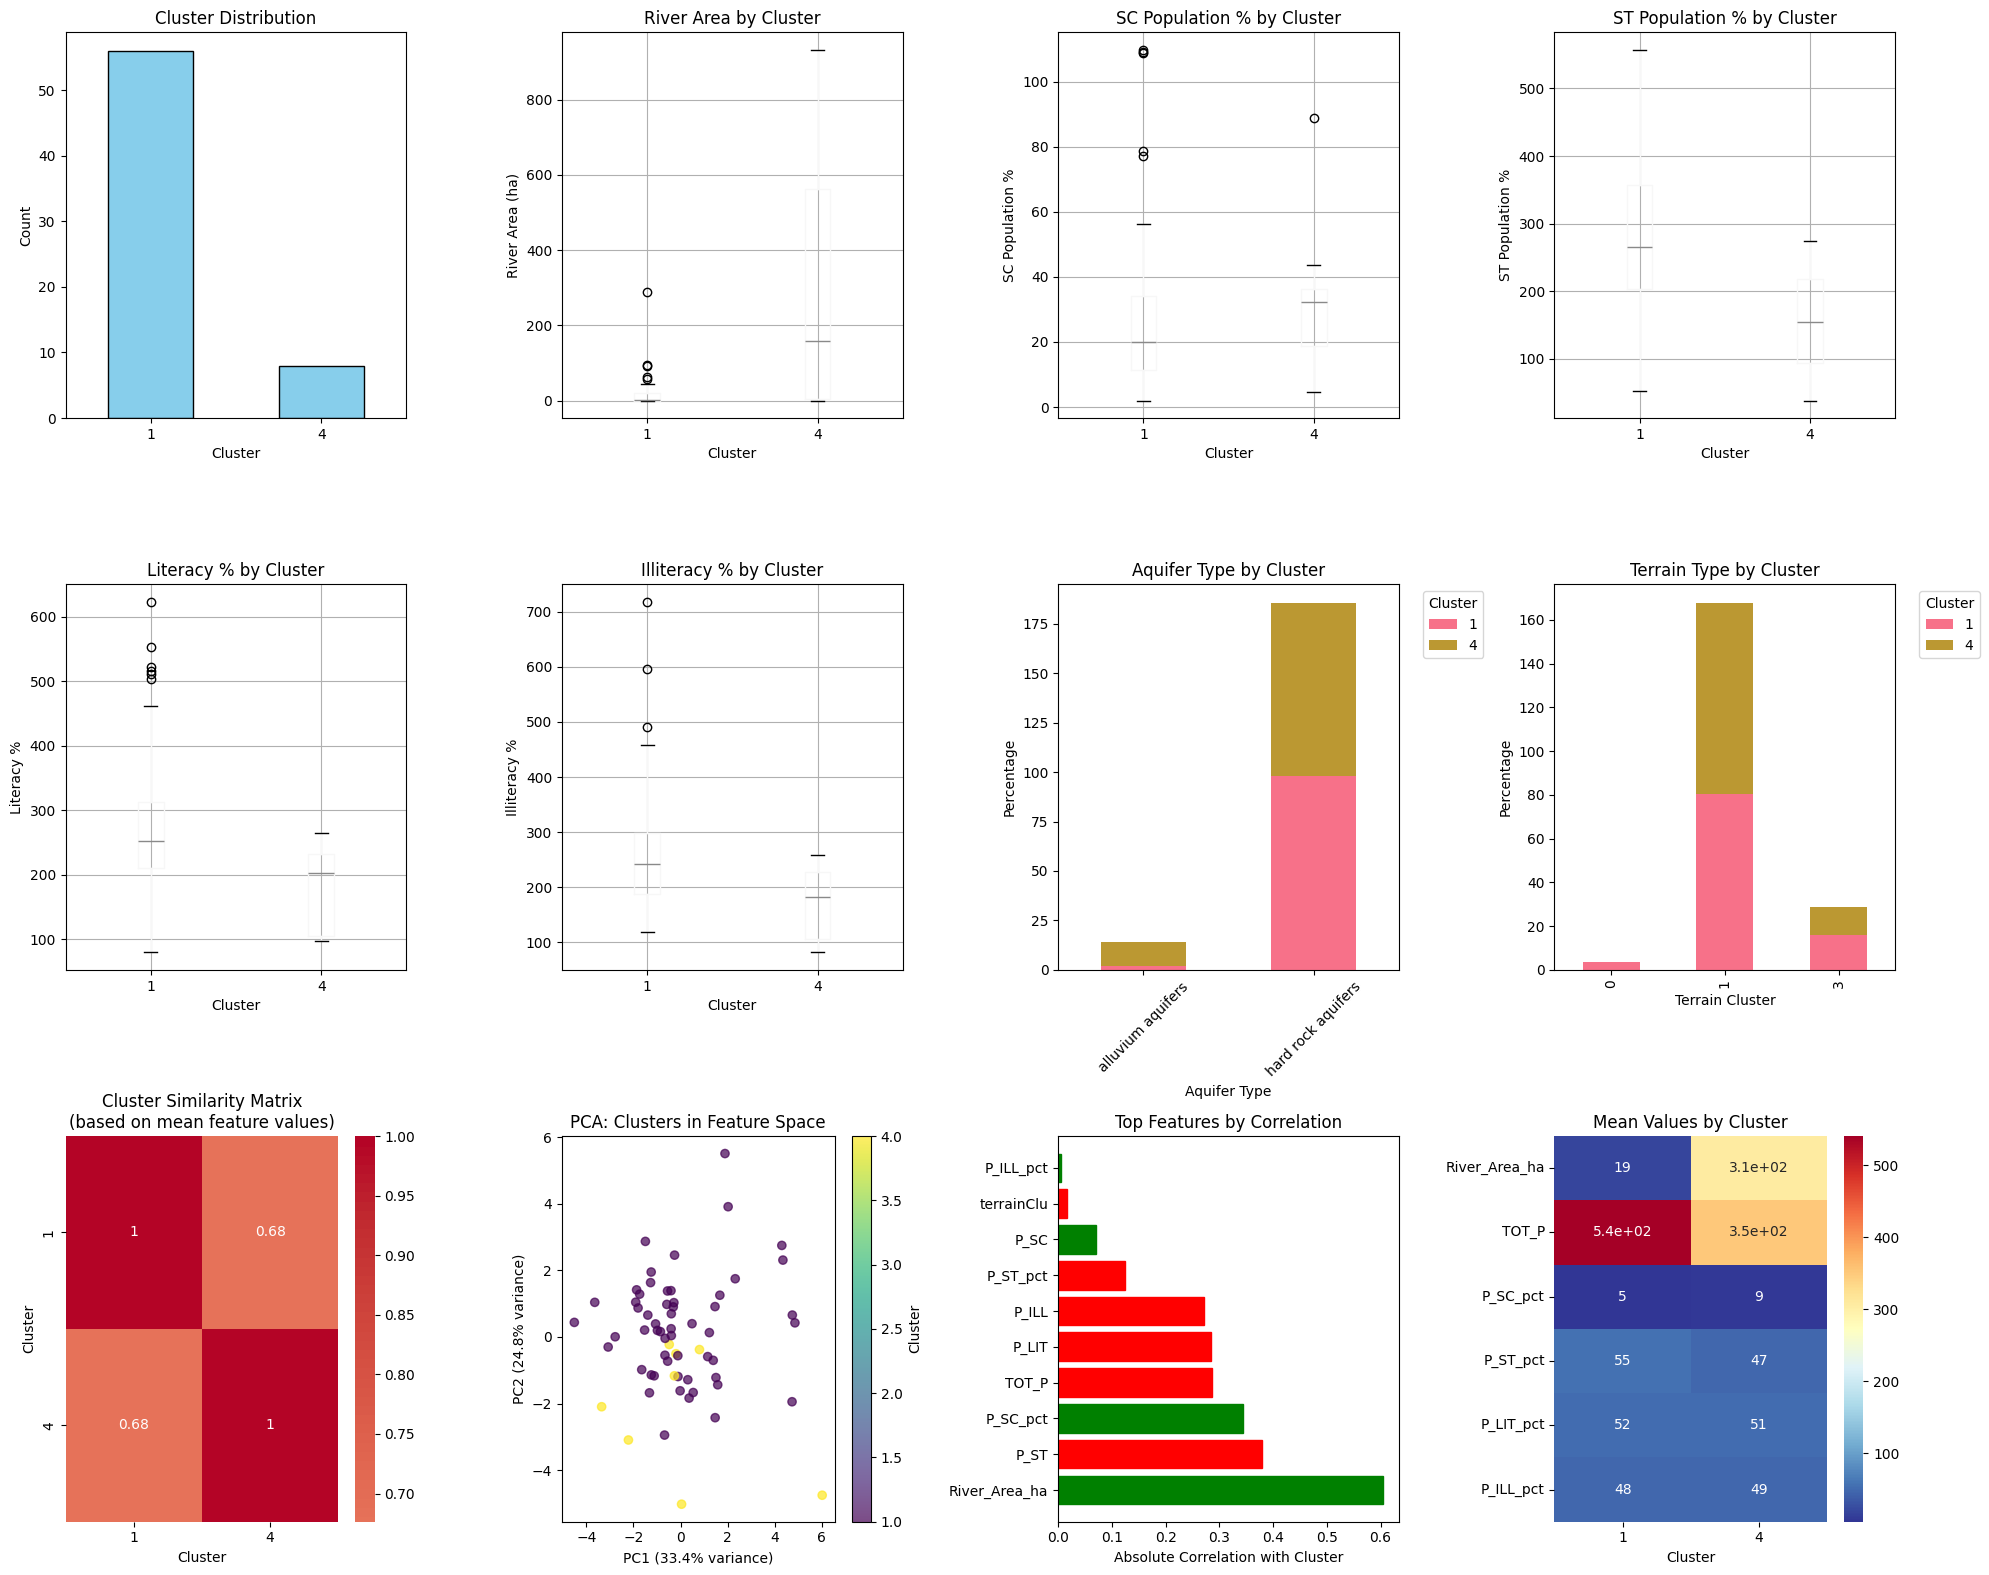

In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

# Assuming your shapefile DataFrame is named 'shapefile'
# Extract the relevant columns for analysis
analysis_df = shapefile[['uid', 'Cluster', 'SoGE', 'River_Area_ha', 'Aquifer', 'terrainClu',
                        'P_SC', 'P_ST', 'P_LIT', 'P_ILL', 'TOT_P']].copy()

# Remove any rows with missing cluster assignments
analysis_df = analysis_df.dropna(subset=['Cluster'])

print("=== CLUSTER EXPLANATION ANALYSIS ===")
print(f"Total MWS units: {len(analysis_df)}")
print(f"Clusters found: {sorted(analysis_df['Cluster'].unique())}")
print(f"Missing values per column:\n{analysis_df.isnull().sum()}")

# DATA QUALITY CHECK AND CONVERSION
print("\n=== DATA UNDERSTANDING ===")
print("Census data appears to be in absolute counts, not percentages!")
print("Converting to actual percentages using TOT_P (total population)")

census_count_cols = ['P_SC', 'P_ST', 'P_LIT', 'P_ILL']
print("\nRaw census data ranges (absolute counts):")
for col in census_count_cols + ['TOT_P']:
    print(f"{col}: min={analysis_df[col].min():.1f}, max={analysis_df[col].max():.1f}, mean={analysis_df[col].mean():.1f}")

# Convert absolute counts to actual percentages
print("\nConverting to percentages...")
analysis_df['P_SC_pct'] = (analysis_df['P_SC'] / analysis_df['TOT_P'] * 100).fillna(0)
analysis_df['P_ST_pct'] = (analysis_df['P_ST'] / analysis_df['TOT_P'] * 100).fillna(0)
analysis_df['P_LIT_pct'] = (analysis_df['P_LIT'] / analysis_df['TOT_P'] * 100).fillna(0)
analysis_df['P_ILL_pct'] = (analysis_df['P_ILL'] / analysis_df['TOT_P'] * 100).fillna(0)

# Clean any impossible values (>100%)
for col in ['P_SC_pct', 'P_ST_pct', 'P_LIT_pct', 'P_ILL_pct']:
    analysis_df[col] = np.clip(analysis_df[col], 0, 100)

print("After conversion - Census PERCENTAGES:")
census_pct_cols = ['P_SC_pct', 'P_ST_pct', 'P_LIT_pct', 'P_ILL_pct']
for col in census_pct_cols:
    print(f"{col}: min={analysis_df[col].min():.2f}%, max={analysis_df[col].max():.2f}%, mean={analysis_df[col].mean():.2f}%")

# Show sample conversion
print("\nSample conversion verification:")
sample = analysis_df[['uid', 'P_SC', 'TOT_P', 'P_SC_pct']].head(5)
print(sample)

# 1. CLUSTER DISTRIBUTION
print("\n=== 1. CLUSTER DISTRIBUTION ===")
cluster_counts = analysis_df['Cluster'].value_counts().sort_index()
print(cluster_counts)

# 2. NUMERICAL FEATURES ANALYSIS BY CLUSTER
print("\n=== 2. NUMERICAL FEATURES BY CLUSTER (CORRECT PERCENTAGES) ===")
numerical_cols = ['River_Area_ha', 'TOT_P', 'P_SC_pct', 'P_ST_pct', 'P_LIT_pct', 'P_ILL_pct']

# Calculate statistics by cluster
cluster_stats = analysis_df.groupby('Cluster')[numerical_cols].agg(['mean', 'median', 'std', 'min', 'max']).round(2)
print(cluster_stats)

# Also show a sample of corrected data for verification
print("\nSample of corrected data:")
print(analysis_df[['uid', 'Cluster', 'TOT_P'] + census_pct_cols].head(10))

# 3. CATEGORICAL FEATURES ANALYSIS
print("\n=== 3. CATEGORICAL FEATURES BY CLUSTER ===")

# SoGE by Cluster
print("\n3.1 SoGE Distribution by Cluster:")
soge_crosstab = pd.crosstab(analysis_df['Cluster'], analysis_df['SoGE'], normalize='index') * 100
print(soge_crosstab.round(1))

# Aquifer by Cluster
print("\n3.2 Aquifer Type Distribution by Cluster:")
aquifer_crosstab = pd.crosstab(analysis_df['Cluster'], analysis_df['Aquifer'], normalize='index') * 100
print(aquifer_crosstab.round(1))

# Terrain by Cluster
print("\n3.3 Terrain Cluster Distribution by Cluster:")
terrain_crosstab = pd.crosstab(analysis_df['Cluster'], analysis_df['terrainClu'], normalize='index') * 100
print(terrain_crosstab.round(1))

# 4. CLUSTER CHARACTERIZATION
print("\n=== 4. CLUSTER CHARACTERIZATION ===")

for cluster in sorted(analysis_df['Cluster'].unique()):
    cluster_data = analysis_df[analysis_df['Cluster'] == cluster]
    n_units = len(cluster_data)

    print(f"\n--- CLUSTER {cluster} ({n_units} units) ---")

    # Dominant categorical characteristics
    dominant_soge = cluster_data['SoGE'].mode().iloc[0] if not cluster_data['SoGE'].mode().empty else 'Mixed'
    dominant_aquifer = cluster_data['Aquifer'].mode().iloc[0] if not cluster_data['Aquifer'].mode().empty else 'Mixed'
    dominant_terrain = cluster_data['terrainClu'].mode().iloc[0] if not cluster_data['terrainClu'].mode().empty else 'Mixed'

    print(f"Dominant SoGE: {dominant_soge}")
    print(f"Dominant Aquifer: {dominant_aquifer}")
    print(f"Dominant Terrain: {dominant_terrain}")

    # Numerical characteristics (mean values) - CORRECTED
    print(f"Avg Total Population: {cluster_data['TOT_P'].mean():.0f} people")
    print(f"Avg River Area: {cluster_data['River_Area_ha'].mean():.2f} ha")
    print(f"Avg SC Population: {cluster_data['P_SC_pct'].mean():.1f}%")
    print(f"Avg ST Population: {cluster_data['P_ST_pct'].mean():.1f}%")
    print(f"Avg Literacy: {cluster_data['P_LIT_pct'].mean():.1f}%")
    print(f"Avg Illiteracy: {cluster_data['P_ILL_pct'].mean():.1f}%")

    # Show data quality info for this cluster
    print(f"Population range: {cluster_data['TOT_P'].min():.0f} - {cluster_data['TOT_P'].max():.0f} people")
    print(f"SC range: {cluster_data['P_SC_pct'].min():.1f}% - {cluster_data['P_SC_pct'].max():.1f}%")
    print(f"ST range: {cluster_data['P_ST_pct'].min():.1f}% - {cluster_data['P_ST_pct'].max():.1f}%")

# 5. FEATURE IMPORTANCE ANALYSIS
print("\n=== 5. FEATURE IMPORTANCE ANALYSIS ===")

# Prepare data for analysis (encode categorical variables)
analysis_encoded = analysis_df.copy()

# One-hot encode categorical variables
analysis_encoded = pd.get_dummies(analysis_encoded, columns=['SoGE', 'Aquifer'], prefix=['SoGE', 'Aquifer'])

# For terrain cluster, treat as numerical if it makes sense, otherwise encode
if analysis_encoded['terrainClu'].dtype == 'object':
    analysis_encoded = pd.get_dummies(analysis_encoded, columns=['terrainClu'], prefix='terrainClu')

# Get feature columns (exclude uid and Cluster)
feature_cols = [col for col in analysis_encoded.columns if col not in ['uid', 'Cluster']]

# Calculate correlation between features and clusters
correlations = []
for col in feature_cols:
    if analysis_encoded[col].dtype in ['int64', 'float64']:
        corr = analysis_encoded[col].corr(analysis_encoded['Cluster'])
        correlations.append({'Feature': col, 'Correlation_with_Cluster': corr})

correlation_df = pd.DataFrame(correlations).sort_values('Correlation_with_Cluster', key=abs, ascending=False)
print("Features ranked by correlation with cluster assignment:")
print(correlation_df)

# 6. VISUALIZATION SETUP
print("\n=== 6. GENERATING VISUALIZATIONS ===")

# Set up the plotting style
plt.style.use('default')
sns.set_palette("husl")

# Create a comprehensive visualization
fig = plt.figure(figsize=(20, 16))

# 6.1 Cluster Distribution
plt.subplot(3, 4, 1)
cluster_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Cluster Distribution')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.xticks(rotation=0)

# 6.2 River Area by Cluster
plt.subplot(3, 4, 2)
analysis_df.boxplot(column='River_Area_ha', by='Cluster', ax=plt.gca())
plt.title('River Area by Cluster')
plt.suptitle('')
plt.ylabel('River Area (ha)')

# 6.3 SC Population by Cluster
plt.subplot(3, 4, 3)
analysis_df.boxplot(column='P_SC', by='Cluster', ax=plt.gca())
plt.title('SC Population % by Cluster')
plt.suptitle('')
plt.ylabel('SC Population %')

# 6.4 ST Population by Cluster
plt.subplot(3, 4, 4)
analysis_df.boxplot(column='P_ST', by='Cluster', ax=plt.gca())
plt.title('ST Population % by Cluster')
plt.suptitle('')
plt.ylabel('ST Population %')

# 6.5 Literacy by Cluster
plt.subplot(3, 4, 5)
analysis_df.boxplot(column='P_LIT', by='Cluster', ax=plt.gca())
plt.title('Literacy % by Cluster')
plt.suptitle('')
plt.ylabel('Literacy %')

# 6.6 Illiteracy by Cluster
plt.subplot(3, 4, 6)
analysis_df.boxplot(column='P_ILL', by='Cluster', ax=plt.gca())
plt.title('Illiteracy % by Cluster')
plt.suptitle('')
plt.ylabel('Illiteracy %')

# 6.7 Aquifer Type Distribution
plt.subplot(3, 4, 7)
aquifer_crosstab.T.plot(kind='bar', stacked=True, ax=plt.gca())
plt.title('Aquifer Type by Cluster')
plt.xlabel('Aquifer Type')
plt.ylabel('Percentage')
plt.xticks(rotation=45)
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')

# 6.8 Terrain Distribution
plt.subplot(3, 4, 8)
terrain_crosstab.T.plot(kind='bar', stacked=True, ax=plt.gca())
plt.title('Terrain Type by Cluster')
plt.xlabel('Terrain Cluster')
plt.ylabel('Percentage')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')

# 6.9 Correlation Heatmap
plt.subplot(3, 4, 9)
# Create correlation matrix for numerical features by cluster
corr_matrix = analysis_df.groupby('Cluster')[numerical_cols].mean().T.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, ax=plt.gca())
plt.title('Cluster Similarity Matrix\n(based on mean feature values)')

# 6.10 PCA Analysis
plt.subplot(3, 4, 10)
# Prepare data for PCA
pca_data = analysis_encoded[feature_cols].fillna(0)
scaler = StandardScaler()
pca_data_scaled = scaler.fit_transform(pca_data)

pca = PCA(n_components=2)
pca_result = pca.fit_transform(pca_data_scaled)

scatter = plt.scatter(pca_result[:, 0], pca_result[:, 1], c=analysis_df['Cluster'], cmap='viridis', alpha=0.7)
plt.colorbar(scatter, label='Cluster')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
plt.title('PCA: Clusters in Feature Space')

# 6.11 Feature Importance (if correlations were calculated)
plt.subplot(3, 4, 11)
if len(correlation_df) > 0:
    top_features = correlation_df.head(10)
    bars = plt.barh(range(len(top_features)), top_features['Correlation_with_Cluster'].abs())
    plt.yticks(range(len(top_features)), top_features['Feature'])
    plt.xlabel('Absolute Correlation with Cluster')
    plt.title('Top Features by Correlation')

    # Color bars based on positive/negative correlation
    for i, (bar, corr) in enumerate(zip(bars, top_features['Correlation_with_Cluster'])):
        bar.set_color('red' if corr < 0 else 'green')

# 6.12 Summary Statistics Heatmap
plt.subplot(3, 4, 12)
cluster_means = analysis_df.groupby('Cluster')[numerical_cols].mean()
sns.heatmap(cluster_means.T, annot=True, cmap='RdYlBu_r', ax=plt.gca())
plt.title('Mean Values by Cluster')
plt.xlabel('Cluster')

plt.tight_layout()
plt.show()


=== LOGISTIC REGRESSION CLUSTER EXPLANATION ===
Dataset size: 64 MWS units
Clusters: [np.int64(1), np.int64(4)]
Cluster distribution:
Cluster
1    56
4     8
Name: count, dtype: int64

=== 1. FEATURE PREPARATION ===
Encoded SoGE: {'Safe': np.int64(0)}
Encoded Aquifer: {'alluvium aquifers': np.int64(0), 'hard rock aquifers': np.int64(1)}
Encoded terrainClu: {'0': np.int64(0), '1': np.int64(1), '3': np.int64(2)}

Features for modeling: ['River_Area_ha', 'TOT_P', 'P_SC_pct', 'P_ST_pct', 'P_LIT_pct', 'P_ILL_pct', 'SoGE_encoded', 'Aquifer_encoded', 'terrainClu_encoded']
Feature matrix shape: (64, 9)
Target distribution:
Cluster
1    56
4     8
Name: count, dtype: int64

=== 2. FEATURE SCALING ===
Feature scaling completed.
Scaled feature means (should be ~0):
River_Area_ha        -0.0
TOT_P                 0.0
P_SC_pct             -0.0
P_ST_pct             -0.0
P_LIT_pct            -0.0
P_ILL_pct             0.0
SoGE_encoded          0.0
Aquifer_encoded      -0.0
terrainClu_encoded   -0.0
d

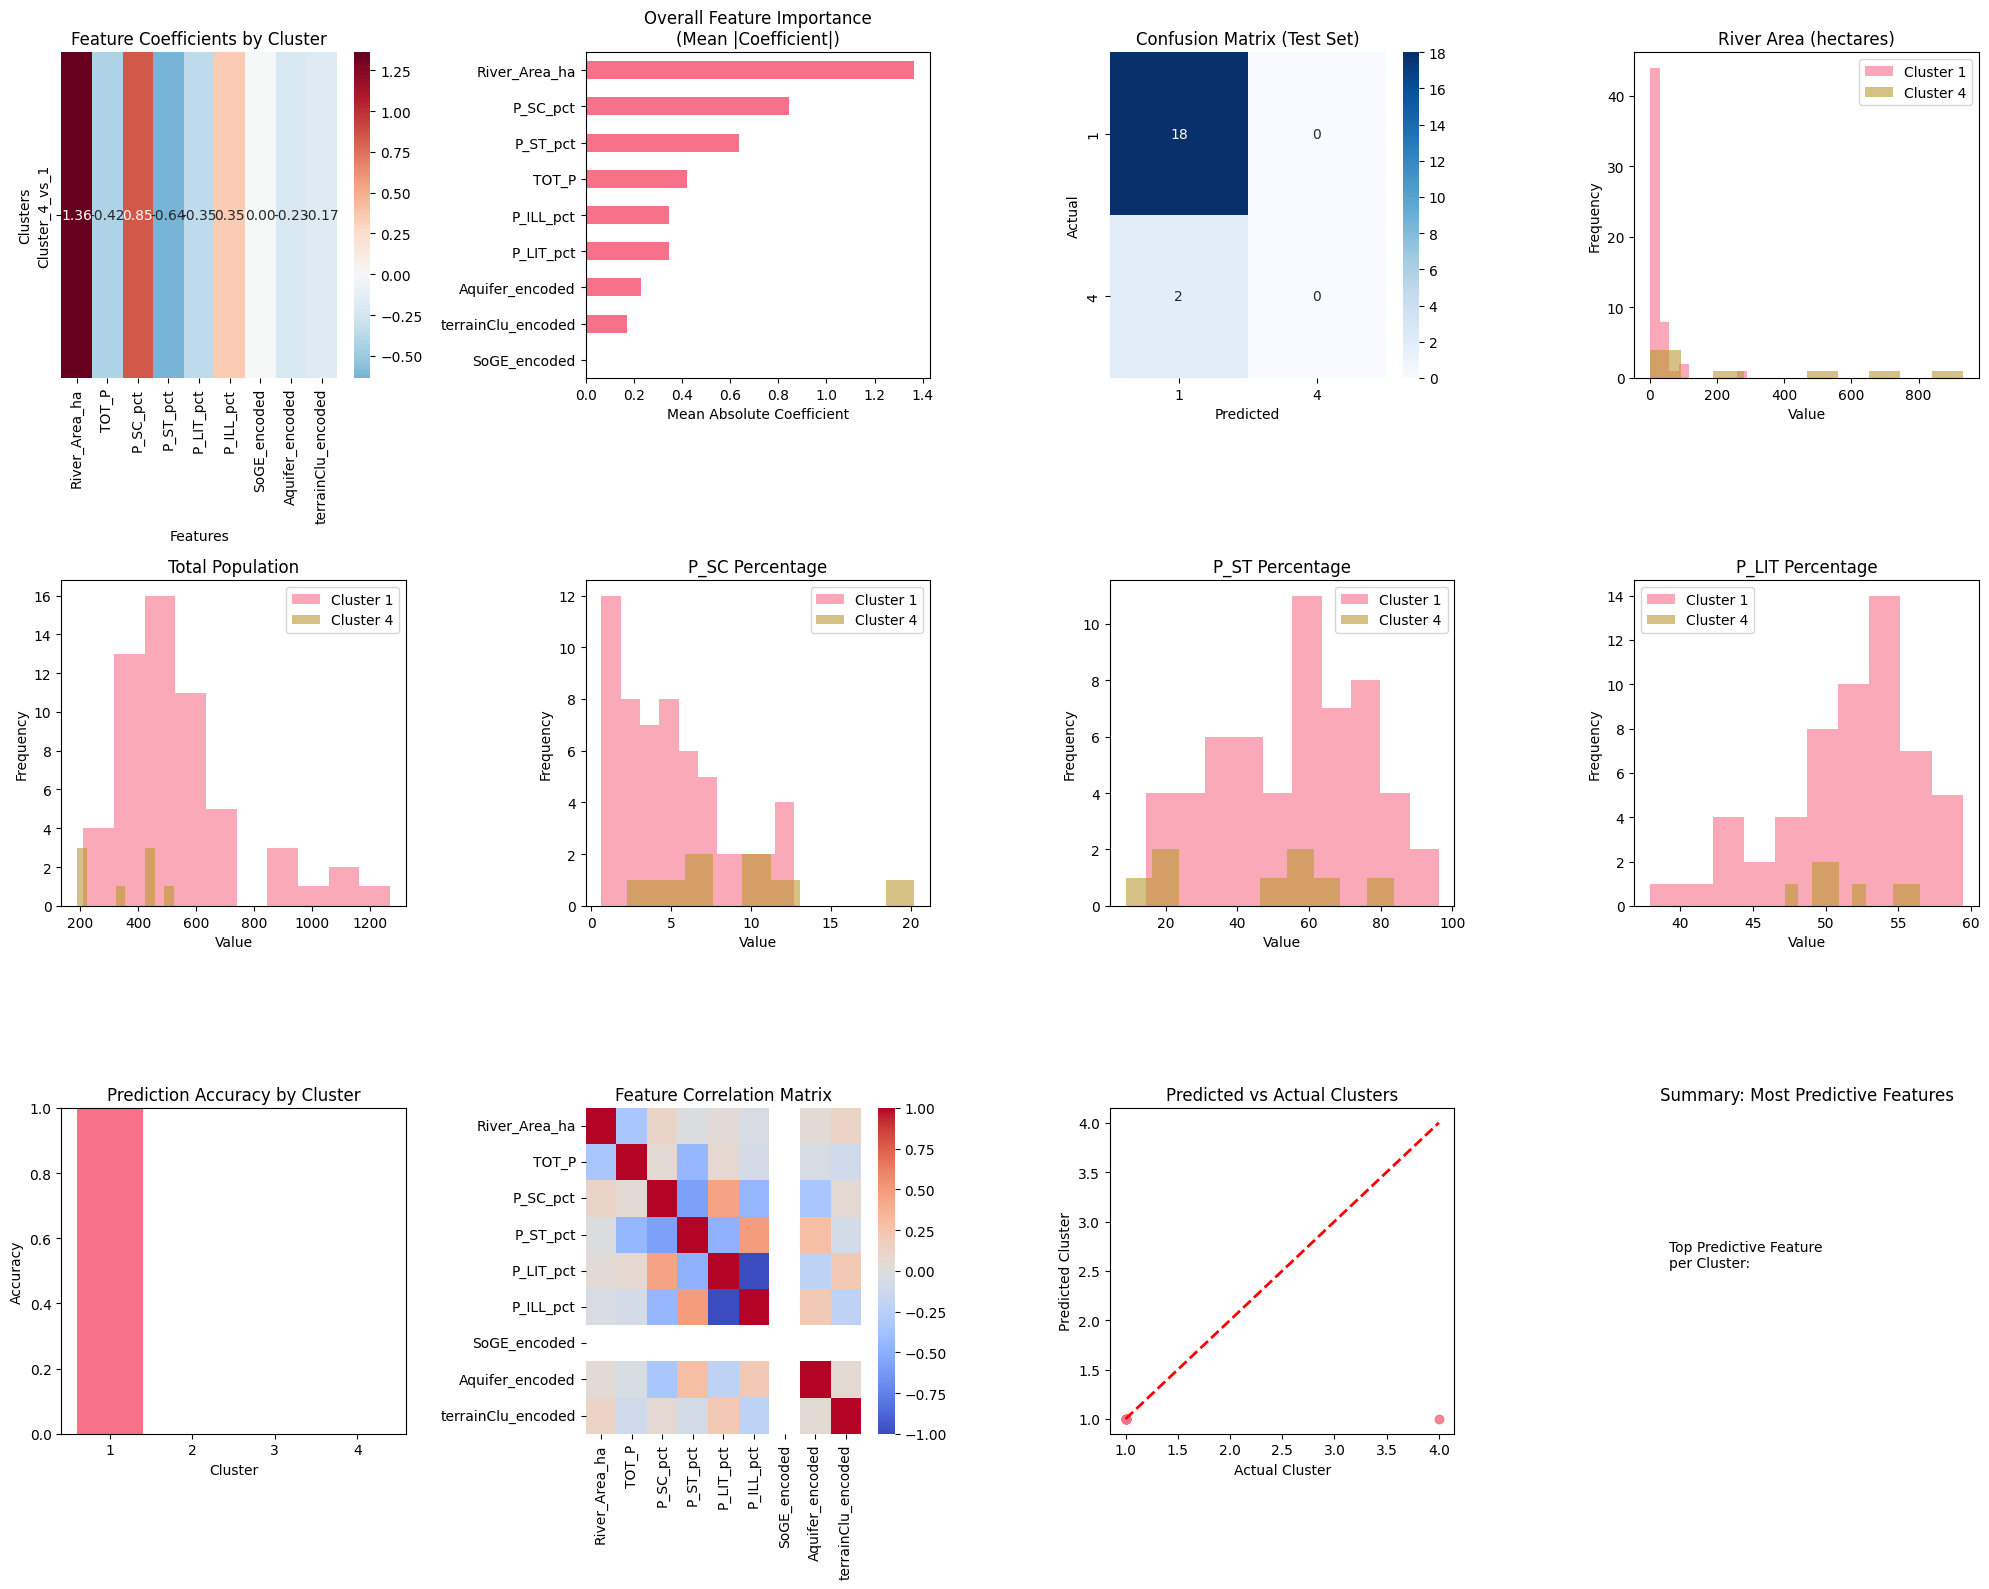


=== 9. CLUSTER PREDICTION EXAMPLES ===
Prediction examples (showing top 3 probabilities):

MWS 12_344879:
  Actual: Cluster 1, Predicted: Cluster 1
  Top probabilities:
    Cluster 0: 0.899
    Cluster 1: 0.101

MWS 12_342256:
  Actual: Cluster 4, Predicted: Cluster 4
  Top probabilities:
    Cluster 1: 0.891
    Cluster 0: 0.109

MWS 12_346952:
  Actual: Cluster 4, Predicted: Cluster 4
  Top probabilities:
    Cluster 1: 0.740
    Cluster 0: 0.260

MWS 12_367323:
  Actual: Cluster 1, Predicted: Cluster 1
  Top probabilities:
    Cluster 0: 0.926
    Cluster 1: 0.074

MWS 12_347489:
  Actual: Cluster 4, Predicted: Cluster 1
  Top probabilities:
    Cluster 0: 0.558
    Cluster 1: 0.442

=== 10. KEY INSIGHTS FROM LOGISTIC REGRESSION ===

=== 10. KEY INSIGHTS FROM LOGISTIC REGRESSION ===
Most Important Features Overall:
  1. River Area (hectares): 1.362 → Cluster 4
  2. P_SC Percentage: 0.846 → Cluster 1
  3. P_ST Percentage: 0.636 → Cluster 4
  4. Total Population: 0.420 → Cluster 1
  

In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.multiclass import OneVsRestClassifier
import warnings
warnings.filterwarnings('ignore')

print("=== LOGISTIC REGRESSION CLUSTER EXPLANATION ===")

# Prepare the data (assuming previous analysis has been run and census data converted)
analysis_df = shapefile[['uid', 'Cluster', 'SoGE', 'River_Area_ha', 'Aquifer', 'terrainClu',
                        'P_SC', 'P_ST', 'P_LIT', 'P_ILL', 'TOT_P']].copy()

# Convert census counts to percentages
analysis_df['P_SC_pct'] = (analysis_df['P_SC'] / analysis_df['TOT_P'] * 100).fillna(0)
analysis_df['P_ST_pct'] = (analysis_df['P_ST'] / analysis_df['TOT_P'] * 100).fillna(0)
analysis_df['P_LIT_pct'] = (analysis_df['P_LIT'] / analysis_df['TOT_P'] * 100).fillna(0)
analysis_df['P_ILL_pct'] = (analysis_df['P_ILL'] / analysis_df['TOT_P'] * 100).fillna(0)

# Clean data
for col in ['P_SC_pct', 'P_ST_pct', 'P_LIT_pct', 'P_ILL_pct']:
    analysis_df[col] = np.clip(analysis_df[col], 0, 100)

# Remove rows with missing cluster assignments
analysis_df = analysis_df.dropna(subset=['Cluster'])

print(f"Dataset size: {len(analysis_df)} MWS units")
print(f"Clusters: {sorted(analysis_df['Cluster'].unique())}")
print(f"Cluster distribution:\n{analysis_df['Cluster'].value_counts().sort_index()}")

# 1. PREPARE FEATURES FOR LOGISTIC REGRESSION
print("\n=== 1. FEATURE PREPARATION ===")

# Numerical features
numerical_features = ['River_Area_ha', 'TOT_P', 'P_SC_pct', 'P_ST_pct', 'P_LIT_pct', 'P_ILL_pct']

# Encode categorical features
label_encoders = {}
categorical_features = ['SoGE', 'Aquifer', 'terrainClu']

# Create a copy for modeling
model_df = analysis_df.copy()

for col in categorical_features:
    if col in model_df.columns:
        le = LabelEncoder()
        model_df[f'{col}_encoded'] = le.fit_transform(model_df[col].astype(str))
        label_encoders[col] = le
        print(f"Encoded {col}: {dict(zip(le.classes_, le.transform(le.classes_)))}")

# All features for modeling
feature_columns = numerical_features + [f'{col}_encoded' for col in categorical_features if col in model_df.columns]
print(f"\nFeatures for modeling: {feature_columns}")

# Prepare X (features) and y (target)
X = model_df[feature_columns].fillna(0)
y = model_df['Cluster'].astype(int)

print(f"Feature matrix shape: {X.shape}")
print(f"Target distribution:\n{y.value_counts().sort_index()}")

# 2. SCALE FEATURES
print("\n=== 2. FEATURE SCALING ===")
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=feature_columns, index=X.index)

print("Feature scaling completed.")
print("Scaled feature means (should be ~0):")
print(X_scaled_df.mean().round(3))

# 3. TRAIN LOGISTIC REGRESSION MODEL
print("\n=== 3. LOGISTIC REGRESSION TRAINING ===")

# Check if we have enough data for train/test split
if len(X) > 20:
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42, stratify=y)
    use_test_set = True
    print(f"Using train/test split: {len(X_train)} train, {len(X_test)} test")
else:
    X_train, y_train = X_scaled, y
    use_test_set = False
    print(f"Small dataset: using all {len(X_train)} samples for training")

# Train model - Handle binary vs multi-class case
if len(cluster_labels) == 2:
    # For binary classification, use standard LogisticRegression
    lr_model = LogisticRegression(random_state=42, max_iter=1000)
    lr_model.fit(X_train, y_train)
    is_binary = True
else:
    # For multi-class, use OneVsRest
    lr_model = OneVsRestClassifier(
        LogisticRegression(random_state=42, max_iter=1000, multi_class='ovr'),
        n_jobs=-1
    )
    lr_model.fit(X_train, y_train)
    is_binary = False

print("Model training completed.")

# 4. MODEL PERFORMANCE
print("\n=== 4. MODEL PERFORMANCE ===")

y_pred_train = lr_model.predict(X_train)
train_accuracy = accuracy_score(y_train, y_pred_train)
print(f"Training Accuracy: {train_accuracy:.3f}")

if use_test_set:
    y_pred_test = lr_model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_pred_test)
    print(f"Test Accuracy: {test_accuracy:.3f}")

    print("\nClassification Report (Test Set):")
    print(classification_report(y_test, y_pred_test))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred_test)
    print(f"\nConfusion Matrix (Test Set):")
    print(cm)
else:
    print("\nClassification Report (Training Set):")
    print(classification_report(y_train, y_pred_train))

# 5. FEATURE IMPORTANCE ANALYSIS
print("\n=== 5. FEATURE IMPORTANCE ANALYSIS ===")

# Get feature importance (coefficients) for each cluster
cluster_labels = sorted(y.unique())
n_clusters = len(cluster_labels)

coefficients_dict = {}

if is_binary:
    # For binary classification, we get one set of coefficients
    coef = lr_model.coef_[0]
    # Positive coefficients favor the positive class (higher cluster number)
    # Negative coefficients favor the negative class (lower cluster number)
    coefficients_dict[f'Cluster_{cluster_labels[1]}_vs_{cluster_labels[0]}'] = coef
    print(f"Binary classification: Coefficients represent {cluster_labels[1]} vs {cluster_labels[0]}")
    print("Positive coef = favors higher cluster, Negative coef = favors lower cluster")
else:
    # For multi-class OneVsRest
    for i, cluster in enumerate(cluster_labels):
        if i < len(lr_model.estimators_) and hasattr(lr_model.estimators_[i], 'coef_'):
            coef = lr_model.estimators_[i].coef_[0]
            coefficients_dict[f'Cluster_{cluster}'] = coef

# Create DataFrame of coefficients
coef_df = pd.DataFrame(coefficients_dict, index=feature_columns)
print("Logistic Regression Coefficients (Feature Importance):")
print(coef_df.round(3))

# Feature importance ranking for each cluster
print("\n=== 6. TOP PREDICTIVE FEATURES BY CLUSTER ===")

if is_binary:
    # For binary classification, interpret coefficients
    col_name = coef_df.columns[0]  # Should be 'Cluster_4_vs_1'
    feature_importance = coef_df[col_name].abs().sort_values(ascending=False)

    print(f"Binary Classification: {cluster_labels[1]} vs {cluster_labels[0]}")
    print("Features that distinguish between clusters:")
    print(f"(Positive coef → favors Cluster {cluster_labels[1]}, Negative coef → favors Cluster {cluster_labels[0]})")

    for i, (feature, abs_importance) in enumerate(feature_importance.head(8).items()):
        coef_value = coef_df.loc[feature, col_name]
        if coef_value > 0:
            interpretation = f"Favors Cluster {cluster_labels[1]}"
        else:
            interpretation = f"Favors Cluster {cluster_labels[0]}"
        print(f"  {i+1}. {feature}: {abs_importance:.3f} ({interpretation}, coef={coef_value:.3f})")

else:
    # For multi-class
    for cluster in cluster_labels:
        col_name = f'Cluster_{cluster}'
        if col_name in coef_df.columns:
            cluster_coef = coef_df[col_name].abs().sort_values(ascending=False)
            print(f"\nCluster {cluster} - Most Predictive Features:")
            for i, (feature, importance) in enumerate(cluster_coef.head(5).items()):
                direction = "+" if coef_df.loc[feature, col_name] > 0 else "-"
                print(f"  {i+1}. {feature}: {importance:.3f} ({direction})")

# 7. FEATURE INTERPRETATION
print("\n=== 7. FEATURE INTERPRETATION ===")

def interpret_feature_name(feature_name):
    """Convert encoded feature names back to interpretable names"""
    if feature_name.endswith('_encoded'):
        base_name = feature_name.replace('_encoded', '')
        if base_name in label_encoders:
            return f"{base_name} (categorical)"
    elif feature_name.endswith('_pct'):
        return feature_name.replace('_pct', ' Percentage')
    elif feature_name == 'River_Area_ha':
        return 'River Area (hectares)'
    elif feature_name == 'TOT_P':
        return 'Total Population'
    return feature_name

print("Feature Interpretation Guide:")
for feature in feature_columns:
    interpretation = interpret_feature_name(feature)
    print(f"  {feature} → {interpretation}")

# 8. VISUALIZATIONS
print("\n=== 8. GENERATING VISUALIZATIONS ===")

fig = plt.figure(figsize=(20, 16))

# 8.1 Feature Importance Heatmap
plt.subplot(3, 4, 1)
sns.heatmap(coef_df.T, annot=True, cmap='RdBu_r', center=0, fmt='.2f')
plt.title('Feature Coefficients by Cluster')
plt.xlabel('Features')
plt.ylabel('Clusters')

# 8.2 Feature Importance Bar Plot (Overall)
plt.subplot(3, 4, 2)
overall_importance = coef_df.abs().mean(axis=1).sort_values(ascending=True)
overall_importance.plot(kind='barh')
plt.title('Overall Feature Importance\n(Mean |Coefficient|)')
plt.xlabel('Mean Absolute Coefficient')

# 8.3 Confusion Matrix (if test set available)
if use_test_set:
    plt.subplot(3, 4, 3)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=cluster_labels, yticklabels=cluster_labels)
    plt.title('Confusion Matrix (Test Set)')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

# 8.4-8.8 Feature Distributions by Cluster
feature_plot_cols = ['River_Area_ha', 'TOT_P', 'P_SC_pct', 'P_ST_pct', 'P_LIT_pct']
for i, feature in enumerate(feature_plot_cols):
    plt.subplot(3, 4, 4 + i)
    for cluster in cluster_labels:
        cluster_data = analysis_df[analysis_df['Cluster'] == cluster][feature]
        plt.hist(cluster_data, alpha=0.6, label=f'Cluster {cluster}', bins=10)
    plt.title(f'{interpret_feature_name(feature)}')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.legend()

# 8.9 Model Accuracy by Cluster
if use_test_set:
    plt.subplot(3, 4, 9)
    cluster_accuracies = []
    for cluster in cluster_labels:
        cluster_mask = y_test == cluster
        if cluster_mask.sum() > 0:
            cluster_acc = (y_pred_test[cluster_mask] == cluster).mean()
            cluster_accuracies.append(cluster_acc)
        else:
            cluster_accuracies.append(0)

    plt.bar(cluster_labels, cluster_accuracies)
    plt.title('Prediction Accuracy by Cluster')
    plt.xlabel('Cluster')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)

# 8.10 Feature Correlation Matrix
plt.subplot(3, 4, 10)
correlation_matrix = X_scaled_df.corr()
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', center=0)
plt.title('Feature Correlation Matrix')

# 8.11 Predicted vs Actual
if use_test_set:
    plt.subplot(3, 4, 11)
    plt.scatter(y_test, y_pred_test, alpha=0.6)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.xlabel('Actual Cluster')
    plt.ylabel('Predicted Cluster')
    plt.title('Predicted vs Actual Clusters')

# 8.12 Top Features Summary
plt.subplot(3, 4, 12)
# Show top 3 features for each cluster
top_features_summary = []
for cluster in cluster_labels:
    col_name = f'Cluster_{cluster}'
    if col_name in coef_df.columns:
        top_feature = coef_df[col_name].abs().idxmax()
        top_coef = coef_df.loc[top_feature, col_name]
        top_features_summary.append(f'C{cluster}: {top_feature[:8]}')

plt.text(0.1, 0.5, 'Top Predictive Feature\nper Cluster:\n\n' + '\n'.join(top_features_summary),
         transform=plt.gca().transAxes, fontsize=10, verticalalignment='center')
plt.axis('off')
plt.title('Summary: Most Predictive Features')

plt.tight_layout()
plt.show()

# 9. CLUSTER PREDICTION EXAMPLES
print("\n=== 9. CLUSTER PREDICTION EXAMPLES ===")

# Get prediction probabilities for a few examples
if hasattr(lr_model, 'predict_proba'):
    sample_indices = analysis_df.index[:5]  # First 5 examples
    sample_X = X_scaled[sample_indices]
    sample_probs = lr_model.predict_proba(sample_X)
    sample_preds = lr_model.predict(sample_X)
    sample_actual = y.iloc[sample_indices].values

    print("Prediction examples (showing top 3 probabilities):")
    for i, idx in enumerate(sample_indices):
        uid = analysis_df.loc[idx, 'uid']
        actual = sample_actual[i]
        predicted = sample_preds[i]
        probs = sample_probs[i]

        # Get top 3 cluster probabilities
        top_clusters = np.argsort(probs)[-3:][::-1]
        top_probs = probs[top_clusters]

        print(f"\nMWS {uid}:")
        print(f"  Actual: Cluster {actual}, Predicted: Cluster {predicted}")
        print(f"  Top probabilities:")
        for j, (cluster, prob) in enumerate(zip(top_clusters, top_probs)):
            print(f"    Cluster {cluster}: {prob:.3f}")

# 10. KEY INSIGHTS SUMMARY
print("\n=== 10. KEY INSIGHTS FROM LOGISTIC REGRESSION ===")

# 10. KEY INSIGHTS SUMMARY
print("\n=== 10. KEY INSIGHTS FROM LOGISTIC REGRESSION ===")

print("Most Important Features Overall:")
if is_binary:
    overall_importance = coef_df.iloc[:, 0].abs().sort_values(ascending=False)
    for i, (feature, importance) in enumerate(overall_importance.head(5).items()):
        coef_value = coef_df.iloc[overall_importance.index.get_loc(feature), 0]
        interpretation = interpret_feature_name(feature)
        direction = f"→ Cluster {cluster_labels[1]}" if coef_value > 0 else f"→ Cluster {cluster_labels[0]}"
        print(f"  {i+1}. {interpretation}: {importance:.3f} {direction}")
else:
    overall_importance = coef_df.abs().mean(axis=1).sort_values(ascending=False)
    for i, (feature, importance) in enumerate(overall_importance.head(5).items()):
        interpretation = interpret_feature_name(feature)
        print(f"  {i+1}. {interpretation}: {importance:.3f}")

print(f"\nModel Performance:")
print(f"  Training Accuracy: {train_accuracy:.1%}")
if use_test_set:
    print(f"  Test Accuracy: {test_accuracy:.1%}")

print(f"\nDataset Characteristics:")
print(f"  Total MWS units: {len(analysis_df)}")
print(f"  Cluster distribution: {dict(analysis_df['Cluster'].value_counts().sort_index())}")

if is_binary:
    print(f"\nBinary Classification Insights:")
    print(f"  Distinguishing Cluster {cluster_labels[1]} from Cluster {cluster_labels[0]}")

    # Find strongest predictors for each cluster
    col_name = coef_df.columns[0]
    strongest_positive = coef_df[col_name].idxmax()
    strongest_negative = coef_df[col_name].idxmin()
    pos_val = coef_df.loc[strongest_positive, col_name]
    neg_val = coef_df.loc[strongest_negative, col_name]

    print(f"  Strongest predictor of Cluster {cluster_labels[1]}: {interpret_feature_name(strongest_positive)} ({pos_val:.3f})")
    print(f"  Strongest predictor of Cluster {cluster_labels[0]}: {interpret_feature_name(strongest_negative)} ({neg_val:.3f})")

else:
    print("\nCluster Distinguishing Patterns:")
    for cluster in cluster_labels:
        col_name = f'Cluster_{cluster}'
        if col_name in coef_df.columns:
            cluster_coef = coef_df[col_name]
            strongest_positive = cluster_coef.idxmax()
            strongest_negative = cluster_coef.idxmin()

            pos_val = cluster_coef[strongest_positive]
            neg_val = cluster_coef[strongest_negative]

            print(f"  Cluster {cluster}:")
            if pos_val > 0.1:
                print(f"    Most associated with: {interpret_feature_name(strongest_positive)} (+{pos_val:.2f})")
            if neg_val < -0.1:
                print(f"    Least associated with: {interpret_feature_name(strongest_negative)} ({neg_val:.2f})")

print("\n=== ANALYSIS COMPLETE ===")
print("Logistic Regression provides probabilistic cluster membership predictions.")
print("Coefficients show which features most strongly predict each cluster.")
print("Use this alongside the descriptive statistics for comprehensive cluster understanding.")